In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import copy
from functools import partial

In [3]:
import numpy as np
import torch
import matplotlib.pyplot as plt

In [4]:
from metal.mmtl.metal_model import MetalModel
from metal.mmtl.slicing.slice_model import SliceModel, SliceRepModel, SliceQPModel, SliceCatModel, SliceEnsembleModel
from metal.mmtl.slicing.moe_model import MoEModel

from metal.mmtl.trainer import MultitaskTrainer
from metal.mmtl.slicing.synthetics.mmtl_utils import create_tasks, create_payloads, train_slice_experts
from metal.mmtl.slicing.synthetics.data_generator import generate_data, get_circle_mask
from metal.mmtl.slicing.synthetics.viz import visualize_payload, visualize_predictions, visualize_attention, score_and_visualize

In [5]:
from metal.utils import set_seed

seed = 444
set_seed(seed)

### Generate Synthetic Dataset
We aim to build a dataset with a linear decision boundary and an abnormal boundary around $x=0.25, y=0$.
We define this slice as our `critical_region`.

In [6]:
from functools import partial
flip_1 = partial(get_circle_mask, center=(0.25, 0), radius=0.2)
flip_2 = partial(get_circle_mask, center=(-0.3, -0.5), radius=0.15)

label_flips = {
    flip_1: 1,
    flip_2: 2
}
uid_lists, Xs, Ys = generate_data(N=5000, label_flips=label_flips)
task_name = "test_task"

#### Generate eval payload over the `critical_slice`

In [7]:
# targets all the data -- used to add the BASE labelset to payloads
identity_fn = lambda x: np.ones(x.shape[0], dtype=np.bool)
# NOTE: the slice function _imperfectly_ targets the critical slice area.
slice_1 = partial(get_circle_mask, center=(0.35, -0.1), radius=0.2)
slice_2 = partial(get_circle_mask, center=(-0.35, -0.4), radius=0.15)

remainder = lambda X: np.logical_not(np.logical_or(slice_1(X), slice_2(X)))

In [8]:
eval_payload = create_payloads(task_name, uid_lists, Xs, Ys, batch_size=1000, 
   slice_funcs={"slice_1": slice_1, "slice_2": slice_2, "remainder": remainder}
#    slice_funcs={"slice_1": flip_1, "slice_2": flip_2}
)[2] # take test set

Vizualizing labelset_gold from payload_test


/opt/anaconda3/lib/python3.7/site-packages/matplotlib/figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  "Adding an axes using the same arguments as a previous axes "


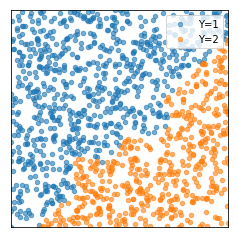

Vizualizing labelset:slice_1:pred from payload_test


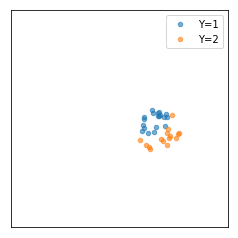

Vizualizing labelset:slice_1:ind from payload_test


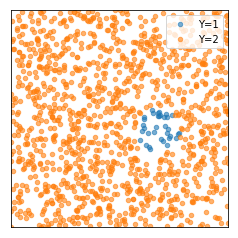

Vizualizing labelset:slice_2:pred from payload_test


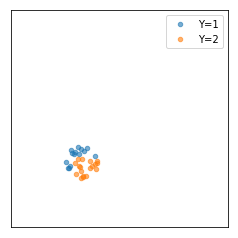

Vizualizing labelset:slice_2:ind from payload_test


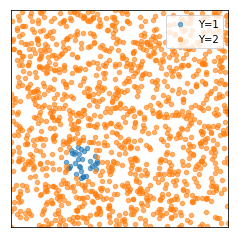

Vizualizing labelset:remainder:pred from payload_test


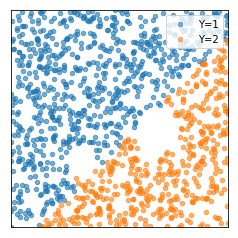

Vizualizing labelset:remainder:ind from payload_test


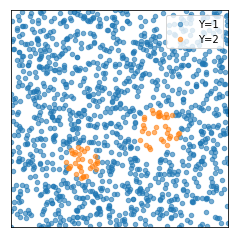

In [9]:
visualize_payload(eval_payload)

### Initialize and train each model type

In [10]:
# all models to test to test
all_slice_funcs = {"slice_1": slice_1, "slice_2": slice_2, "BASE": identity_fn}
slice_loss_multiplier = 1.0 / (2*len(all_slice_funcs))
# h_dim = 2
rep_dim = 7
h_dim = None
# h_dim = 2

model_configs = {
#     'soft_ens_param': {
#         'slice_funcs': all_slice_funcs,
#         'create_ind': True,
#         'model_class': SliceEnsembleModel,
#         'slice_weights': {
#             'BASE': slice_loss_multiplier,
#             'slice_1': slice_loss_multiplier, 'slice_2': slice_loss_multiplier
#         },
#         'custom_neck_dim': 2*len(all_slice_funcs)
#     }, 
#     'soft_cat_param': {
#         'slice_funcs': all_slice_funcs,
#         'create_ind': True,
#         'create_preds': False,
#         'model_class': SliceCatModel,
#         'slice_weights': {
#             'BASE': slice_loss_multiplier,
#             'slice_1': slice_loss_multiplier, 'slice_2': slice_loss_multiplier
#         },
#         'h_dim': h_dim,
#         'custom_neck_dim': (h_dim+1)*len(all_slice_funcs)
#     },   
#     'soft_param': {
#         'slice_funcs': all_slice_funcs,
#         'create_ind': True,
#         'model_class': SliceModel,
#         'slice_weights': {
#             'BASE': slice_loss_multiplier,
#             'slice_1': slice_loss_multiplier, 'slice_2': slice_loss_multiplier
#         }
#     },   
#     'soft_param_rep': {
#         'slice_funcs': all_slice_funcs,
#         'create_ind': True,
#         'create_preds': False,
#         'model_class': SliceRepModel,
#         'slice_weights': {
#             'BASE': slice_loss_multiplier,
#             'slice_1': slice_loss_multiplier, 'slice_2': slice_loss_multiplier
#         },
#         'h_dim': h_dim
#     },
    'slice_qp_rep': {
        'slice_funcs': all_slice_funcs,
        'create_ind': True,
        'create_preds': False,
        'create_shared_slice_pred': True,
        'model_class': SliceQPModel,
        'slice_weights': {
            'BASE': slice_loss_multiplier,
            'slice_1': slice_loss_multiplier, 'slice_2': slice_loss_multiplier
        },
        'h_dim': h_dim,
        'use_ind_module': True
    },
#     }
#     'hard_param': {
#         'slice_funcs': all_slice_funcs,
#         'create_ind': False,
#         'model_class': MetalModel,
#         'slice_weights': {'slice_1': slice_loss_multiplier, 'slice_2': slice_loss_multiplier}
#     },
#     'manual_reweighting': {
#         'slice_funcs': all_slice_funcs,
#         'create_ind': False,
#         'slice_weights': {"slice_1": 50}, # 10x weight of slice_2, everythign else default
#         'model_class': MetalModel        
#     },
#     'moe': {
#         'slice_funcs': {},
#         'create_ind': False,
#         'model_class': MoEModel
#     },
#     'naive': {
#         'slice_funcs': {},
#         'model_class': MetalModel   
#     }
}

In [11]:
train_kwargs = {
    "lr": 0.01, 
    "n_epochs": 5000,
    "checkpoint_best": False,
    "log_every": 5.0,
    "writer": "tensorboard", 
    "verbose": True,
    "progress_bar": False
}

In [12]:
trained_models = {}

==========Initializing + Training slice_qp_rep==========
Creating 7 tasks...
BinaryClassificationTask(name=test_task:slice_1:pred, loss_multiplier=1.00, slice_head_type=pred)
BinaryClassificationTask(name=test_task:slice_1:ind, loss_multiplier=0.17, slice_head_type=ind)
BinaryClassificationTask(name=test_task:slice_2:pred, loss_multiplier=1.00, slice_head_type=pred)
BinaryClassificationTask(name=test_task:slice_2:ind, loss_multiplier=0.17, slice_head_type=ind)
BinaryClassificationTask(name=test_task:BASE:pred, loss_multiplier=1.00, slice_head_type=pred)
BinaryClassificationTask(name=test_task:BASE:ind, loss_multiplier=0.17, slice_head_type=ind)
BinaryClassificationTask(name=test_task, loss_multiplier=1.00, slice_head_type=None)
Creating 3 payloads...
Payload(payload_train: labels_to_tasks=[{'labelset_gold': 'test_task', 'labelset:slice_1:pred': 'test_task:slice_1:pred', 'labelset:slice_1:ind': 'test_task:slice_1:ind', 'labelset:slice_2:pred': 'test_task:slice_2:pred', 'labelset:slice_2

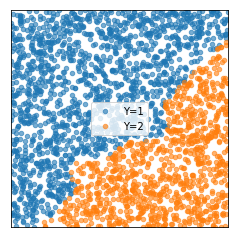

Vizualizing labelset:slice_1:pred from payload_train


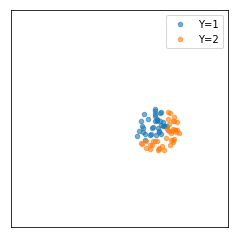

Vizualizing labelset:slice_1:ind from payload_train


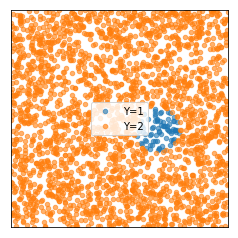

Vizualizing labelset:slice_2:pred from payload_train


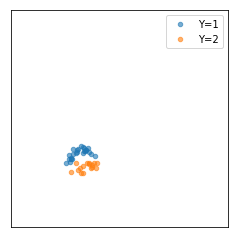

Vizualizing labelset:slice_2:ind from payload_train


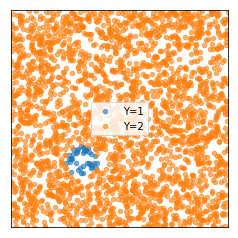

Vizualizing labelset:BASE:pred from payload_train


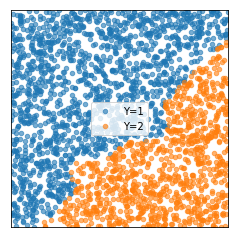

Vizualizing labelset:BASE:ind from payload_train


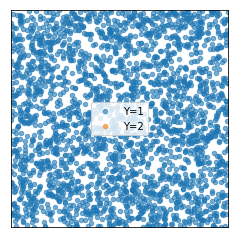

No cuda device available. Using cpu instead.

Network architecture:
SliceQPModel(
  (input_modules): ModuleDict(
    (test_task): DataParallel(
      (module): MetalModuleWrapper(
        (module): Sequential(
          (0): Linear(in_features=2, out_features=7, bias=True)
          (1): ReLU()
        )
      )
    )
    (test_task:BASE:ind): DataParallel(
      (module): MetalModuleWrapper(
        (module): Sequential(
          (0): Linear(in_features=2, out_features=7, bias=True)
          (1): ReLU()
        )
      )
    )
    (test_task:BASE:pred): DataParallel(
      (module): MetalModuleWrapper(
        (module): Sequential(
          (0): Linear(in_features=2, out_features=7, bias=True)
          (1): ReLU()
        )
      )
    )
    (test_task:slice_1:ind): DataParallel(
      (module): MetalModuleWrapper(
        (module): Sequential(
          (0): Linear(in_features=2, out_features=7, bias=True)
          (1): ReLU()
        )
      )
    )
    (test_task:slice_1:pred)

[20.0 epo]: test_task:[payload_train/labelset_gold/loss=8.31e-02, payload_valid/labelset_gold/accuracy=9.74e-01, payload_valid/labelset_gold/f1=9.78e-01, payload_valid/labelset_gold/acc_f1=9.76e-01] test_task:slice_1:ind:[payload_train/labelset:slice_1:ind/loss=1.36e-02, payload_valid/labelset:slice_1:ind/accuracy=9.67e-01, payload_valid/labelset:slice_1:ind/f1=0.00e+00, payload_valid/labelset:slice_1:ind/acc_f1=4.84e-01] test_task:slice_2:ind:[payload_train/labelset:slice_2:ind/loss=1.01e-02, payload_valid/labelset:slice_2:ind/accuracy=9.78e-01, payload_valid/labelset:slice_2:ind/f1=0.00e+00, payload_valid/labelset:slice_2:ind/acc_f1=4.89e-01] test_task:BASE:pred:[payload_train/labelset:BASE:pred/loss=8.70e-02, payload_valid/labelset:BASE:pred/accuracy=9.70e-01, payload_valid/labelset:BASE:pred/f1=9.74e-01, payload_valid/labelset:BASE:pred/acc_f1=9.72e-01] test_task:BASE:ind:[payload_train/labelset:BASE:ind/loss=9.07e-06, payload_valid/labelset:BASE:ind/accuracy=1.00e+00, payload_vali

[50.0 epo]: test_task:[payload_train/labelset_gold/loss=7.66e-02, payload_valid/labelset_gold/accuracy=9.78e-01, payload_valid/labelset_gold/f1=9.82e-01, payload_valid/labelset_gold/acc_f1=9.80e-01] test_task:slice_1:ind:[payload_train/labelset:slice_1:ind/loss=1.15e-02, payload_valid/labelset:slice_1:ind/accuracy=9.67e-01, payload_valid/labelset:slice_1:ind/f1=0.00e+00, payload_valid/labelset:slice_1:ind/acc_f1=4.84e-01] test_task:slice_2:ind:[payload_train/labelset:slice_2:ind/loss=9.14e-03, payload_valid/labelset:slice_2:ind/accuracy=9.78e-01, payload_valid/labelset:slice_2:ind/f1=0.00e+00, payload_valid/labelset:slice_2:ind/acc_f1=4.89e-01] test_task:BASE:pred:[payload_train/labelset:BASE:pred/loss=8.18e-02, payload_valid/labelset:BASE:pred/accuracy=9.71e-01, payload_valid/labelset:BASE:pred/f1=9.76e-01, payload_valid/labelset:BASE:pred/acc_f1=9.73e-01] test_task:BASE:ind:[payload_train/labelset:BASE:ind/loss=5.85e-07, payload_valid/labelset:BASE:ind/accuracy=1.00e+00, payload_vali

[80.0 epo]: test_task:[payload_train/labelset_gold/loss=7.01e-02, payload_valid/labelset_gold/accuracy=9.82e-01, payload_valid/labelset_gold/f1=9.85e-01, payload_valid/labelset_gold/acc_f1=9.84e-01] test_task:slice_1:ind:[payload_train/labelset:slice_1:ind/loss=1.06e-02, payload_valid/labelset:slice_1:ind/accuracy=9.71e-01, payload_valid/labelset:slice_1:ind/f1=2.17e-01, payload_valid/labelset:slice_1:ind/acc_f1=5.94e-01] test_task:slice_2:ind:[payload_train/labelset:slice_2:ind/loss=7.93e-03, payload_valid/labelset:slice_2:ind/accuracy=9.78e-01, payload_valid/labelset:slice_2:ind/f1=0.00e+00, payload_valid/labelset:slice_2:ind/acc_f1=4.89e-01] test_task:BASE:pred:[payload_train/labelset:BASE:pred/loss=8.29e-02, payload_valid/labelset:BASE:pred/accuracy=9.72e-01, payload_valid/labelset:BASE:pred/f1=9.76e-01, payload_valid/labelset:BASE:pred/acc_f1=9.74e-01] test_task:BASE:ind:[payload_train/labelset:BASE:ind/loss=5.07e-04, payload_valid/labelset:BASE:ind/accuracy=1.00e+00, payload_vali

[110.0 epo]: test_task:[payload_train/labelset_gold/loss=6.25e-02, payload_valid/labelset_gold/accuracy=9.82e-01, payload_valid/labelset_gold/f1=9.85e-01, payload_valid/labelset_gold/acc_f1=9.84e-01] test_task:slice_1:ind:[payload_train/labelset:slice_1:ind/loss=9.79e-03, payload_valid/labelset:slice_1:ind/accuracy=9.72e-01, payload_valid/labelset:slice_1:ind/f1=3.40e-01, payload_valid/labelset:slice_1:ind/acc_f1=6.56e-01] test_task:slice_2:ind:[payload_train/labelset:slice_2:ind/loss=6.92e-03, payload_valid/labelset:slice_2:ind/accuracy=9.76e-01, payload_valid/labelset:slice_2:ind/f1=0.00e+00, payload_valid/labelset:slice_2:ind/acc_f1=4.88e-01] test_task:BASE:pred:[payload_train/labelset:BASE:pred/loss=7.85e-02, payload_valid/labelset:BASE:pred/accuracy=9.72e-01, payload_valid/labelset:BASE:pred/f1=9.76e-01, payload_valid/labelset:BASE:pred/acc_f1=9.74e-01] test_task:BASE:ind:[payload_train/labelset:BASE:ind/loss=1.43e-03, payload_valid/labelset:BASE:ind/accuracy=1.00e+00, payload_val

[140.0 epo]: test_task:[payload_train/labelset_gold/loss=5.19e-02, payload_valid/labelset_gold/accuracy=9.85e-01, payload_valid/labelset_gold/f1=9.87e-01, payload_valid/labelset_gold/acc_f1=9.86e-01] test_task:slice_1:ind:[payload_train/labelset:slice_1:ind/loss=9.24e-03, payload_valid/labelset:slice_1:ind/accuracy=9.76e-01, payload_valid/labelset:slice_1:ind/f1=5.71e-01, payload_valid/labelset:slice_1:ind/acc_f1=7.74e-01] test_task:slice_2:ind:[payload_train/labelset:slice_2:ind/loss=6.69e-03, payload_valid/labelset:slice_2:ind/accuracy=9.76e-01, payload_valid/labelset:slice_2:ind/f1=0.00e+00, payload_valid/labelset:slice_2:ind/acc_f1=4.88e-01] test_task:BASE:pred:[payload_train/labelset:BASE:pred/loss=7.37e-02, payload_valid/labelset:BASE:pred/accuracy=9.71e-01, payload_valid/labelset:BASE:pred/f1=9.76e-01, payload_valid/labelset:BASE:pred/acc_f1=9.73e-01] test_task:BASE:ind:[payload_train/labelset:BASE:ind/loss=2.06e-03, payload_valid/labelset:BASE:ind/accuracy=9.95e-01, payload_val

[170.0 epo]: test_task:[payload_train/labelset_gold/loss=4.41e-02, payload_valid/labelset_gold/accuracy=9.87e-01, payload_valid/labelset_gold/f1=9.89e-01, payload_valid/labelset_gold/acc_f1=9.88e-01] test_task:slice_1:ind:[payload_train/labelset:slice_1:ind/loss=8.59e-03, payload_valid/labelset:slice_1:ind/accuracy=9.75e-01, payload_valid/labelset:slice_1:ind/f1=5.87e-01, payload_valid/labelset:slice_1:ind/acc_f1=7.81e-01] test_task:slice_2:ind:[payload_train/labelset:slice_2:ind/loss=6.33e-03, payload_valid/labelset:slice_2:ind/accuracy=9.77e-01, payload_valid/labelset:slice_2:ind/f1=0.00e+00, payload_valid/labelset:slice_2:ind/acc_f1=4.88e-01] test_task:BASE:pred:[payload_train/labelset:BASE:pred/loss=6.85e-02, payload_valid/labelset:BASE:pred/accuracy=9.72e-01, payload_valid/labelset:BASE:pred/f1=9.76e-01, payload_valid/labelset:BASE:pred/acc_f1=9.74e-01] test_task:BASE:ind:[payload_train/labelset:BASE:ind/loss=1.70e-03, payload_valid/labelset:BASE:ind/accuracy=9.96e-01, payload_val

[200.0 epo]: test_task:[payload_train/labelset_gold/loss=4.12e-02, payload_valid/labelset_gold/accuracy=9.87e-01, payload_valid/labelset_gold/f1=9.89e-01, payload_valid/labelset_gold/acc_f1=9.88e-01] test_task:slice_1:ind:[payload_train/labelset:slice_1:ind/loss=7.99e-03, payload_valid/labelset:slice_1:ind/accuracy=9.76e-01, payload_valid/labelset:slice_1:ind/f1=5.95e-01, payload_valid/labelset:slice_1:ind/acc_f1=7.85e-01] test_task:slice_2:ind:[payload_train/labelset:slice_2:ind/loss=6.20e-03, payload_valid/labelset:slice_2:ind/accuracy=9.76e-01, payload_valid/labelset:slice_2:ind/f1=0.00e+00, payload_valid/labelset:slice_2:ind/acc_f1=4.88e-01] test_task:BASE:pred:[payload_train/labelset:BASE:pred/loss=6.47e-02, payload_valid/labelset:BASE:pred/accuracy=9.71e-01, payload_valid/labelset:BASE:pred/f1=9.76e-01, payload_valid/labelset:BASE:pred/acc_f1=9.73e-01] test_task:BASE:ind:[payload_train/labelset:BASE:ind/loss=1.29e-03, payload_valid/labelset:BASE:ind/accuracy=9.97e-01, payload_val

[230.0 epo]: test_task:[payload_train/labelset_gold/loss=3.93e-02, payload_valid/labelset_gold/accuracy=9.85e-01, payload_valid/labelset_gold/f1=9.87e-01, payload_valid/labelset_gold/acc_f1=9.86e-01] test_task:slice_1:ind:[payload_train/labelset:slice_1:ind/loss=7.48e-03, payload_valid/labelset:slice_1:ind/accuracy=9.75e-01, payload_valid/labelset:slice_1:ind/f1=5.87e-01, payload_valid/labelset:slice_1:ind/acc_f1=7.81e-01] test_task:slice_2:ind:[payload_train/labelset:slice_2:ind/loss=5.89e-03, payload_valid/labelset:slice_2:ind/accuracy=9.76e-01, payload_valid/labelset:slice_2:ind/f1=1.18e-01, payload_valid/labelset:slice_2:ind/acc_f1=5.47e-01] test_task:BASE:pred:[payload_train/labelset:BASE:pred/loss=6.13e-02, payload_valid/labelset:BASE:pred/accuracy=9.72e-01, payload_valid/labelset:BASE:pred/f1=9.76e-01, payload_valid/labelset:BASE:pred/acc_f1=9.74e-01] test_task:BASE:ind:[payload_train/labelset:BASE:ind/loss=1.00e-03, payload_valid/labelset:BASE:ind/accuracy=9.98e-01, payload_val

[260.0 epo]: test_task:[payload_train/labelset_gold/loss=3.82e-02, payload_valid/labelset_gold/accuracy=9.86e-01, payload_valid/labelset_gold/f1=9.88e-01, payload_valid/labelset_gold/acc_f1=9.87e-01] test_task:slice_1:ind:[payload_train/labelset:slice_1:ind/loss=6.98e-03, payload_valid/labelset:slice_1:ind/accuracy=9.76e-01, payload_valid/labelset:slice_1:ind/f1=6.05e-01, payload_valid/labelset:slice_1:ind/acc_f1=7.91e-01] test_task:slice_2:ind:[payload_train/labelset:slice_2:ind/loss=5.81e-03, payload_valid/labelset:slice_2:ind/accuracy=9.76e-01, payload_valid/labelset:slice_2:ind/f1=1.18e-01, payload_valid/labelset:slice_2:ind/acc_f1=5.47e-01] test_task:BASE:pred:[payload_train/labelset:BASE:pred/loss=5.87e-02, payload_valid/labelset:BASE:pred/accuracy=9.74e-01, payload_valid/labelset:BASE:pred/f1=9.78e-01, payload_valid/labelset:BASE:pred/acc_f1=9.76e-01] test_task:BASE:ind:[payload_train/labelset:BASE:ind/loss=8.50e-04, payload_valid/labelset:BASE:ind/accuracy=9.99e-01, payload_val

[290.0 epo]: test_task:[payload_train/labelset_gold/loss=3.76e-02, payload_valid/labelset_gold/accuracy=9.85e-01, payload_valid/labelset_gold/f1=9.87e-01, payload_valid/labelset_gold/acc_f1=9.86e-01] test_task:slice_1:ind:[payload_train/labelset:slice_1:ind/loss=6.70e-03, payload_valid/labelset:slice_1:ind/accuracy=9.78e-01, payload_valid/labelset:slice_1:ind/f1=6.00e-01, payload_valid/labelset:slice_1:ind/acc_f1=7.89e-01] test_task:slice_2:ind:[payload_train/labelset:slice_2:ind/loss=5.63e-03, payload_valid/labelset:slice_2:ind/accuracy=9.77e-01, payload_valid/labelset:slice_2:ind/f1=1.71e-01, payload_valid/labelset:slice_2:ind/acc_f1=5.74e-01] test_task:BASE:pred:[payload_train/labelset:BASE:pred/loss=5.65e-02, payload_valid/labelset:BASE:pred/accuracy=9.74e-01, payload_valid/labelset:BASE:pred/f1=9.78e-01, payload_valid/labelset:BASE:pred/acc_f1=9.76e-01] test_task:BASE:ind:[payload_train/labelset:BASE:ind/loss=7.32e-04, payload_valid/labelset:BASE:ind/accuracy=1.00e+00, payload_val

[320.0 epo]: test_task:[payload_train/labelset_gold/loss=3.67e-02, payload_valid/labelset_gold/accuracy=9.85e-01, payload_valid/labelset_gold/f1=9.87e-01, payload_valid/labelset_gold/acc_f1=9.86e-01] test_task:slice_1:ind:[payload_train/labelset:slice_1:ind/loss=6.43e-03, payload_valid/labelset:slice_1:ind/accuracy=9.81e-01, payload_valid/labelset:slice_1:ind/f1=6.57e-01, payload_valid/labelset:slice_1:ind/acc_f1=8.19e-01] test_task:slice_2:ind:[payload_train/labelset:slice_2:ind/loss=5.45e-03, payload_valid/labelset:slice_2:ind/accuracy=9.76e-01, payload_valid/labelset:slice_2:ind/f1=1.18e-01, payload_valid/labelset:slice_2:ind/acc_f1=5.47e-01] test_task:BASE:pred:[payload_train/labelset:BASE:pred/loss=5.45e-02, payload_valid/labelset:BASE:pred/accuracy=9.78e-01, payload_valid/labelset:BASE:pred/f1=9.81e-01, payload_valid/labelset:BASE:pred/acc_f1=9.79e-01] test_task:BASE:ind:[payload_train/labelset:BASE:ind/loss=6.64e-04, payload_valid/labelset:BASE:ind/accuracy=1.00e+00, payload_val

[350.0 epo]: test_task:[payload_train/labelset_gold/loss=3.57e-02, payload_valid/labelset_gold/accuracy=9.85e-01, payload_valid/labelset_gold/f1=9.87e-01, payload_valid/labelset_gold/acc_f1=9.86e-01] test_task:slice_1:ind:[payload_train/labelset:slice_1:ind/loss=6.13e-03, payload_valid/labelset:slice_1:ind/accuracy=9.80e-01, payload_valid/labelset:slice_1:ind/f1=6.48e-01, payload_valid/labelset:slice_1:ind/acc_f1=8.14e-01] test_task:slice_2:ind:[payload_train/labelset:slice_2:ind/loss=5.13e-03, payload_valid/labelset:slice_2:ind/accuracy=9.77e-01, payload_valid/labelset:slice_2:ind/f1=1.71e-01, payload_valid/labelset:slice_2:ind/acc_f1=5.74e-01] test_task:BASE:pred:[payload_train/labelset:BASE:pred/loss=5.24e-02, payload_valid/labelset:BASE:pred/accuracy=9.78e-01, payload_valid/labelset:BASE:pred/f1=9.82e-01, payload_valid/labelset:BASE:pred/acc_f1=9.80e-01] test_task:BASE:ind:[payload_train/labelset:BASE:ind/loss=5.82e-04, payload_valid/labelset:BASE:ind/accuracy=1.00e+00, payload_val

[380.0 epo]: test_task:[payload_train/labelset_gold/loss=3.31e-02, payload_valid/labelset_gold/accuracy=9.86e-01, payload_valid/labelset_gold/f1=9.88e-01, payload_valid/labelset_gold/acc_f1=9.87e-01] test_task:slice_1:ind:[payload_train/labelset:slice_1:ind/loss=5.96e-03, payload_valid/labelset:slice_1:ind/accuracy=9.78e-01, payload_valid/labelset:slice_1:ind/f1=6.20e-01, payload_valid/labelset:slice_1:ind/acc_f1=7.99e-01] test_task:slice_2:ind:[payload_train/labelset:slice_2:ind/loss=5.06e-03, payload_valid/labelset:slice_2:ind/accuracy=9.76e-01, payload_valid/labelset:slice_2:ind/f1=1.67e-01, payload_valid/labelset:slice_2:ind/acc_f1=5.71e-01] test_task:BASE:pred:[payload_train/labelset:BASE:pred/loss=4.93e-02, payload_valid/labelset:BASE:pred/accuracy=9.81e-01, payload_valid/labelset:BASE:pred/f1=9.84e-01, payload_valid/labelset:BASE:pred/acc_f1=9.82e-01] test_task:BASE:ind:[payload_train/labelset:BASE:ind/loss=6.68e-04, payload_valid/labelset:BASE:ind/accuracy=1.00e+00, payload_val

[410.0 epo]: test_task:[payload_train/labelset_gold/loss=3.28e-02, payload_valid/labelset_gold/accuracy=9.85e-01, payload_valid/labelset_gold/f1=9.87e-01, payload_valid/labelset_gold/acc_f1=9.86e-01] test_task:slice_1:ind:[payload_train/labelset:slice_1:ind/loss=5.74e-03, payload_valid/labelset:slice_1:ind/accuracy=9.82e-01, payload_valid/labelset:slice_1:ind/f1=6.85e-01, payload_valid/labelset:slice_1:ind/acc_f1=8.33e-01] test_task:slice_2:ind:[payload_train/labelset:slice_2:ind/loss=4.95e-03, payload_valid/labelset:slice_2:ind/accuracy=9.76e-01, payload_valid/labelset:slice_2:ind/f1=1.67e-01, payload_valid/labelset:slice_2:ind/acc_f1=5.71e-01] test_task:BASE:pred:[payload_train/labelset:BASE:pred/loss=4.78e-02, payload_valid/labelset:BASE:pred/accuracy=9.80e-01, payload_valid/labelset:BASE:pred/f1=9.83e-01, payload_valid/labelset:BASE:pred/acc_f1=9.82e-01] test_task:BASE:ind:[payload_train/labelset:BASE:ind/loss=6.40e-04, payload_valid/labelset:BASE:ind/accuracy=9.99e-01, payload_val

[440.0 epo]: test_task:[payload_train/labelset_gold/loss=3.20e-02, payload_valid/labelset_gold/accuracy=9.86e-01, payload_valid/labelset_gold/f1=9.89e-01, payload_valid/labelset_gold/acc_f1=9.87e-01] test_task:slice_1:ind:[payload_train/labelset:slice_1:ind/loss=5.62e-03, payload_valid/labelset:slice_1:ind/accuracy=9.82e-01, payload_valid/labelset:slice_1:ind/f1=7.03e-01, payload_valid/labelset:slice_1:ind/acc_f1=8.43e-01] test_task:slice_2:ind:[payload_train/labelset:slice_2:ind/loss=4.94e-03, payload_valid/labelset:slice_2:ind/accuracy=9.76e-01, payload_valid/labelset:slice_2:ind/f1=1.67e-01, payload_valid/labelset:slice_2:ind/acc_f1=5.71e-01] test_task:BASE:pred:[payload_train/labelset:BASE:pred/loss=4.59e-02, payload_valid/labelset:BASE:pred/accuracy=9.79e-01, payload_valid/labelset:BASE:pred/f1=9.82e-01, payload_valid/labelset:BASE:pred/acc_f1=9.81e-01] test_task:BASE:ind:[payload_train/labelset:BASE:ind/loss=5.95e-04, payload_valid/labelset:BASE:ind/accuracy=9.99e-01, payload_val

[470.0 epo]: test_task:[payload_train/labelset_gold/loss=3.15e-02, payload_valid/labelset_gold/accuracy=9.86e-01, payload_valid/labelset_gold/f1=9.89e-01, payload_valid/labelset_gold/acc_f1=9.87e-01] test_task:slice_1:ind:[payload_train/labelset:slice_1:ind/loss=5.47e-03, payload_valid/labelset:slice_1:ind/accuracy=9.82e-01, payload_valid/labelset:slice_1:ind/f1=6.94e-01, payload_valid/labelset:slice_1:ind/acc_f1=8.38e-01] test_task:slice_2:ind:[payload_train/labelset:slice_2:ind/loss=4.93e-03, payload_valid/labelset:slice_2:ind/accuracy=9.78e-01, payload_valid/labelset:slice_2:ind/f1=1.76e-01, payload_valid/labelset:slice_2:ind/acc_f1=5.77e-01] test_task:BASE:pred:[payload_train/labelset:BASE:pred/loss=4.47e-02, payload_valid/labelset:BASE:pred/accuracy=9.81e-01, payload_valid/labelset:BASE:pred/f1=9.84e-01, payload_valid/labelset:BASE:pred/acc_f1=9.82e-01] test_task:BASE:ind:[payload_train/labelset:BASE:ind/loss=5.62e-04, payload_valid/labelset:BASE:ind/accuracy=9.99e-01, payload_val

[500.0 epo]: test_task:[payload_train/labelset_gold/loss=3.16e-02, payload_valid/labelset_gold/accuracy=9.87e-01, payload_valid/labelset_gold/f1=9.89e-01, payload_valid/labelset_gold/acc_f1=9.88e-01] test_task:slice_1:ind:[payload_train/labelset:slice_1:ind/loss=5.26e-03, payload_valid/labelset:slice_1:ind/accuracy=9.82e-01, payload_valid/labelset:slice_1:ind/f1=6.85e-01, payload_valid/labelset:slice_1:ind/acc_f1=8.33e-01] test_task:slice_2:ind:[payload_train/labelset:slice_2:ind/loss=4.93e-03, payload_valid/labelset:slice_2:ind/accuracy=9.78e-01, payload_valid/labelset:slice_2:ind/f1=1.76e-01, payload_valid/labelset:slice_2:ind/acc_f1=5.77e-01] test_task:BASE:pred:[payload_train/labelset:BASE:pred/loss=4.36e-02, payload_valid/labelset:BASE:pred/accuracy=9.81e-01, payload_valid/labelset:BASE:pred/f1=9.84e-01, payload_valid/labelset:BASE:pred/acc_f1=9.82e-01] test_task:BASE:ind:[payload_train/labelset:BASE:ind/loss=4.78e-04, payload_valid/labelset:BASE:ind/accuracy=9.99e-01, payload_val

[530.0 epo]: test_task:[payload_train/labelset_gold/loss=3.10e-02, payload_valid/labelset_gold/accuracy=9.86e-01, payload_valid/labelset_gold/f1=9.89e-01, payload_valid/labelset_gold/acc_f1=9.88e-01] test_task:slice_1:ind:[payload_train/labelset:slice_1:ind/loss=5.06e-03, payload_valid/labelset:slice_1:ind/accuracy=9.83e-01, payload_valid/labelset:slice_1:ind/f1=7.27e-01, payload_valid/labelset:slice_1:ind/acc_f1=8.55e-01] test_task:slice_2:ind:[payload_train/labelset:slice_2:ind/loss=4.93e-03, payload_valid/labelset:slice_2:ind/accuracy=9.78e-01, payload_valid/labelset:slice_2:ind/f1=1.76e-01, payload_valid/labelset:slice_2:ind/acc_f1=5.77e-01] test_task:BASE:pred:[payload_train/labelset:BASE:pred/loss=4.30e-02, payload_valid/labelset:BASE:pred/accuracy=9.82e-01, payload_valid/labelset:BASE:pred/f1=9.84e-01, payload_valid/labelset:BASE:pred/acc_f1=9.83e-01] test_task:BASE:ind:[payload_train/labelset:BASE:ind/loss=4.42e-04, payload_valid/labelset:BASE:ind/accuracy=9.99e-01, payload_val

[560.0 epo]: test_task:[payload_train/labelset_gold/loss=3.09e-02, payload_valid/labelset_gold/accuracy=9.87e-01, payload_valid/labelset_gold/f1=9.89e-01, payload_valid/labelset_gold/acc_f1=9.88e-01] test_task:slice_1:ind:[payload_train/labelset:slice_1:ind/loss=5.02e-03, payload_valid/labelset:slice_1:ind/accuracy=9.83e-01, payload_valid/labelset:slice_1:ind/f1=7.27e-01, payload_valid/labelset:slice_1:ind/acc_f1=8.55e-01] test_task:slice_2:ind:[payload_train/labelset:slice_2:ind/loss=4.85e-03, payload_valid/labelset:slice_2:ind/accuracy=9.78e-01, payload_valid/labelset:slice_2:ind/f1=2.29e-01, payload_valid/labelset:slice_2:ind/acc_f1=6.03e-01] test_task:BASE:pred:[payload_train/labelset:BASE:pred/loss=4.24e-02, payload_valid/labelset:BASE:pred/accuracy=9.83e-01, payload_valid/labelset:BASE:pred/f1=9.86e-01, payload_valid/labelset:BASE:pred/acc_f1=9.85e-01] test_task:BASE:ind:[payload_train/labelset:BASE:ind/loss=4.69e-04, payload_valid/labelset:BASE:ind/accuracy=9.99e-01, payload_val

[590.0 epo]: test_task:[payload_train/labelset_gold/loss=3.06e-02, payload_valid/labelset_gold/accuracy=9.87e-01, payload_valid/labelset_gold/f1=9.89e-01, payload_valid/labelset_gold/acc_f1=9.88e-01] test_task:slice_1:ind:[payload_train/labelset:slice_1:ind/loss=4.89e-03, payload_valid/labelset:slice_1:ind/accuracy=9.84e-01, payload_valid/labelset:slice_1:ind/f1=7.37e-01, payload_valid/labelset:slice_1:ind/acc_f1=8.60e-01] test_task:slice_2:ind:[payload_train/labelset:slice_2:ind/loss=4.83e-03, payload_valid/labelset:slice_2:ind/accuracy=9.78e-01, payload_valid/labelset:slice_2:ind/f1=2.29e-01, payload_valid/labelset:slice_2:ind/acc_f1=6.03e-01] test_task:BASE:pred:[payload_train/labelset:BASE:pred/loss=4.18e-02, payload_valid/labelset:BASE:pred/accuracy=9.82e-01, payload_valid/labelset:BASE:pred/f1=9.85e-01, payload_valid/labelset:BASE:pred/acc_f1=9.84e-01] test_task:BASE:ind:[payload_train/labelset:BASE:ind/loss=4.58e-04, payload_valid/labelset:BASE:ind/accuracy=9.99e-01, payload_val

[620.0 epo]: test_task:[payload_train/labelset_gold/loss=3.01e-02, payload_valid/labelset_gold/accuracy=9.88e-01, payload_valid/labelset_gold/f1=9.90e-01, payload_valid/labelset_gold/acc_f1=9.89e-01] test_task:slice_1:ind:[payload_train/labelset:slice_1:ind/loss=4.82e-03, payload_valid/labelset:slice_1:ind/accuracy=9.85e-01, payload_valid/labelset:slice_1:ind/f1=7.53e-01, payload_valid/labelset:slice_1:ind/acc_f1=8.69e-01] test_task:slice_2:ind:[payload_train/labelset:slice_2:ind/loss=4.87e-03, payload_valid/labelset:slice_2:ind/accuracy=9.78e-01, payload_valid/labelset:slice_2:ind/f1=2.22e-01, payload_valid/labelset:slice_2:ind/acc_f1=6.00e-01] test_task:BASE:pred:[payload_train/labelset:BASE:pred/loss=4.12e-02, payload_valid/labelset:BASE:pred/accuracy=9.83e-01, payload_valid/labelset:BASE:pred/f1=9.86e-01, payload_valid/labelset:BASE:pred/acc_f1=9.85e-01] test_task:BASE:ind:[payload_train/labelset:BASE:ind/loss=4.05e-04, payload_valid/labelset:BASE:ind/accuracy=1.00e+00, payload_val

[650.0 epo]: test_task:[payload_train/labelset_gold/loss=2.95e-02, payload_valid/labelset_gold/accuracy=9.86e-01, payload_valid/labelset_gold/f1=9.89e-01, payload_valid/labelset_gold/acc_f1=9.87e-01] test_task:slice_1:ind:[payload_train/labelset:slice_1:ind/loss=4.87e-03, payload_valid/labelset:slice_1:ind/accuracy=9.84e-01, payload_valid/labelset:slice_1:ind/f1=7.44e-01, payload_valid/labelset:slice_1:ind/acc_f1=8.64e-01] test_task:slice_2:ind:[payload_train/labelset:slice_2:ind/loss=4.57e-03, payload_valid/labelset:slice_2:ind/accuracy=9.80e-01, payload_valid/labelset:slice_2:ind/f1=3.59e-01, payload_valid/labelset:slice_2:ind/acc_f1=6.69e-01] test_task:BASE:pred:[payload_train/labelset:BASE:pred/loss=4.05e-02, payload_valid/labelset:BASE:pred/accuracy=9.83e-01, payload_valid/labelset:BASE:pred/f1=9.86e-01, payload_valid/labelset:BASE:pred/acc_f1=9.85e-01] test_task:BASE:ind:[payload_train/labelset:BASE:ind/loss=3.67e-04, payload_valid/labelset:BASE:ind/accuracy=1.00e+00, payload_val

[680.0 epo]: test_task:[payload_train/labelset_gold/loss=2.92e-02, payload_valid/labelset_gold/accuracy=9.86e-01, payload_valid/labelset_gold/f1=9.89e-01, payload_valid/labelset_gold/acc_f1=9.87e-01] test_task:slice_1:ind:[payload_train/labelset:slice_1:ind/loss=4.75e-03, payload_valid/labelset:slice_1:ind/accuracy=9.84e-01, payload_valid/labelset:slice_1:ind/f1=7.44e-01, payload_valid/labelset:slice_1:ind/acc_f1=8.64e-01] test_task:slice_2:ind:[payload_train/labelset:slice_2:ind/loss=4.61e-03, payload_valid/labelset:slice_2:ind/accuracy=9.78e-01, payload_valid/labelset:slice_2:ind/f1=2.70e-01, payload_valid/labelset:slice_2:ind/acc_f1=6.24e-01] test_task:BASE:pred:[payload_train/labelset:BASE:pred/loss=4.02e-02, payload_valid/labelset:BASE:pred/accuracy=9.82e-01, payload_valid/labelset:BASE:pred/f1=9.85e-01, payload_valid/labelset:BASE:pred/acc_f1=9.83e-01] test_task:BASE:ind:[payload_train/labelset:BASE:ind/loss=3.61e-04, payload_valid/labelset:BASE:ind/accuracy=1.00e+00, payload_val

[710.0 epo]: test_task:[payload_train/labelset_gold/loss=2.88e-02, payload_valid/labelset_gold/accuracy=9.86e-01, payload_valid/labelset_gold/f1=9.88e-01, payload_valid/labelset_gold/acc_f1=9.87e-01] test_task:slice_1:ind:[payload_train/labelset:slice_1:ind/loss=4.65e-03, payload_valid/labelset:slice_1:ind/accuracy=9.85e-01, payload_valid/labelset:slice_1:ind/f1=7.59e-01, payload_valid/labelset:slice_1:ind/acc_f1=8.72e-01] test_task:slice_2:ind:[payload_train/labelset:slice_2:ind/loss=4.62e-03, payload_valid/labelset:slice_2:ind/accuracy=9.79e-01, payload_valid/labelset:slice_2:ind/f1=3.16e-01, payload_valid/labelset:slice_2:ind/acc_f1=6.47e-01] test_task:BASE:pred:[payload_train/labelset:BASE:pred/loss=3.99e-02, payload_valid/labelset:BASE:pred/accuracy=9.82e-01, payload_valid/labelset:BASE:pred/f1=9.85e-01, payload_valid/labelset:BASE:pred/acc_f1=9.83e-01] test_task:BASE:ind:[payload_train/labelset:BASE:ind/loss=3.56e-04, payload_valid/labelset:BASE:ind/accuracy=1.00e+00, payload_val

[740.0 epo]: test_task:[payload_train/labelset_gold/loss=2.84e-02, payload_valid/labelset_gold/accuracy=9.86e-01, payload_valid/labelset_gold/f1=9.88e-01, payload_valid/labelset_gold/acc_f1=9.87e-01] test_task:slice_1:ind:[payload_train/labelset:slice_1:ind/loss=4.65e-03, payload_valid/labelset:slice_1:ind/accuracy=9.85e-01, payload_valid/labelset:slice_1:ind/f1=7.59e-01, payload_valid/labelset:slice_1:ind/acc_f1=8.72e-01] test_task:slice_2:ind:[payload_train/labelset:slice_2:ind/loss=4.50e-03, payload_valid/labelset:slice_2:ind/accuracy=9.80e-01, payload_valid/labelset:slice_2:ind/f1=3.59e-01, payload_valid/labelset:slice_2:ind/acc_f1=6.69e-01] test_task:BASE:pred:[payload_train/labelset:BASE:pred/loss=3.95e-02, payload_valid/labelset:BASE:pred/accuracy=9.81e-01, payload_valid/labelset:BASE:pred/f1=9.84e-01, payload_valid/labelset:BASE:pred/acc_f1=9.82e-01] test_task:BASE:ind:[payload_train/labelset:BASE:ind/loss=3.66e-04, payload_valid/labelset:BASE:ind/accuracy=1.00e+00, payload_val

[770.0 epo]: test_task:[payload_train/labelset_gold/loss=2.82e-02, payload_valid/labelset_gold/accuracy=9.86e-01, payload_valid/labelset_gold/f1=9.88e-01, payload_valid/labelset_gold/acc_f1=9.87e-01] test_task:slice_1:ind:[payload_train/labelset:slice_1:ind/loss=4.56e-03, payload_valid/labelset:slice_1:ind/accuracy=9.84e-01, payload_valid/labelset:slice_1:ind/f1=7.50e-01, payload_valid/labelset:slice_1:ind/acc_f1=8.67e-01] test_task:slice_2:ind:[payload_train/labelset:slice_2:ind/loss=4.45e-03, payload_valid/labelset:slice_2:ind/accuracy=9.80e-01, payload_valid/labelset:slice_2:ind/f1=3.59e-01, payload_valid/labelset:slice_2:ind/acc_f1=6.69e-01] test_task:BASE:pred:[payload_train/labelset:BASE:pred/loss=3.94e-02, payload_valid/labelset:BASE:pred/accuracy=9.81e-01, payload_valid/labelset:BASE:pred/f1=9.84e-01, payload_valid/labelset:BASE:pred/acc_f1=9.82e-01] test_task:BASE:ind:[payload_train/labelset:BASE:ind/loss=3.75e-04, payload_valid/labelset:BASE:ind/accuracy=1.00e+00, payload_val

[800.0 epo]: test_task:[payload_train/labelset_gold/loss=2.81e-02, payload_valid/labelset_gold/accuracy=9.86e-01, payload_valid/labelset_gold/f1=9.88e-01, payload_valid/labelset_gold/acc_f1=9.87e-01] test_task:slice_1:ind:[payload_train/labelset:slice_1:ind/loss=4.49e-03, payload_valid/labelset:slice_1:ind/accuracy=9.84e-01, payload_valid/labelset:slice_1:ind/f1=7.50e-01, payload_valid/labelset:slice_1:ind/acc_f1=8.67e-01] test_task:slice_2:ind:[payload_train/labelset:slice_2:ind/loss=4.29e-03, payload_valid/labelset:slice_2:ind/accuracy=9.80e-01, payload_valid/labelset:slice_2:ind/f1=3.59e-01, payload_valid/labelset:slice_2:ind/acc_f1=6.69e-01] test_task:BASE:pred:[payload_train/labelset:BASE:pred/loss=3.93e-02, payload_valid/labelset:BASE:pred/accuracy=9.81e-01, payload_valid/labelset:BASE:pred/f1=9.84e-01, payload_valid/labelset:BASE:pred/acc_f1=9.82e-01] test_task:BASE:ind:[payload_train/labelset:BASE:ind/loss=3.82e-04, payload_valid/labelset:BASE:ind/accuracy=1.00e+00, payload_val

[830.0 epo]: test_task:[payload_train/labelset_gold/loss=2.79e-02, payload_valid/labelset_gold/accuracy=9.86e-01, payload_valid/labelset_gold/f1=9.88e-01, payload_valid/labelset_gold/acc_f1=9.87e-01] test_task:slice_1:ind:[payload_train/labelset:slice_1:ind/loss=4.41e-03, payload_valid/labelset:slice_1:ind/accuracy=9.84e-01, payload_valid/labelset:slice_1:ind/f1=7.50e-01, payload_valid/labelset:slice_1:ind/acc_f1=8.67e-01] test_task:slice_2:ind:[payload_train/labelset:slice_2:ind/loss=4.15e-03, payload_valid/labelset:slice_2:ind/accuracy=9.80e-01, payload_valid/labelset:slice_2:ind/f1=3.59e-01, payload_valid/labelset:slice_2:ind/acc_f1=6.69e-01] test_task:BASE:pred:[payload_train/labelset:BASE:pred/loss=3.92e-02, payload_valid/labelset:BASE:pred/accuracy=9.81e-01, payload_valid/labelset:BASE:pred/f1=9.84e-01, payload_valid/labelset:BASE:pred/acc_f1=9.82e-01] test_task:BASE:ind:[payload_train/labelset:BASE:ind/loss=3.96e-04, payload_valid/labelset:BASE:ind/accuracy=1.00e+00, payload_val

[860.0 epo]: test_task:[payload_train/labelset_gold/loss=2.78e-02, payload_valid/labelset_gold/accuracy=9.86e-01, payload_valid/labelset_gold/f1=9.88e-01, payload_valid/labelset_gold/acc_f1=9.87e-01] test_task:slice_1:ind:[payload_train/labelset:slice_1:ind/loss=4.32e-03, payload_valid/labelset:slice_1:ind/accuracy=9.84e-01, payload_valid/labelset:slice_1:ind/f1=7.56e-01, payload_valid/labelset:slice_1:ind/acc_f1=8.70e-01] test_task:slice_2:ind:[payload_train/labelset:slice_2:ind/loss=4.17e-03, payload_valid/labelset:slice_2:ind/accuracy=9.80e-01, payload_valid/labelset:slice_2:ind/f1=3.59e-01, payload_valid/labelset:slice_2:ind/acc_f1=6.69e-01] test_task:BASE:pred:[payload_train/labelset:BASE:pred/loss=3.91e-02, payload_valid/labelset:BASE:pred/accuracy=9.82e-01, payload_valid/labelset:BASE:pred/f1=9.85e-01, payload_valid/labelset:BASE:pred/acc_f1=9.83e-01] test_task:BASE:ind:[payload_train/labelset:BASE:ind/loss=3.88e-04, payload_valid/labelset:BASE:ind/accuracy=1.00e+00, payload_val

[890.0 epo]: test_task:[payload_train/labelset_gold/loss=2.77e-02, payload_valid/labelset_gold/accuracy=9.86e-01, payload_valid/labelset_gold/f1=9.88e-01, payload_valid/labelset_gold/acc_f1=9.87e-01] test_task:slice_1:ind:[payload_train/labelset:slice_1:ind/loss=4.24e-03, payload_valid/labelset:slice_1:ind/accuracy=9.84e-01, payload_valid/labelset:slice_1:ind/f1=7.56e-01, payload_valid/labelset:slice_1:ind/acc_f1=8.70e-01] test_task:slice_2:ind:[payload_train/labelset:slice_2:ind/loss=4.18e-03, payload_valid/labelset:slice_2:ind/accuracy=9.80e-01, payload_valid/labelset:slice_2:ind/f1=3.59e-01, payload_valid/labelset:slice_2:ind/acc_f1=6.69e-01] test_task:BASE:pred:[payload_train/labelset:BASE:pred/loss=3.91e-02, payload_valid/labelset:BASE:pred/accuracy=9.82e-01, payload_valid/labelset:BASE:pred/f1=9.85e-01, payload_valid/labelset:BASE:pred/acc_f1=9.83e-01] test_task:BASE:ind:[payload_train/labelset:BASE:ind/loss=3.83e-04, payload_valid/labelset:BASE:ind/accuracy=1.00e+00, payload_val

[920.0 epo]: test_task:[payload_train/labelset_gold/loss=2.77e-02, payload_valid/labelset_gold/accuracy=9.86e-01, payload_valid/labelset_gold/f1=9.88e-01, payload_valid/labelset_gold/acc_f1=9.87e-01] test_task:slice_1:ind:[payload_train/labelset:slice_1:ind/loss=4.19e-03, payload_valid/labelset:slice_1:ind/accuracy=9.84e-01, payload_valid/labelset:slice_1:ind/f1=7.56e-01, payload_valid/labelset:slice_1:ind/acc_f1=8.70e-01] test_task:slice_2:ind:[payload_train/labelset:slice_2:ind/loss=4.20e-03, payload_valid/labelset:slice_2:ind/accuracy=9.80e-01, payload_valid/labelset:slice_2:ind/f1=3.59e-01, payload_valid/labelset:slice_2:ind/acc_f1=6.69e-01] test_task:BASE:pred:[payload_train/labelset:BASE:pred/loss=3.90e-02, payload_valid/labelset:BASE:pred/accuracy=9.81e-01, payload_valid/labelset:BASE:pred/f1=9.84e-01, payload_valid/labelset:BASE:pred/acc_f1=9.82e-01] test_task:BASE:ind:[payload_train/labelset:BASE:ind/loss=3.69e-04, payload_valid/labelset:BASE:ind/accuracy=1.00e+00, payload_val

[950.0 epo]: test_task:[payload_train/labelset_gold/loss=2.77e-02, payload_valid/labelset_gold/accuracy=9.86e-01, payload_valid/labelset_gold/f1=9.88e-01, payload_valid/labelset_gold/acc_f1=9.87e-01] test_task:slice_1:ind:[payload_train/labelset:slice_1:ind/loss=4.14e-03, payload_valid/labelset:slice_1:ind/accuracy=9.84e-01, payload_valid/labelset:slice_1:ind/f1=7.56e-01, payload_valid/labelset:slice_1:ind/acc_f1=8.70e-01] test_task:slice_2:ind:[payload_train/labelset:slice_2:ind/loss=4.21e-03, payload_valid/labelset:slice_2:ind/accuracy=9.80e-01, payload_valid/labelset:slice_2:ind/f1=3.59e-01, payload_valid/labelset:slice_2:ind/acc_f1=6.69e-01] test_task:BASE:pred:[payload_train/labelset:BASE:pred/loss=3.90e-02, payload_valid/labelset:BASE:pred/accuracy=9.81e-01, payload_valid/labelset:BASE:pred/f1=9.84e-01, payload_valid/labelset:BASE:pred/acc_f1=9.82e-01] test_task:BASE:ind:[payload_train/labelset:BASE:ind/loss=3.64e-04, payload_valid/labelset:BASE:ind/accuracy=1.00e+00, payload_val

[980.0 epo]: test_task:[payload_train/labelset_gold/loss=2.77e-02, payload_valid/labelset_gold/accuracy=9.86e-01, payload_valid/labelset_gold/f1=9.88e-01, payload_valid/labelset_gold/acc_f1=9.87e-01] test_task:slice_1:ind:[payload_train/labelset:slice_1:ind/loss=4.08e-03, payload_valid/labelset:slice_1:ind/accuracy=9.84e-01, payload_valid/labelset:slice_1:ind/f1=7.56e-01, payload_valid/labelset:slice_1:ind/acc_f1=8.70e-01] test_task:slice_2:ind:[payload_train/labelset:slice_2:ind/loss=4.22e-03, payload_valid/labelset:slice_2:ind/accuracy=9.80e-01, payload_valid/labelset:slice_2:ind/f1=3.59e-01, payload_valid/labelset:slice_2:ind/acc_f1=6.69e-01] test_task:BASE:pred:[payload_train/labelset:BASE:pred/loss=3.90e-02, payload_valid/labelset:BASE:pred/accuracy=9.81e-01, payload_valid/labelset:BASE:pred/f1=9.84e-01, payload_valid/labelset:BASE:pred/acc_f1=9.82e-01] test_task:BASE:ind:[payload_train/labelset:BASE:ind/loss=3.65e-04, payload_valid/labelset:BASE:ind/accuracy=1.00e+00, payload_val

[1010.0 epo]: test_task:[payload_train/labelset_gold/loss=2.78e-02, payload_valid/labelset_gold/accuracy=9.86e-01, payload_valid/labelset_gold/f1=9.88e-01, payload_valid/labelset_gold/acc_f1=9.87e-01] test_task:slice_1:ind:[payload_train/labelset:slice_1:ind/loss=4.03e-03, payload_valid/labelset:slice_1:ind/accuracy=9.84e-01, payload_valid/labelset:slice_1:ind/f1=7.62e-01, payload_valid/labelset:slice_1:ind/acc_f1=8.73e-01] test_task:slice_2:ind:[payload_train/labelset:slice_2:ind/loss=4.22e-03, payload_valid/labelset:slice_2:ind/accuracy=9.80e-01, payload_valid/labelset:slice_2:ind/f1=3.59e-01, payload_valid/labelset:slice_2:ind/acc_f1=6.69e-01] test_task:BASE:pred:[payload_train/labelset:BASE:pred/loss=3.89e-02, payload_valid/labelset:BASE:pred/accuracy=9.81e-01, payload_valid/labelset:BASE:pred/f1=9.84e-01, payload_valid/labelset:BASE:pred/acc_f1=9.82e-01] test_task:BASE:ind:[payload_train/labelset:BASE:ind/loss=3.70e-04, payload_valid/labelset:BASE:ind/accuracy=1.00e+00, payload_va

[1040.0 epo]: test_task:[payload_train/labelset_gold/loss=2.77e-02, payload_valid/labelset_gold/accuracy=9.86e-01, payload_valid/labelset_gold/f1=9.88e-01, payload_valid/labelset_gold/acc_f1=9.87e-01] test_task:slice_1:ind:[payload_train/labelset:slice_1:ind/loss=3.99e-03, payload_valid/labelset:slice_1:ind/accuracy=9.85e-01, payload_valid/labelset:slice_1:ind/f1=7.76e-01, payload_valid/labelset:slice_1:ind/acc_f1=8.81e-01] test_task:slice_2:ind:[payload_train/labelset:slice_2:ind/loss=4.24e-03, payload_valid/labelset:slice_2:ind/accuracy=9.80e-01, payload_valid/labelset:slice_2:ind/f1=3.59e-01, payload_valid/labelset:slice_2:ind/acc_f1=6.69e-01] test_task:BASE:pred:[payload_train/labelset:BASE:pred/loss=3.89e-02, payload_valid/labelset:BASE:pred/accuracy=9.81e-01, payload_valid/labelset:BASE:pred/f1=9.84e-01, payload_valid/labelset:BASE:pred/acc_f1=9.82e-01] test_task:BASE:ind:[payload_train/labelset:BASE:ind/loss=3.52e-04, payload_valid/labelset:BASE:ind/accuracy=1.00e+00, payload_va

[1070.0 epo]: test_task:[payload_train/labelset_gold/loss=2.78e-02, payload_valid/labelset_gold/accuracy=9.86e-01, payload_valid/labelset_gold/f1=9.88e-01, payload_valid/labelset_gold/acc_f1=9.87e-01] test_task:slice_1:ind:[payload_train/labelset:slice_1:ind/loss=3.95e-03, payload_valid/labelset:slice_1:ind/accuracy=9.85e-01, payload_valid/labelset:slice_1:ind/f1=7.76e-01, payload_valid/labelset:slice_1:ind/acc_f1=8.81e-01] test_task:slice_2:ind:[payload_train/labelset:slice_2:ind/loss=4.24e-03, payload_valid/labelset:slice_2:ind/accuracy=9.80e-01, payload_valid/labelset:slice_2:ind/f1=3.59e-01, payload_valid/labelset:slice_2:ind/acc_f1=6.69e-01] test_task:BASE:pred:[payload_train/labelset:BASE:pred/loss=3.89e-02, payload_valid/labelset:BASE:pred/accuracy=9.81e-01, payload_valid/labelset:BASE:pred/f1=9.84e-01, payload_valid/labelset:BASE:pred/acc_f1=9.82e-01] test_task:BASE:ind:[payload_train/labelset:BASE:ind/loss=3.48e-04, payload_valid/labelset:BASE:ind/accuracy=1.00e+00, payload_va

[1100.0 epo]: test_task:[payload_train/labelset_gold/loss=2.79e-02, payload_valid/labelset_gold/accuracy=9.86e-01, payload_valid/labelset_gold/f1=9.88e-01, payload_valid/labelset_gold/acc_f1=9.87e-01] test_task:slice_1:ind:[payload_train/labelset:slice_1:ind/loss=3.90e-03, payload_valid/labelset:slice_1:ind/accuracy=9.85e-01, payload_valid/labelset:slice_1:ind/f1=7.76e-01, payload_valid/labelset:slice_1:ind/acc_f1=8.81e-01] test_task:slice_2:ind:[payload_train/labelset:slice_2:ind/loss=4.25e-03, payload_valid/labelset:slice_2:ind/accuracy=9.80e-01, payload_valid/labelset:slice_2:ind/f1=3.59e-01, payload_valid/labelset:slice_2:ind/acc_f1=6.69e-01] test_task:BASE:pred:[payload_train/labelset:BASE:pred/loss=3.89e-02, payload_valid/labelset:BASE:pred/accuracy=9.81e-01, payload_valid/labelset:BASE:pred/f1=9.84e-01, payload_valid/labelset:BASE:pred/acc_f1=9.82e-01] test_task:BASE:ind:[payload_train/labelset:BASE:ind/loss=3.42e-04, payload_valid/labelset:BASE:ind/accuracy=1.00e+00, payload_va

[1130.0 epo]: test_task:[payload_train/labelset_gold/loss=2.79e-02, payload_valid/labelset_gold/accuracy=9.86e-01, payload_valid/labelset_gold/f1=9.88e-01, payload_valid/labelset_gold/acc_f1=9.87e-01] test_task:slice_1:ind:[payload_train/labelset:slice_1:ind/loss=3.87e-03, payload_valid/labelset:slice_1:ind/accuracy=9.85e-01, payload_valid/labelset:slice_1:ind/f1=7.76e-01, payload_valid/labelset:slice_1:ind/acc_f1=8.81e-01] test_task:slice_2:ind:[payload_train/labelset:slice_2:ind/loss=4.25e-03, payload_valid/labelset:slice_2:ind/accuracy=9.80e-01, payload_valid/labelset:slice_2:ind/f1=3.59e-01, payload_valid/labelset:slice_2:ind/acc_f1=6.69e-01] test_task:BASE:pred:[payload_train/labelset:BASE:pred/loss=3.90e-02, payload_valid/labelset:BASE:pred/accuracy=9.81e-01, payload_valid/labelset:BASE:pred/f1=9.84e-01, payload_valid/labelset:BASE:pred/acc_f1=9.82e-01] test_task:BASE:ind:[payload_train/labelset:BASE:ind/loss=3.42e-04, payload_valid/labelset:BASE:ind/accuracy=1.00e+00, payload_va

[1160.0 epo]: test_task:[payload_train/labelset_gold/loss=2.80e-02, payload_valid/labelset_gold/accuracy=9.85e-01, payload_valid/labelset_gold/f1=9.87e-01, payload_valid/labelset_gold/acc_f1=9.86e-01] test_task:slice_1:ind:[payload_train/labelset:slice_1:ind/loss=3.83e-03, payload_valid/labelset:slice_1:ind/accuracy=9.85e-01, payload_valid/labelset:slice_1:ind/f1=7.76e-01, payload_valid/labelset:slice_1:ind/acc_f1=8.81e-01] test_task:slice_2:ind:[payload_train/labelset:slice_2:ind/loss=4.26e-03, payload_valid/labelset:slice_2:ind/accuracy=9.80e-01, payload_valid/labelset:slice_2:ind/f1=3.59e-01, payload_valid/labelset:slice_2:ind/acc_f1=6.69e-01] test_task:BASE:pred:[payload_train/labelset:BASE:pred/loss=3.91e-02, payload_valid/labelset:BASE:pred/accuracy=9.81e-01, payload_valid/labelset:BASE:pred/f1=9.84e-01, payload_valid/labelset:BASE:pred/acc_f1=9.82e-01] test_task:BASE:ind:[payload_train/labelset:BASE:ind/loss=3.37e-04, payload_valid/labelset:BASE:ind/accuracy=1.00e+00, payload_va

[1190.0 epo]: test_task:[payload_train/labelset_gold/loss=2.80e-02, payload_valid/labelset_gold/accuracy=9.86e-01, payload_valid/labelset_gold/f1=9.88e-01, payload_valid/labelset_gold/acc_f1=9.87e-01] test_task:slice_1:ind:[payload_train/labelset:slice_1:ind/loss=3.81e-03, payload_valid/labelset:slice_1:ind/accuracy=9.86e-01, payload_valid/labelset:slice_1:ind/f1=7.86e-01, payload_valid/labelset:slice_1:ind/acc_f1=8.86e-01] test_task:slice_2:ind:[payload_train/labelset:slice_2:ind/loss=4.26e-03, payload_valid/labelset:slice_2:ind/accuracy=9.80e-01, payload_valid/labelset:slice_2:ind/f1=3.59e-01, payload_valid/labelset:slice_2:ind/acc_f1=6.69e-01] test_task:BASE:pred:[payload_train/labelset:BASE:pred/loss=3.91e-02, payload_valid/labelset:BASE:pred/accuracy=9.81e-01, payload_valid/labelset:BASE:pred/f1=9.84e-01, payload_valid/labelset:BASE:pred/acc_f1=9.82e-01] test_task:BASE:ind:[payload_train/labelset:BASE:ind/loss=3.33e-04, payload_valid/labelset:BASE:ind/accuracy=1.00e+00, payload_va

[1220.0 epo]: test_task:[payload_train/labelset_gold/loss=2.80e-02, payload_valid/labelset_gold/accuracy=9.86e-01, payload_valid/labelset_gold/f1=9.88e-01, payload_valid/labelset_gold/acc_f1=9.87e-01] test_task:slice_1:ind:[payload_train/labelset:slice_1:ind/loss=3.80e-03, payload_valid/labelset:slice_1:ind/accuracy=9.85e-01, payload_valid/labelset:slice_1:ind/f1=7.76e-01, payload_valid/labelset:slice_1:ind/acc_f1=8.81e-01] test_task:slice_2:ind:[payload_train/labelset:slice_2:ind/loss=4.27e-03, payload_valid/labelset:slice_2:ind/accuracy=9.80e-01, payload_valid/labelset:slice_2:ind/f1=3.59e-01, payload_valid/labelset:slice_2:ind/acc_f1=6.69e-01] test_task:BASE:pred:[payload_train/labelset:BASE:pred/loss=3.87e-02, payload_valid/labelset:BASE:pred/accuracy=9.81e-01, payload_valid/labelset:BASE:pred/f1=9.84e-01, payload_valid/labelset:BASE:pred/acc_f1=9.82e-01] test_task:BASE:ind:[payload_train/labelset:BASE:ind/loss=3.16e-04, payload_valid/labelset:BASE:ind/accuracy=1.00e+00, payload_va

[1250.0 epo]: test_task:[payload_train/labelset_gold/loss=2.80e-02, payload_valid/labelset_gold/accuracy=9.86e-01, payload_valid/labelset_gold/f1=9.88e-01, payload_valid/labelset_gold/acc_f1=9.87e-01] test_task:slice_1:ind:[payload_train/labelset:slice_1:ind/loss=3.75e-03, payload_valid/labelset:slice_1:ind/accuracy=9.86e-01, payload_valid/labelset:slice_1:ind/f1=7.86e-01, payload_valid/labelset:slice_1:ind/acc_f1=8.86e-01] test_task:slice_2:ind:[payload_train/labelset:slice_2:ind/loss=4.26e-03, payload_valid/labelset:slice_2:ind/accuracy=9.80e-01, payload_valid/labelset:slice_2:ind/f1=3.59e-01, payload_valid/labelset:slice_2:ind/acc_f1=6.69e-01] test_task:BASE:pred:[payload_train/labelset:BASE:pred/loss=3.89e-02, payload_valid/labelset:BASE:pred/accuracy=9.81e-01, payload_valid/labelset:BASE:pred/f1=9.84e-01, payload_valid/labelset:BASE:pred/acc_f1=9.82e-01] test_task:BASE:ind:[payload_train/labelset:BASE:ind/loss=3.18e-04, payload_valid/labelset:BASE:ind/accuracy=1.00e+00, payload_va

[1280.0 epo]: test_task:[payload_train/labelset_gold/loss=2.81e-02, payload_valid/labelset_gold/accuracy=9.86e-01, payload_valid/labelset_gold/f1=9.88e-01, payload_valid/labelset_gold/acc_f1=9.87e-01] test_task:slice_1:ind:[payload_train/labelset:slice_1:ind/loss=3.74e-03, payload_valid/labelset:slice_1:ind/accuracy=9.86e-01, payload_valid/labelset:slice_1:ind/f1=7.86e-01, payload_valid/labelset:slice_1:ind/acc_f1=8.86e-01] test_task:slice_2:ind:[payload_train/labelset:slice_2:ind/loss=4.25e-03, payload_valid/labelset:slice_2:ind/accuracy=9.81e-01, payload_valid/labelset:slice_2:ind/f1=3.68e-01, payload_valid/labelset:slice_2:ind/acc_f1=6.75e-01] test_task:BASE:pred:[payload_train/labelset:BASE:pred/loss=3.89e-02, payload_valid/labelset:BASE:pred/accuracy=9.81e-01, payload_valid/labelset:BASE:pred/f1=9.84e-01, payload_valid/labelset:BASE:pred/acc_f1=9.82e-01] test_task:BASE:ind:[payload_train/labelset:BASE:ind/loss=3.13e-04, payload_valid/labelset:BASE:ind/accuracy=1.00e+00, payload_va

[1310.0 epo]: test_task:[payload_train/labelset_gold/loss=2.81e-02, payload_valid/labelset_gold/accuracy=9.85e-01, payload_valid/labelset_gold/f1=9.87e-01, payload_valid/labelset_gold/acc_f1=9.86e-01] test_task:slice_1:ind:[payload_train/labelset:slice_1:ind/loss=3.75e-03, payload_valid/labelset:slice_1:ind/accuracy=9.85e-01, payload_valid/labelset:slice_1:ind/f1=7.76e-01, payload_valid/labelset:slice_1:ind/acc_f1=8.81e-01] test_task:slice_2:ind:[payload_train/labelset:slice_2:ind/loss=4.21e-03, payload_valid/labelset:slice_2:ind/accuracy=9.81e-01, payload_valid/labelset:slice_2:ind/f1=3.68e-01, payload_valid/labelset:slice_2:ind/acc_f1=6.75e-01] test_task:BASE:pred:[payload_train/labelset:BASE:pred/loss=3.89e-02, payload_valid/labelset:BASE:pred/accuracy=9.81e-01, payload_valid/labelset:BASE:pred/f1=9.84e-01, payload_valid/labelset:BASE:pred/acc_f1=9.82e-01] test_task:BASE:ind:[payload_train/labelset:BASE:ind/loss=3.12e-04, payload_valid/labelset:BASE:ind/accuracy=1.00e+00, payload_va

[1340.0 epo]: test_task:[payload_train/labelset_gold/loss=2.81e-02, payload_valid/labelset_gold/accuracy=9.86e-01, payload_valid/labelset_gold/f1=9.88e-01, payload_valid/labelset_gold/acc_f1=9.87e-01] test_task:slice_1:ind:[payload_train/labelset:slice_1:ind/loss=3.73e-03, payload_valid/labelset:slice_1:ind/accuracy=9.86e-01, payload_valid/labelset:slice_1:ind/f1=7.86e-01, payload_valid/labelset:slice_1:ind/acc_f1=8.86e-01] test_task:slice_2:ind:[payload_train/labelset:slice_2:ind/loss=4.17e-03, payload_valid/labelset:slice_2:ind/accuracy=9.81e-01, payload_valid/labelset:slice_2:ind/f1=3.68e-01, payload_valid/labelset:slice_2:ind/acc_f1=6.75e-01] test_task:BASE:pred:[payload_train/labelset:BASE:pred/loss=3.89e-02, payload_valid/labelset:BASE:pred/accuracy=9.81e-01, payload_valid/labelset:BASE:pred/f1=9.84e-01, payload_valid/labelset:BASE:pred/acc_f1=9.82e-01] test_task:BASE:ind:[payload_train/labelset:BASE:ind/loss=3.07e-04, payload_valid/labelset:BASE:ind/accuracy=1.00e+00, payload_va

[1370.0 epo]: test_task:[payload_train/labelset_gold/loss=2.82e-02, payload_valid/labelset_gold/accuracy=9.85e-01, payload_valid/labelset_gold/f1=9.87e-01, payload_valid/labelset_gold/acc_f1=9.86e-01] test_task:slice_1:ind:[payload_train/labelset:slice_1:ind/loss=3.71e-03, payload_valid/labelset:slice_1:ind/accuracy=9.85e-01, payload_valid/labelset:slice_1:ind/f1=7.76e-01, payload_valid/labelset:slice_1:ind/acc_f1=8.81e-01] test_task:slice_2:ind:[payload_train/labelset:slice_2:ind/loss=4.18e-03, payload_valid/labelset:slice_2:ind/accuracy=9.81e-01, payload_valid/labelset:slice_2:ind/f1=3.68e-01, payload_valid/labelset:slice_2:ind/acc_f1=6.75e-01] test_task:BASE:pred:[payload_train/labelset:BASE:pred/loss=3.89e-02, payload_valid/labelset:BASE:pred/accuracy=9.81e-01, payload_valid/labelset:BASE:pred/f1=9.84e-01, payload_valid/labelset:BASE:pred/acc_f1=9.82e-01] test_task:BASE:ind:[payload_train/labelset:BASE:ind/loss=3.05e-04, payload_valid/labelset:BASE:ind/accuracy=1.00e+00, payload_va

[1400.0 epo]: test_task:[payload_train/labelset_gold/loss=2.82e-02, payload_valid/labelset_gold/accuracy=9.85e-01, payload_valid/labelset_gold/f1=9.87e-01, payload_valid/labelset_gold/acc_f1=9.86e-01] test_task:slice_1:ind:[payload_train/labelset:slice_1:ind/loss=3.69e-03, payload_valid/labelset:slice_1:ind/accuracy=9.86e-01, payload_valid/labelset:slice_1:ind/f1=7.86e-01, payload_valid/labelset:slice_1:ind/acc_f1=8.86e-01] test_task:slice_2:ind:[payload_train/labelset:slice_2:ind/loss=4.17e-03, payload_valid/labelset:slice_2:ind/accuracy=9.81e-01, payload_valid/labelset:slice_2:ind/f1=3.68e-01, payload_valid/labelset:slice_2:ind/acc_f1=6.75e-01] test_task:BASE:pred:[payload_train/labelset:BASE:pred/loss=3.89e-02, payload_valid/labelset:BASE:pred/accuracy=9.81e-01, payload_valid/labelset:BASE:pred/f1=9.84e-01, payload_valid/labelset:BASE:pred/acc_f1=9.82e-01] test_task:BASE:ind:[payload_train/labelset:BASE:ind/loss=3.01e-04, payload_valid/labelset:BASE:ind/accuracy=1.00e+00, payload_va

[1430.0 epo]: test_task:[payload_train/labelset_gold/loss=2.82e-02, payload_valid/labelset_gold/accuracy=9.86e-01, payload_valid/labelset_gold/f1=9.88e-01, payload_valid/labelset_gold/acc_f1=9.87e-01] test_task:slice_1:ind:[payload_train/labelset:slice_1:ind/loss=3.65e-03, payload_valid/labelset:slice_1:ind/accuracy=9.86e-01, payload_valid/labelset:slice_1:ind/f1=7.86e-01, payload_valid/labelset:slice_1:ind/acc_f1=8.86e-01] test_task:slice_2:ind:[payload_train/labelset:slice_2:ind/loss=4.18e-03, payload_valid/labelset:slice_2:ind/accuracy=9.81e-01, payload_valid/labelset:slice_2:ind/f1=3.68e-01, payload_valid/labelset:slice_2:ind/acc_f1=6.75e-01] test_task:BASE:pred:[payload_train/labelset:BASE:pred/loss=3.90e-02, payload_valid/labelset:BASE:pred/accuracy=9.80e-01, payload_valid/labelset:BASE:pred/f1=9.83e-01, payload_valid/labelset:BASE:pred/acc_f1=9.82e-01] test_task:BASE:ind:[payload_train/labelset:BASE:ind/loss=2.96e-04, payload_valid/labelset:BASE:ind/accuracy=1.00e+00, payload_va

[1460.0 epo]: test_task:[payload_train/labelset_gold/loss=2.82e-02, payload_valid/labelset_gold/accuracy=9.85e-01, payload_valid/labelset_gold/f1=9.87e-01, payload_valid/labelset_gold/acc_f1=9.86e-01] test_task:slice_1:ind:[payload_train/labelset:slice_1:ind/loss=3.63e-03, payload_valid/labelset:slice_1:ind/accuracy=9.86e-01, payload_valid/labelset:slice_1:ind/f1=7.86e-01, payload_valid/labelset:slice_1:ind/acc_f1=8.86e-01] test_task:slice_2:ind:[payload_train/labelset:slice_2:ind/loss=4.18e-03, payload_valid/labelset:slice_2:ind/accuracy=9.81e-01, payload_valid/labelset:slice_2:ind/f1=3.68e-01, payload_valid/labelset:slice_2:ind/acc_f1=6.75e-01] test_task:BASE:pred:[payload_train/labelset:BASE:pred/loss=3.89e-02, payload_valid/labelset:BASE:pred/accuracy=9.81e-01, payload_valid/labelset:BASE:pred/f1=9.84e-01, payload_valid/labelset:BASE:pred/acc_f1=9.82e-01] test_task:BASE:ind:[payload_train/labelset:BASE:ind/loss=2.93e-04, payload_valid/labelset:BASE:ind/accuracy=1.00e+00, payload_va

[1490.0 epo]: test_task:[payload_train/labelset_gold/loss=2.82e-02, payload_valid/labelset_gold/accuracy=9.86e-01, payload_valid/labelset_gold/f1=9.88e-01, payload_valid/labelset_gold/acc_f1=9.87e-01] test_task:slice_1:ind:[payload_train/labelset:slice_1:ind/loss=3.59e-03, payload_valid/labelset:slice_1:ind/accuracy=9.86e-01, payload_valid/labelset:slice_1:ind/f1=7.86e-01, payload_valid/labelset:slice_1:ind/acc_f1=8.86e-01] test_task:slice_2:ind:[payload_train/labelset:slice_2:ind/loss=4.18e-03, payload_valid/labelset:slice_2:ind/accuracy=9.81e-01, payload_valid/labelset:slice_2:ind/f1=3.68e-01, payload_valid/labelset:slice_2:ind/acc_f1=6.75e-01] test_task:BASE:pred:[payload_train/labelset:BASE:pred/loss=3.90e-02, payload_valid/labelset:BASE:pred/accuracy=9.80e-01, payload_valid/labelset:BASE:pred/f1=9.83e-01, payload_valid/labelset:BASE:pred/acc_f1=9.82e-01] test_task:BASE:ind:[payload_train/labelset:BASE:ind/loss=2.87e-04, payload_valid/labelset:BASE:ind/accuracy=1.00e+00, payload_va

[1520.0 epo]: test_task:[payload_train/labelset_gold/loss=2.82e-02, payload_valid/labelset_gold/accuracy=9.86e-01, payload_valid/labelset_gold/f1=9.88e-01, payload_valid/labelset_gold/acc_f1=9.87e-01] test_task:slice_1:ind:[payload_train/labelset:slice_1:ind/loss=3.56e-03, payload_valid/labelset:slice_1:ind/accuracy=9.86e-01, payload_valid/labelset:slice_1:ind/f1=7.86e-01, payload_valid/labelset:slice_1:ind/acc_f1=8.86e-01] test_task:slice_2:ind:[payload_train/labelset:slice_2:ind/loss=4.20e-03, payload_valid/labelset:slice_2:ind/accuracy=9.81e-01, payload_valid/labelset:slice_2:ind/f1=3.68e-01, payload_valid/labelset:slice_2:ind/acc_f1=6.75e-01] test_task:BASE:pred:[payload_train/labelset:BASE:pred/loss=3.87e-02, payload_valid/labelset:BASE:pred/accuracy=9.80e-01, payload_valid/labelset:BASE:pred/f1=9.83e-01, payload_valid/labelset:BASE:pred/acc_f1=9.82e-01] test_task:BASE:ind:[payload_train/labelset:BASE:ind/loss=2.79e-04, payload_valid/labelset:BASE:ind/accuracy=1.00e+00, payload_va

[1550.0 epo]: test_task:[payload_train/labelset_gold/loss=2.83e-02, payload_valid/labelset_gold/accuracy=9.86e-01, payload_valid/labelset_gold/f1=9.88e-01, payload_valid/labelset_gold/acc_f1=9.87e-01] test_task:slice_1:ind:[payload_train/labelset:slice_1:ind/loss=3.56e-03, payload_valid/labelset:slice_1:ind/accuracy=9.86e-01, payload_valid/labelset:slice_1:ind/f1=7.86e-01, payload_valid/labelset:slice_1:ind/acc_f1=8.86e-01] test_task:slice_2:ind:[payload_train/labelset:slice_2:ind/loss=4.18e-03, payload_valid/labelset:slice_2:ind/accuracy=9.81e-01, payload_valid/labelset:slice_2:ind/f1=3.68e-01, payload_valid/labelset:slice_2:ind/acc_f1=6.75e-01] test_task:BASE:pred:[payload_train/labelset:BASE:pred/loss=3.88e-02, payload_valid/labelset:BASE:pred/accuracy=9.80e-01, payload_valid/labelset:BASE:pred/f1=9.83e-01, payload_valid/labelset:BASE:pred/acc_f1=9.82e-01] test_task:BASE:ind:[payload_train/labelset:BASE:ind/loss=2.75e-04, payload_valid/labelset:BASE:ind/accuracy=1.00e+00, payload_va

[1580.0 epo]: test_task:[payload_train/labelset_gold/loss=2.82e-02, payload_valid/labelset_gold/accuracy=9.86e-01, payload_valid/labelset_gold/f1=9.88e-01, payload_valid/labelset_gold/acc_f1=9.87e-01] test_task:slice_1:ind:[payload_train/labelset:slice_1:ind/loss=3.58e-03, payload_valid/labelset:slice_1:ind/accuracy=9.86e-01, payload_valid/labelset:slice_1:ind/f1=7.86e-01, payload_valid/labelset:slice_1:ind/acc_f1=8.86e-01] test_task:slice_2:ind:[payload_train/labelset:slice_2:ind/loss=4.09e-03, payload_valid/labelset:slice_2:ind/accuracy=9.81e-01, payload_valid/labelset:slice_2:ind/f1=3.68e-01, payload_valid/labelset:slice_2:ind/acc_f1=6.75e-01] test_task:BASE:pred:[payload_train/labelset:BASE:pred/loss=3.87e-02, payload_valid/labelset:BASE:pred/accuracy=9.80e-01, payload_valid/labelset:BASE:pred/f1=9.83e-01, payload_valid/labelset:BASE:pred/acc_f1=9.82e-01] test_task:BASE:ind:[payload_train/labelset:BASE:ind/loss=2.77e-04, payload_valid/labelset:BASE:ind/accuracy=1.00e+00, payload_va

[1610.0 epo]: test_task:[payload_train/labelset_gold/loss=2.82e-02, payload_valid/labelset_gold/accuracy=9.86e-01, payload_valid/labelset_gold/f1=9.88e-01, payload_valid/labelset_gold/acc_f1=9.87e-01] test_task:slice_1:ind:[payload_train/labelset:slice_1:ind/loss=3.64e-03, payload_valid/labelset:slice_1:ind/accuracy=9.86e-01, payload_valid/labelset:slice_1:ind/f1=7.86e-01, payload_valid/labelset:slice_1:ind/acc_f1=8.86e-01] test_task:slice_2:ind:[payload_train/labelset:slice_2:ind/loss=3.97e-03, payload_valid/labelset:slice_2:ind/accuracy=9.82e-01, payload_valid/labelset:slice_2:ind/f1=4.39e-01, payload_valid/labelset:slice_2:ind/acc_f1=7.10e-01] test_task:BASE:pred:[payload_train/labelset:BASE:pred/loss=3.82e-02, payload_valid/labelset:BASE:pred/accuracy=9.80e-01, payload_valid/labelset:BASE:pred/f1=9.83e-01, payload_valid/labelset:BASE:pred/acc_f1=9.82e-01] test_task:BASE:ind:[payload_train/labelset:BASE:ind/loss=2.75e-04, payload_valid/labelset:BASE:ind/accuracy=1.00e+00, payload_va

[1640.0 epo]: test_task:[payload_train/labelset_gold/loss=2.80e-02, payload_valid/labelset_gold/accuracy=9.86e-01, payload_valid/labelset_gold/f1=9.88e-01, payload_valid/labelset_gold/acc_f1=9.87e-01] test_task:slice_1:ind:[payload_train/labelset:slice_1:ind/loss=3.66e-03, payload_valid/labelset:slice_1:ind/accuracy=9.86e-01, payload_valid/labelset:slice_1:ind/f1=7.86e-01, payload_valid/labelset:slice_1:ind/acc_f1=8.86e-01] test_task:slice_2:ind:[payload_train/labelset:slice_2:ind/loss=3.79e-03, payload_valid/labelset:slice_2:ind/accuracy=9.82e-01, payload_valid/labelset:slice_2:ind/f1=4.39e-01, payload_valid/labelset:slice_2:ind/acc_f1=7.10e-01] test_task:BASE:pred:[payload_train/labelset:BASE:pred/loss=3.82e-02, payload_valid/labelset:BASE:pred/accuracy=9.81e-01, payload_valid/labelset:BASE:pred/f1=9.84e-01, payload_valid/labelset:BASE:pred/acc_f1=9.82e-01] test_task:BASE:ind:[payload_train/labelset:BASE:ind/loss=2.71e-04, payload_valid/labelset:BASE:ind/accuracy=1.00e+00, payload_va

[1670.0 epo]: test_task:[payload_train/labelset_gold/loss=2.80e-02, payload_valid/labelset_gold/accuracy=9.86e-01, payload_valid/labelset_gold/f1=9.88e-01, payload_valid/labelset_gold/acc_f1=9.87e-01] test_task:slice_1:ind:[payload_train/labelset:slice_1:ind/loss=3.76e-03, payload_valid/labelset:slice_1:ind/accuracy=9.86e-01, payload_valid/labelset:slice_1:ind/f1=7.86e-01, payload_valid/labelset:slice_1:ind/acc_f1=8.86e-01] test_task:slice_2:ind:[payload_train/labelset:slice_2:ind/loss=3.67e-03, payload_valid/labelset:slice_2:ind/accuracy=9.82e-01, payload_valid/labelset:slice_2:ind/f1=4.76e-01, payload_valid/labelset:slice_2:ind/acc_f1=7.29e-01] test_task:BASE:pred:[payload_train/labelset:BASE:pred/loss=3.81e-02, payload_valid/labelset:BASE:pred/accuracy=9.81e-01, payload_valid/labelset:BASE:pred/f1=9.84e-01, payload_valid/labelset:BASE:pred/acc_f1=9.82e-01] test_task:BASE:ind:[payload_train/labelset:BASE:ind/loss=2.76e-04, payload_valid/labelset:BASE:ind/accuracy=1.00e+00, payload_va

[1700.0 epo]: test_task:[payload_train/labelset_gold/loss=2.80e-02, payload_valid/labelset_gold/accuracy=9.86e-01, payload_valid/labelset_gold/f1=9.88e-01, payload_valid/labelset_gold/acc_f1=9.87e-01] test_task:slice_1:ind:[payload_train/labelset:slice_1:ind/loss=3.77e-03, payload_valid/labelset:slice_1:ind/accuracy=9.86e-01, payload_valid/labelset:slice_1:ind/f1=7.86e-01, payload_valid/labelset:slice_1:ind/acc_f1=8.86e-01] test_task:slice_2:ind:[payload_train/labelset:slice_2:ind/loss=3.64e-03, payload_valid/labelset:slice_2:ind/accuracy=9.82e-01, payload_valid/labelset:slice_2:ind/f1=4.76e-01, payload_valid/labelset:slice_2:ind/acc_f1=7.29e-01] test_task:BASE:pred:[payload_train/labelset:BASE:pred/loss=3.82e-02, payload_valid/labelset:BASE:pred/accuracy=9.81e-01, payload_valid/labelset:BASE:pred/f1=9.84e-01, payload_valid/labelset:BASE:pred/acc_f1=9.82e-01] test_task:BASE:ind:[payload_train/labelset:BASE:ind/loss=2.81e-04, payload_valid/labelset:BASE:ind/accuracy=1.00e+00, payload_va

[1730.0 epo]: test_task:[payload_train/labelset_gold/loss=2.80e-02, payload_valid/labelset_gold/accuracy=9.86e-01, payload_valid/labelset_gold/f1=9.88e-01, payload_valid/labelset_gold/acc_f1=9.87e-01] test_task:slice_1:ind:[payload_train/labelset:slice_1:ind/loss=3.76e-03, payload_valid/labelset:slice_1:ind/accuracy=9.86e-01, payload_valid/labelset:slice_1:ind/f1=7.86e-01, payload_valid/labelset:slice_1:ind/acc_f1=8.86e-01] test_task:slice_2:ind:[payload_train/labelset:slice_2:ind/loss=3.62e-03, payload_valid/labelset:slice_2:ind/accuracy=9.82e-01, payload_valid/labelset:slice_2:ind/f1=4.76e-01, payload_valid/labelset:slice_2:ind/acc_f1=7.29e-01] test_task:BASE:pred:[payload_train/labelset:BASE:pred/loss=3.81e-02, payload_valid/labelset:BASE:pred/accuracy=9.81e-01, payload_valid/labelset:BASE:pred/f1=9.84e-01, payload_valid/labelset:BASE:pred/acc_f1=9.82e-01] test_task:BASE:ind:[payload_train/labelset:BASE:ind/loss=2.79e-04, payload_valid/labelset:BASE:ind/accuracy=1.00e+00, payload_va

[1760.0 epo]: test_task:[payload_train/labelset_gold/loss=2.81e-02, payload_valid/labelset_gold/accuracy=9.86e-01, payload_valid/labelset_gold/f1=9.88e-01, payload_valid/labelset_gold/acc_f1=9.87e-01] test_task:slice_1:ind:[payload_train/labelset:slice_1:ind/loss=3.76e-03, payload_valid/labelset:slice_1:ind/accuracy=9.86e-01, payload_valid/labelset:slice_1:ind/f1=7.86e-01, payload_valid/labelset:slice_1:ind/acc_f1=8.86e-01] test_task:slice_2:ind:[payload_train/labelset:slice_2:ind/loss=3.61e-03, payload_valid/labelset:slice_2:ind/accuracy=9.82e-01, payload_valid/labelset:slice_2:ind/f1=4.76e-01, payload_valid/labelset:slice_2:ind/acc_f1=7.29e-01] test_task:BASE:pred:[payload_train/labelset:BASE:pred/loss=3.81e-02, payload_valid/labelset:BASE:pred/accuracy=9.80e-01, payload_valid/labelset:BASE:pred/f1=9.83e-01, payload_valid/labelset:BASE:pred/acc_f1=9.82e-01] test_task:BASE:ind:[payload_train/labelset:BASE:ind/loss=2.83e-04, payload_valid/labelset:BASE:ind/accuracy=1.00e+00, payload_va

[1790.0 epo]: test_task:[payload_train/labelset_gold/loss=2.81e-02, payload_valid/labelset_gold/accuracy=9.86e-01, payload_valid/labelset_gold/f1=9.88e-01, payload_valid/labelset_gold/acc_f1=9.87e-01] test_task:slice_1:ind:[payload_train/labelset:slice_1:ind/loss=3.73e-03, payload_valid/labelset:slice_1:ind/accuracy=9.86e-01, payload_valid/labelset:slice_1:ind/f1=7.86e-01, payload_valid/labelset:slice_1:ind/acc_f1=8.86e-01] test_task:slice_2:ind:[payload_train/labelset:slice_2:ind/loss=3.62e-03, payload_valid/labelset:slice_2:ind/accuracy=9.82e-01, payload_valid/labelset:slice_2:ind/f1=4.76e-01, payload_valid/labelset:slice_2:ind/acc_f1=7.29e-01] test_task:BASE:pred:[payload_train/labelset:BASE:pred/loss=3.82e-02, payload_valid/labelset:BASE:pred/accuracy=9.81e-01, payload_valid/labelset:BASE:pred/f1=9.84e-01, payload_valid/labelset:BASE:pred/acc_f1=9.82e-01] test_task:BASE:ind:[payload_train/labelset:BASE:ind/loss=2.87e-04, payload_valid/labelset:BASE:ind/accuracy=1.00e+00, payload_va

[1820.0 epo]: test_task:[payload_train/labelset_gold/loss=2.81e-02, payload_valid/labelset_gold/accuracy=9.86e-01, payload_valid/labelset_gold/f1=9.88e-01, payload_valid/labelset_gold/acc_f1=9.87e-01] test_task:slice_1:ind:[payload_train/labelset:slice_1:ind/loss=3.73e-03, payload_valid/labelset:slice_1:ind/accuracy=9.86e-01, payload_valid/labelset:slice_1:ind/f1=7.86e-01, payload_valid/labelset:slice_1:ind/acc_f1=8.86e-01] test_task:slice_2:ind:[payload_train/labelset:slice_2:ind/loss=3.61e-03, payload_valid/labelset:slice_2:ind/accuracy=9.82e-01, payload_valid/labelset:slice_2:ind/f1=4.76e-01, payload_valid/labelset:slice_2:ind/acc_f1=7.29e-01] test_task:BASE:pred:[payload_train/labelset:BASE:pred/loss=3.82e-02, payload_valid/labelset:BASE:pred/accuracy=9.81e-01, payload_valid/labelset:BASE:pred/f1=9.84e-01, payload_valid/labelset:BASE:pred/acc_f1=9.82e-01] test_task:BASE:ind:[payload_train/labelset:BASE:ind/loss=2.91e-04, payload_valid/labelset:BASE:ind/accuracy=1.00e+00, payload_va

[1850.0 epo]: test_task:[payload_train/labelset_gold/loss=2.81e-02, payload_valid/labelset_gold/accuracy=9.86e-01, payload_valid/labelset_gold/f1=9.88e-01, payload_valid/labelset_gold/acc_f1=9.87e-01] test_task:slice_1:ind:[payload_train/labelset:slice_1:ind/loss=3.72e-03, payload_valid/labelset:slice_1:ind/accuracy=9.86e-01, payload_valid/labelset:slice_1:ind/f1=7.86e-01, payload_valid/labelset:slice_1:ind/acc_f1=8.86e-01] test_task:slice_2:ind:[payload_train/labelset:slice_2:ind/loss=3.62e-03, payload_valid/labelset:slice_2:ind/accuracy=9.82e-01, payload_valid/labelset:slice_2:ind/f1=4.76e-01, payload_valid/labelset:slice_2:ind/acc_f1=7.29e-01] test_task:BASE:pred:[payload_train/labelset:BASE:pred/loss=3.82e-02, payload_valid/labelset:BASE:pred/accuracy=9.81e-01, payload_valid/labelset:BASE:pred/f1=9.84e-01, payload_valid/labelset:BASE:pred/acc_f1=9.82e-01] test_task:BASE:ind:[payload_train/labelset:BASE:ind/loss=2.92e-04, payload_valid/labelset:BASE:ind/accuracy=1.00e+00, payload_va

[1880.0 epo]: test_task:[payload_train/labelset_gold/loss=2.82e-02, payload_valid/labelset_gold/accuracy=9.86e-01, payload_valid/labelset_gold/f1=9.88e-01, payload_valid/labelset_gold/acc_f1=9.87e-01] test_task:slice_1:ind:[payload_train/labelset:slice_1:ind/loss=3.73e-03, payload_valid/labelset:slice_1:ind/accuracy=9.86e-01, payload_valid/labelset:slice_1:ind/f1=7.86e-01, payload_valid/labelset:slice_1:ind/acc_f1=8.86e-01] test_task:slice_2:ind:[payload_train/labelset:slice_2:ind/loss=3.62e-03, payload_valid/labelset:slice_2:ind/accuracy=9.82e-01, payload_valid/labelset:slice_2:ind/f1=4.76e-01, payload_valid/labelset:slice_2:ind/acc_f1=7.29e-01] test_task:BASE:pred:[payload_train/labelset:BASE:pred/loss=3.81e-02, payload_valid/labelset:BASE:pred/accuracy=9.81e-01, payload_valid/labelset:BASE:pred/f1=9.84e-01, payload_valid/labelset:BASE:pred/acc_f1=9.82e-01] test_task:BASE:ind:[payload_train/labelset:BASE:ind/loss=2.95e-04, payload_valid/labelset:BASE:ind/accuracy=1.00e+00, payload_va

[1910.0 epo]: test_task:[payload_train/labelset_gold/loss=2.82e-02, payload_valid/labelset_gold/accuracy=9.86e-01, payload_valid/labelset_gold/f1=9.88e-01, payload_valid/labelset_gold/acc_f1=9.87e-01] test_task:slice_1:ind:[payload_train/labelset:slice_1:ind/loss=3.73e-03, payload_valid/labelset:slice_1:ind/accuracy=9.86e-01, payload_valid/labelset:slice_1:ind/f1=7.86e-01, payload_valid/labelset:slice_1:ind/acc_f1=8.86e-01] test_task:slice_2:ind:[payload_train/labelset:slice_2:ind/loss=3.62e-03, payload_valid/labelset:slice_2:ind/accuracy=9.82e-01, payload_valid/labelset:slice_2:ind/f1=4.76e-01, payload_valid/labelset:slice_2:ind/acc_f1=7.29e-01] test_task:BASE:pred:[payload_train/labelset:BASE:pred/loss=3.82e-02, payload_valid/labelset:BASE:pred/accuracy=9.80e-01, payload_valid/labelset:BASE:pred/f1=9.83e-01, payload_valid/labelset:BASE:pred/acc_f1=9.82e-01] test_task:BASE:ind:[payload_train/labelset:BASE:ind/loss=2.98e-04, payload_valid/labelset:BASE:ind/accuracy=1.00e+00, payload_va

[1940.0 epo]: test_task:[payload_train/labelset_gold/loss=2.83e-02, payload_valid/labelset_gold/accuracy=9.86e-01, payload_valid/labelset_gold/f1=9.88e-01, payload_valid/labelset_gold/acc_f1=9.87e-01] test_task:slice_1:ind:[payload_train/labelset:slice_1:ind/loss=3.73e-03, payload_valid/labelset:slice_1:ind/accuracy=9.86e-01, payload_valid/labelset:slice_1:ind/f1=7.86e-01, payload_valid/labelset:slice_1:ind/acc_f1=8.86e-01] test_task:slice_2:ind:[payload_train/labelset:slice_2:ind/loss=3.61e-03, payload_valid/labelset:slice_2:ind/accuracy=9.82e-01, payload_valid/labelset:slice_2:ind/f1=4.76e-01, payload_valid/labelset:slice_2:ind/acc_f1=7.29e-01] test_task:BASE:pred:[payload_train/labelset:BASE:pred/loss=3.82e-02, payload_valid/labelset:BASE:pred/accuracy=9.80e-01, payload_valid/labelset:BASE:pred/f1=9.83e-01, payload_valid/labelset:BASE:pred/acc_f1=9.82e-01] test_task:BASE:ind:[payload_train/labelset:BASE:ind/loss=2.99e-04, payload_valid/labelset:BASE:ind/accuracy=1.00e+00, payload_va

[1970.0 epo]: test_task:[payload_train/labelset_gold/loss=2.85e-02, payload_valid/labelset_gold/accuracy=9.86e-01, payload_valid/labelset_gold/f1=9.88e-01, payload_valid/labelset_gold/acc_f1=9.87e-01] test_task:slice_1:ind:[payload_train/labelset:slice_1:ind/loss=3.80e-03, payload_valid/labelset:slice_1:ind/accuracy=9.86e-01, payload_valid/labelset:slice_1:ind/f1=7.95e-01, payload_valid/labelset:slice_1:ind/acc_f1=8.91e-01] test_task:slice_2:ind:[payload_train/labelset:slice_2:ind/loss=3.40e-03, payload_valid/labelset:slice_2:ind/accuracy=9.82e-01, payload_valid/labelset:slice_2:ind/f1=4.65e-01, payload_valid/labelset:slice_2:ind/acc_f1=7.23e-01] test_task:BASE:pred:[payload_train/labelset:BASE:pred/loss=3.80e-02, payload_valid/labelset:BASE:pred/accuracy=9.81e-01, payload_valid/labelset:BASE:pred/f1=9.84e-01, payload_valid/labelset:BASE:pred/acc_f1=9.82e-01] test_task:BASE:ind:[payload_train/labelset:BASE:ind/loss=2.88e-04, payload_valid/labelset:BASE:ind/accuracy=1.00e+00, payload_va

[2000.0 epo]: test_task:[payload_train/labelset_gold/loss=2.88e-02, payload_valid/labelset_gold/accuracy=9.85e-01, payload_valid/labelset_gold/f1=9.87e-01, payload_valid/labelset_gold/acc_f1=9.86e-01] test_task:slice_1:ind:[payload_train/labelset:slice_1:ind/loss=3.88e-03, payload_valid/labelset:slice_1:ind/accuracy=9.86e-01, payload_valid/labelset:slice_1:ind/f1=7.95e-01, payload_valid/labelset:slice_1:ind/acc_f1=8.91e-01] test_task:slice_2:ind:[payload_train/labelset:slice_2:ind/loss=3.18e-03, payload_valid/labelset:slice_2:ind/accuracy=9.84e-01, payload_valid/labelset:slice_2:ind/f1=5.45e-01, payload_valid/labelset:slice_2:ind/acc_f1=7.65e-01] test_task:BASE:pred:[payload_train/labelset:BASE:pred/loss=3.77e-02, payload_valid/labelset:BASE:pred/accuracy=9.81e-01, payload_valid/labelset:BASE:pred/f1=9.84e-01, payload_valid/labelset:BASE:pred/acc_f1=9.82e-01] test_task:BASE:ind:[payload_train/labelset:BASE:ind/loss=2.80e-04, payload_valid/labelset:BASE:ind/accuracy=1.00e+00, payload_va

[2030.0 epo]: test_task:[payload_train/labelset_gold/loss=2.90e-02, payload_valid/labelset_gold/accuracy=9.86e-01, payload_valid/labelset_gold/f1=9.88e-01, payload_valid/labelset_gold/acc_f1=9.87e-01] test_task:slice_1:ind:[payload_train/labelset:slice_1:ind/loss=3.92e-03, payload_valid/labelset:slice_1:ind/accuracy=9.86e-01, payload_valid/labelset:slice_1:ind/f1=7.86e-01, payload_valid/labelset:slice_1:ind/acc_f1=8.86e-01] test_task:slice_2:ind:[payload_train/labelset:slice_2:ind/loss=3.14e-03, payload_valid/labelset:slice_2:ind/accuracy=9.84e-01, payload_valid/labelset:slice_2:ind/f1=5.45e-01, payload_valid/labelset:slice_2:ind/acc_f1=7.65e-01] test_task:BASE:pred:[payload_train/labelset:BASE:pred/loss=3.79e-02, payload_valid/labelset:BASE:pred/accuracy=9.81e-01, payload_valid/labelset:BASE:pred/f1=9.84e-01, payload_valid/labelset:BASE:pred/acc_f1=9.82e-01] test_task:BASE:ind:[payload_train/labelset:BASE:ind/loss=2.67e-04, payload_valid/labelset:BASE:ind/accuracy=1.00e+00, payload_va

[2060.0 epo]: test_task:[payload_train/labelset_gold/loss=2.88e-02, payload_valid/labelset_gold/accuracy=9.85e-01, payload_valid/labelset_gold/f1=9.87e-01, payload_valid/labelset_gold/acc_f1=9.86e-01] test_task:slice_1:ind:[payload_train/labelset:slice_1:ind/loss=3.94e-03, payload_valid/labelset:slice_1:ind/accuracy=9.86e-01, payload_valid/labelset:slice_1:ind/f1=7.86e-01, payload_valid/labelset:slice_1:ind/acc_f1=8.86e-01] test_task:slice_2:ind:[payload_train/labelset:slice_2:ind/loss=3.12e-03, payload_valid/labelset:slice_2:ind/accuracy=9.85e-01, payload_valid/labelset:slice_2:ind/f1=5.78e-01, payload_valid/labelset:slice_2:ind/acc_f1=7.81e-01] test_task:BASE:pred:[payload_train/labelset:BASE:pred/loss=3.78e-02, payload_valid/labelset:BASE:pred/accuracy=9.81e-01, payload_valid/labelset:BASE:pred/f1=9.84e-01, payload_valid/labelset:BASE:pred/acc_f1=9.82e-01] test_task:BASE:ind:[payload_train/labelset:BASE:ind/loss=2.73e-04, payload_valid/labelset:BASE:ind/accuracy=1.00e+00, payload_va

[2090.0 epo]: test_task:[payload_train/labelset_gold/loss=2.88e-02, payload_valid/labelset_gold/accuracy=9.86e-01, payload_valid/labelset_gold/f1=9.89e-01, payload_valid/labelset_gold/acc_f1=9.87e-01] test_task:slice_1:ind:[payload_train/labelset:slice_1:ind/loss=3.96e-03, payload_valid/labelset:slice_1:ind/accuracy=9.86e-01, payload_valid/labelset:slice_1:ind/f1=7.86e-01, payload_valid/labelset:slice_1:ind/acc_f1=8.86e-01] test_task:slice_2:ind:[payload_train/labelset:slice_2:ind/loss=3.10e-03, payload_valid/labelset:slice_2:ind/accuracy=9.85e-01, payload_valid/labelset:slice_2:ind/f1=5.78e-01, payload_valid/labelset:slice_2:ind/acc_f1=7.81e-01] test_task:BASE:pred:[payload_train/labelset:BASE:pred/loss=3.77e-02, payload_valid/labelset:BASE:pred/accuracy=9.81e-01, payload_valid/labelset:BASE:pred/f1=9.84e-01, payload_valid/labelset:BASE:pred/acc_f1=9.82e-01] test_task:BASE:ind:[payload_train/labelset:BASE:ind/loss=2.66e-04, payload_valid/labelset:BASE:ind/accuracy=1.00e+00, payload_va

[2120.0 epo]: test_task:[payload_train/labelset_gold/loss=2.89e-02, payload_valid/labelset_gold/accuracy=9.86e-01, payload_valid/labelset_gold/f1=9.89e-01, payload_valid/labelset_gold/acc_f1=9.87e-01] test_task:slice_1:ind:[payload_train/labelset:slice_1:ind/loss=3.97e-03, payload_valid/labelset:slice_1:ind/accuracy=9.86e-01, payload_valid/labelset:slice_1:ind/f1=7.86e-01, payload_valid/labelset:slice_1:ind/acc_f1=8.86e-01] test_task:slice_2:ind:[payload_train/labelset:slice_2:ind/loss=3.08e-03, payload_valid/labelset:slice_2:ind/accuracy=9.85e-01, payload_valid/labelset:slice_2:ind/f1=5.78e-01, payload_valid/labelset:slice_2:ind/acc_f1=7.81e-01] test_task:BASE:pred:[payload_train/labelset:BASE:pred/loss=3.77e-02, payload_valid/labelset:BASE:pred/accuracy=9.81e-01, payload_valid/labelset:BASE:pred/f1=9.84e-01, payload_valid/labelset:BASE:pred/acc_f1=9.82e-01] test_task:BASE:ind:[payload_train/labelset:BASE:ind/loss=2.65e-04, payload_valid/labelset:BASE:ind/accuracy=1.00e+00, payload_va

[2150.0 epo]: test_task:[payload_train/labelset_gold/loss=2.89e-02, payload_valid/labelset_gold/accuracy=9.86e-01, payload_valid/labelset_gold/f1=9.89e-01, payload_valid/labelset_gold/acc_f1=9.87e-01] test_task:slice_1:ind:[payload_train/labelset:slice_1:ind/loss=3.98e-03, payload_valid/labelset:slice_1:ind/accuracy=9.86e-01, payload_valid/labelset:slice_1:ind/f1=7.86e-01, payload_valid/labelset:slice_1:ind/acc_f1=8.86e-01] test_task:slice_2:ind:[payload_train/labelset:slice_2:ind/loss=3.07e-03, payload_valid/labelset:slice_2:ind/accuracy=9.85e-01, payload_valid/labelset:slice_2:ind/f1=5.78e-01, payload_valid/labelset:slice_2:ind/acc_f1=7.81e-01] test_task:BASE:pred:[payload_train/labelset:BASE:pred/loss=3.76e-02, payload_valid/labelset:BASE:pred/accuracy=9.81e-01, payload_valid/labelset:BASE:pred/f1=9.84e-01, payload_valid/labelset:BASE:pred/acc_f1=9.82e-01] test_task:BASE:ind:[payload_train/labelset:BASE:ind/loss=2.61e-04, payload_valid/labelset:BASE:ind/accuracy=1.00e+00, payload_va

[2180.0 epo]: test_task:[payload_train/labelset_gold/loss=2.89e-02, payload_valid/labelset_gold/accuracy=9.86e-01, payload_valid/labelset_gold/f1=9.89e-01, payload_valid/labelset_gold/acc_f1=9.87e-01] test_task:slice_1:ind:[payload_train/labelset:slice_1:ind/loss=3.98e-03, payload_valid/labelset:slice_1:ind/accuracy=9.86e-01, payload_valid/labelset:slice_1:ind/f1=7.95e-01, payload_valid/labelset:slice_1:ind/acc_f1=8.91e-01] test_task:slice_2:ind:[payload_train/labelset:slice_2:ind/loss=3.05e-03, payload_valid/labelset:slice_2:ind/accuracy=9.85e-01, payload_valid/labelset:slice_2:ind/f1=5.78e-01, payload_valid/labelset:slice_2:ind/acc_f1=7.81e-01] test_task:BASE:pred:[payload_train/labelset:BASE:pred/loss=3.76e-02, payload_valid/labelset:BASE:pred/accuracy=9.82e-01, payload_valid/labelset:BASE:pred/f1=9.85e-01, payload_valid/labelset:BASE:pred/acc_f1=9.83e-01] test_task:BASE:ind:[payload_train/labelset:BASE:ind/loss=2.62e-04, payload_valid/labelset:BASE:ind/accuracy=1.00e+00, payload_va

[2210.0 epo]: test_task:[payload_train/labelset_gold/loss=2.89e-02, payload_valid/labelset_gold/accuracy=9.86e-01, payload_valid/labelset_gold/f1=9.89e-01, payload_valid/labelset_gold/acc_f1=9.87e-01] test_task:slice_1:ind:[payload_train/labelset:slice_1:ind/loss=3.98e-03, payload_valid/labelset:slice_1:ind/accuracy=9.86e-01, payload_valid/labelset:slice_1:ind/f1=7.95e-01, payload_valid/labelset:slice_1:ind/acc_f1=8.91e-01] test_task:slice_2:ind:[payload_train/labelset:slice_2:ind/loss=3.05e-03, payload_valid/labelset:slice_2:ind/accuracy=9.85e-01, payload_valid/labelset:slice_2:ind/f1=5.78e-01, payload_valid/labelset:slice_2:ind/acc_f1=7.81e-01] test_task:BASE:pred:[payload_train/labelset:BASE:pred/loss=3.75e-02, payload_valid/labelset:BASE:pred/accuracy=9.82e-01, payload_valid/labelset:BASE:pred/f1=9.85e-01, payload_valid/labelset:BASE:pred/acc_f1=9.83e-01] test_task:BASE:ind:[payload_train/labelset:BASE:ind/loss=2.74e-04, payload_valid/labelset:BASE:ind/accuracy=1.00e+00, payload_va

[2240.0 epo]: test_task:[payload_train/labelset_gold/loss=2.90e-02, payload_valid/labelset_gold/accuracy=9.86e-01, payload_valid/labelset_gold/f1=9.89e-01, payload_valid/labelset_gold/acc_f1=9.87e-01] test_task:slice_1:ind:[payload_train/labelset:slice_1:ind/loss=3.99e-03, payload_valid/labelset:slice_1:ind/accuracy=9.86e-01, payload_valid/labelset:slice_1:ind/f1=7.95e-01, payload_valid/labelset:slice_1:ind/acc_f1=8.91e-01] test_task:slice_2:ind:[payload_train/labelset:slice_2:ind/loss=3.05e-03, payload_valid/labelset:slice_2:ind/accuracy=9.85e-01, payload_valid/labelset:slice_2:ind/f1=5.78e-01, payload_valid/labelset:slice_2:ind/acc_f1=7.81e-01] test_task:BASE:pred:[payload_train/labelset:BASE:pred/loss=3.74e-02, payload_valid/labelset:BASE:pred/accuracy=9.82e-01, payload_valid/labelset:BASE:pred/f1=9.85e-01, payload_valid/labelset:BASE:pred/acc_f1=9.83e-01] test_task:BASE:ind:[payload_train/labelset:BASE:ind/loss=2.65e-04, payload_valid/labelset:BASE:ind/accuracy=1.00e+00, payload_va

[2270.0 epo]: test_task:[payload_train/labelset_gold/loss=2.91e-02, payload_valid/labelset_gold/accuracy=9.86e-01, payload_valid/labelset_gold/f1=9.88e-01, payload_valid/labelset_gold/acc_f1=9.87e-01] test_task:slice_1:ind:[payload_train/labelset:slice_1:ind/loss=3.98e-03, payload_valid/labelset:slice_1:ind/accuracy=9.86e-01, payload_valid/labelset:slice_1:ind/f1=7.95e-01, payload_valid/labelset:slice_1:ind/acc_f1=8.91e-01] test_task:slice_2:ind:[payload_train/labelset:slice_2:ind/loss=3.05e-03, payload_valid/labelset:slice_2:ind/accuracy=9.85e-01, payload_valid/labelset:slice_2:ind/f1=5.78e-01, payload_valid/labelset:slice_2:ind/acc_f1=7.81e-01] test_task:BASE:pred:[payload_train/labelset:BASE:pred/loss=3.74e-02, payload_valid/labelset:BASE:pred/accuracy=9.82e-01, payload_valid/labelset:BASE:pred/f1=9.85e-01, payload_valid/labelset:BASE:pred/acc_f1=9.83e-01] test_task:BASE:ind:[payload_train/labelset:BASE:ind/loss=2.61e-04, payload_valid/labelset:BASE:ind/accuracy=1.00e+00, payload_va

[2300.0 epo]: test_task:[payload_train/labelset_gold/loss=2.90e-02, payload_valid/labelset_gold/accuracy=9.86e-01, payload_valid/labelset_gold/f1=9.89e-01, payload_valid/labelset_gold/acc_f1=9.87e-01] test_task:slice_1:ind:[payload_train/labelset:slice_1:ind/loss=3.96e-03, payload_valid/labelset:slice_1:ind/accuracy=9.86e-01, payload_valid/labelset:slice_1:ind/f1=7.95e-01, payload_valid/labelset:slice_1:ind/acc_f1=8.91e-01] test_task:slice_2:ind:[payload_train/labelset:slice_2:ind/loss=3.04e-03, payload_valid/labelset:slice_2:ind/accuracy=9.85e-01, payload_valid/labelset:slice_2:ind/f1=5.78e-01, payload_valid/labelset:slice_2:ind/acc_f1=7.81e-01] test_task:BASE:pred:[payload_train/labelset:BASE:pred/loss=3.75e-02, payload_valid/labelset:BASE:pred/accuracy=9.82e-01, payload_valid/labelset:BASE:pred/f1=9.85e-01, payload_valid/labelset:BASE:pred/acc_f1=9.83e-01] test_task:BASE:ind:[payload_train/labelset:BASE:ind/loss=2.61e-04, payload_valid/labelset:BASE:ind/accuracy=1.00e+00, payload_va

[2330.0 epo]: test_task:[payload_train/labelset_gold/loss=2.89e-02, payload_valid/labelset_gold/accuracy=9.85e-01, payload_valid/labelset_gold/f1=9.87e-01, payload_valid/labelset_gold/acc_f1=9.86e-01] test_task:slice_1:ind:[payload_train/labelset:slice_1:ind/loss=3.97e-03, payload_valid/labelset:slice_1:ind/accuracy=9.86e-01, payload_valid/labelset:slice_1:ind/f1=7.95e-01, payload_valid/labelset:slice_1:ind/acc_f1=8.91e-01] test_task:slice_2:ind:[payload_train/labelset:slice_2:ind/loss=3.02e-03, payload_valid/labelset:slice_2:ind/accuracy=9.85e-01, payload_valid/labelset:slice_2:ind/f1=5.78e-01, payload_valid/labelset:slice_2:ind/acc_f1=7.81e-01] test_task:BASE:pred:[payload_train/labelset:BASE:pred/loss=3.73e-02, payload_valid/labelset:BASE:pred/accuracy=9.82e-01, payload_valid/labelset:BASE:pred/f1=9.85e-01, payload_valid/labelset:BASE:pred/acc_f1=9.83e-01] test_task:BASE:ind:[payload_train/labelset:BASE:ind/loss=2.43e-04, payload_valid/labelset:BASE:ind/accuracy=1.00e+00, payload_va

[2360.0 epo]: test_task:[payload_train/labelset_gold/loss=2.88e-02, payload_valid/labelset_gold/accuracy=9.86e-01, payload_valid/labelset_gold/f1=9.89e-01, payload_valid/labelset_gold/acc_f1=9.87e-01] test_task:slice_1:ind:[payload_train/labelset:slice_1:ind/loss=4.00e-03, payload_valid/labelset:slice_1:ind/accuracy=9.86e-01, payload_valid/labelset:slice_1:ind/f1=7.95e-01, payload_valid/labelset:slice_1:ind/acc_f1=8.91e-01] test_task:slice_2:ind:[payload_train/labelset:slice_2:ind/loss=2.95e-03, payload_valid/labelset:slice_2:ind/accuracy=9.86e-01, payload_valid/labelset:slice_2:ind/f1=6.09e-01, payload_valid/labelset:slice_2:ind/acc_f1=7.97e-01] test_task:BASE:pred:[payload_train/labelset:BASE:pred/loss=3.73e-02, payload_valid/labelset:BASE:pred/accuracy=9.81e-01, payload_valid/labelset:BASE:pred/f1=9.84e-01, payload_valid/labelset:BASE:pred/acc_f1=9.82e-01] test_task:BASE:ind:[payload_train/labelset:BASE:ind/loss=2.38e-04, payload_valid/labelset:BASE:ind/accuracy=1.00e+00, payload_va

[2390.0 epo]: test_task:[payload_train/labelset_gold/loss=2.89e-02, payload_valid/labelset_gold/accuracy=9.86e-01, payload_valid/labelset_gold/f1=9.89e-01, payload_valid/labelset_gold/acc_f1=9.87e-01] test_task:slice_1:ind:[payload_train/labelset:slice_1:ind/loss=4.01e-03, payload_valid/labelset:slice_1:ind/accuracy=9.86e-01, payload_valid/labelset:slice_1:ind/f1=7.95e-01, payload_valid/labelset:slice_1:ind/acc_f1=8.91e-01] test_task:slice_2:ind:[payload_train/labelset:slice_2:ind/loss=2.92e-03, payload_valid/labelset:slice_2:ind/accuracy=9.86e-01, payload_valid/labelset:slice_2:ind/f1=6.09e-01, payload_valid/labelset:slice_2:ind/acc_f1=7.97e-01] test_task:BASE:pred:[payload_train/labelset:BASE:pred/loss=3.72e-02, payload_valid/labelset:BASE:pred/accuracy=9.81e-01, payload_valid/labelset:BASE:pred/f1=9.84e-01, payload_valid/labelset:BASE:pred/acc_f1=9.82e-01] test_task:BASE:ind:[payload_train/labelset:BASE:ind/loss=2.27e-04, payload_valid/labelset:BASE:ind/accuracy=1.00e+00, payload_va

[2420.0 epo]: test_task:[payload_train/labelset_gold/loss=2.90e-02, payload_valid/labelset_gold/accuracy=9.86e-01, payload_valid/labelset_gold/f1=9.89e-01, payload_valid/labelset_gold/acc_f1=9.87e-01] test_task:slice_1:ind:[payload_train/labelset:slice_1:ind/loss=4.00e-03, payload_valid/labelset:slice_1:ind/accuracy=9.86e-01, payload_valid/labelset:slice_1:ind/f1=7.95e-01, payload_valid/labelset:slice_1:ind/acc_f1=8.91e-01] test_task:slice_2:ind:[payload_train/labelset:slice_2:ind/loss=2.93e-03, payload_valid/labelset:slice_2:ind/accuracy=9.86e-01, payload_valid/labelset:slice_2:ind/f1=6.09e-01, payload_valid/labelset:slice_2:ind/acc_f1=7.97e-01] test_task:BASE:pred:[payload_train/labelset:BASE:pred/loss=3.73e-02, payload_valid/labelset:BASE:pred/accuracy=9.81e-01, payload_valid/labelset:BASE:pred/f1=9.84e-01, payload_valid/labelset:BASE:pred/acc_f1=9.82e-01] test_task:BASE:ind:[payload_train/labelset:BASE:ind/loss=2.24e-04, payload_valid/labelset:BASE:ind/accuracy=1.00e+00, payload_va

[2450.0 epo]: test_task:[payload_train/labelset_gold/loss=2.89e-02, payload_valid/labelset_gold/accuracy=9.86e-01, payload_valid/labelset_gold/f1=9.88e-01, payload_valid/labelset_gold/acc_f1=9.87e-01] test_task:slice_1:ind:[payload_train/labelset:slice_1:ind/loss=3.97e-03, payload_valid/labelset:slice_1:ind/accuracy=9.86e-01, payload_valid/labelset:slice_1:ind/f1=7.95e-01, payload_valid/labelset:slice_1:ind/acc_f1=8.91e-01] test_task:slice_2:ind:[payload_train/labelset:slice_2:ind/loss=2.93e-03, payload_valid/labelset:slice_2:ind/accuracy=9.86e-01, payload_valid/labelset:slice_2:ind/f1=6.09e-01, payload_valid/labelset:slice_2:ind/acc_f1=7.97e-01] test_task:BASE:pred:[payload_train/labelset:BASE:pred/loss=3.72e-02, payload_valid/labelset:BASE:pred/accuracy=9.81e-01, payload_valid/labelset:BASE:pred/f1=9.84e-01, payload_valid/labelset:BASE:pred/acc_f1=9.82e-01] test_task:BASE:ind:[payload_train/labelset:BASE:ind/loss=1.99e-04, payload_valid/labelset:BASE:ind/accuracy=1.00e+00, payload_va

[2480.0 epo]: test_task:[payload_train/labelset_gold/loss=2.89e-02, payload_valid/labelset_gold/accuracy=9.86e-01, payload_valid/labelset_gold/f1=9.89e-01, payload_valid/labelset_gold/acc_f1=9.87e-01] test_task:slice_1:ind:[payload_train/labelset:slice_1:ind/loss=3.94e-03, payload_valid/labelset:slice_1:ind/accuracy=9.86e-01, payload_valid/labelset:slice_1:ind/f1=7.95e-01, payload_valid/labelset:slice_1:ind/acc_f1=8.91e-01] test_task:slice_2:ind:[payload_train/labelset:slice_2:ind/loss=2.93e-03, payload_valid/labelset:slice_2:ind/accuracy=9.86e-01, payload_valid/labelset:slice_2:ind/f1=6.09e-01, payload_valid/labelset:slice_2:ind/acc_f1=7.97e-01] test_task:BASE:pred:[payload_train/labelset:BASE:pred/loss=3.72e-02, payload_valid/labelset:BASE:pred/accuracy=9.81e-01, payload_valid/labelset:BASE:pred/f1=9.84e-01, payload_valid/labelset:BASE:pred/acc_f1=9.82e-01] test_task:BASE:ind:[payload_train/labelset:BASE:ind/loss=1.88e-04, payload_valid/labelset:BASE:ind/accuracy=1.00e+00, payload_va

[2510.0 epo]: test_task:[payload_train/labelset_gold/loss=2.90e-02, payload_valid/labelset_gold/accuracy=9.84e-01, payload_valid/labelset_gold/f1=9.87e-01, payload_valid/labelset_gold/acc_f1=9.85e-01] test_task:slice_1:ind:[payload_train/labelset:slice_1:ind/loss=3.92e-03, payload_valid/labelset:slice_1:ind/accuracy=9.86e-01, payload_valid/labelset:slice_1:ind/f1=7.95e-01, payload_valid/labelset:slice_1:ind/acc_f1=8.91e-01] test_task:slice_2:ind:[payload_train/labelset:slice_2:ind/loss=2.94e-03, payload_valid/labelset:slice_2:ind/accuracy=9.86e-01, payload_valid/labelset:slice_2:ind/f1=6.09e-01, payload_valid/labelset:slice_2:ind/acc_f1=7.97e-01] test_task:BASE:pred:[payload_train/labelset:BASE:pred/loss=3.72e-02, payload_valid/labelset:BASE:pred/accuracy=9.81e-01, payload_valid/labelset:BASE:pred/f1=9.84e-01, payload_valid/labelset:BASE:pred/acc_f1=9.82e-01] test_task:BASE:ind:[payload_train/labelset:BASE:ind/loss=1.86e-04, payload_valid/labelset:BASE:ind/accuracy=1.00e+00, payload_va

[2540.0 epo]: test_task:[payload_train/labelset_gold/loss=2.89e-02, payload_valid/labelset_gold/accuracy=9.86e-01, payload_valid/labelset_gold/f1=9.88e-01, payload_valid/labelset_gold/acc_f1=9.87e-01] test_task:slice_1:ind:[payload_train/labelset:slice_1:ind/loss=3.91e-03, payload_valid/labelset:slice_1:ind/accuracy=9.86e-01, payload_valid/labelset:slice_1:ind/f1=7.95e-01, payload_valid/labelset:slice_1:ind/acc_f1=8.91e-01] test_task:slice_2:ind:[payload_train/labelset:slice_2:ind/loss=2.94e-03, payload_valid/labelset:slice_2:ind/accuracy=9.86e-01, payload_valid/labelset:slice_2:ind/f1=6.09e-01, payload_valid/labelset:slice_2:ind/acc_f1=7.97e-01] test_task:BASE:pred:[payload_train/labelset:BASE:pred/loss=3.72e-02, payload_valid/labelset:BASE:pred/accuracy=9.81e-01, payload_valid/labelset:BASE:pred/f1=9.84e-01, payload_valid/labelset:BASE:pred/acc_f1=9.82e-01] test_task:BASE:ind:[payload_train/labelset:BASE:ind/loss=1.80e-04, payload_valid/labelset:BASE:ind/accuracy=1.00e+00, payload_va

[2570.0 epo]: test_task:[payload_train/labelset_gold/loss=2.90e-02, payload_valid/labelset_gold/accuracy=9.85e-01, payload_valid/labelset_gold/f1=9.87e-01, payload_valid/labelset_gold/acc_f1=9.86e-01] test_task:slice_1:ind:[payload_train/labelset:slice_1:ind/loss=3.89e-03, payload_valid/labelset:slice_1:ind/accuracy=9.86e-01, payload_valid/labelset:slice_1:ind/f1=7.95e-01, payload_valid/labelset:slice_1:ind/acc_f1=8.91e-01] test_task:slice_2:ind:[payload_train/labelset:slice_2:ind/loss=2.95e-03, payload_valid/labelset:slice_2:ind/accuracy=9.86e-01, payload_valid/labelset:slice_2:ind/f1=6.09e-01, payload_valid/labelset:slice_2:ind/acc_f1=7.97e-01] test_task:BASE:pred:[payload_train/labelset:BASE:pred/loss=3.73e-02, payload_valid/labelset:BASE:pred/accuracy=9.82e-01, payload_valid/labelset:BASE:pred/f1=9.85e-01, payload_valid/labelset:BASE:pred/acc_f1=9.83e-01] test_task:BASE:ind:[payload_train/labelset:BASE:ind/loss=1.79e-04, payload_valid/labelset:BASE:ind/accuracy=1.00e+00, payload_va

[2600.0 epo]: test_task:[payload_train/labelset_gold/loss=2.89e-02, payload_valid/labelset_gold/accuracy=9.84e-01, payload_valid/labelset_gold/f1=9.87e-01, payload_valid/labelset_gold/acc_f1=9.85e-01] test_task:slice_1:ind:[payload_train/labelset:slice_1:ind/loss=3.89e-03, payload_valid/labelset:slice_1:ind/accuracy=9.86e-01, payload_valid/labelset:slice_1:ind/f1=7.95e-01, payload_valid/labelset:slice_1:ind/acc_f1=8.91e-01] test_task:slice_2:ind:[payload_train/labelset:slice_2:ind/loss=2.95e-03, payload_valid/labelset:slice_2:ind/accuracy=9.86e-01, payload_valid/labelset:slice_2:ind/f1=6.09e-01, payload_valid/labelset:slice_2:ind/acc_f1=7.97e-01] test_task:BASE:pred:[payload_train/labelset:BASE:pred/loss=3.71e-02, payload_valid/labelset:BASE:pred/accuracy=9.81e-01, payload_valid/labelset:BASE:pred/f1=9.84e-01, payload_valid/labelset:BASE:pred/acc_f1=9.82e-01] test_task:BASE:ind:[payload_train/labelset:BASE:ind/loss=1.78e-04, payload_valid/labelset:BASE:ind/accuracy=1.00e+00, payload_va

[2630.0 epo]: test_task:[payload_train/labelset_gold/loss=2.89e-02, payload_valid/labelset_gold/accuracy=9.85e-01, payload_valid/labelset_gold/f1=9.87e-01, payload_valid/labelset_gold/acc_f1=9.86e-01] test_task:slice_1:ind:[payload_train/labelset:slice_1:ind/loss=3.86e-03, payload_valid/labelset:slice_1:ind/accuracy=9.86e-01, payload_valid/labelset:slice_1:ind/f1=7.95e-01, payload_valid/labelset:slice_1:ind/acc_f1=8.91e-01] test_task:slice_2:ind:[payload_train/labelset:slice_2:ind/loss=2.95e-03, payload_valid/labelset:slice_2:ind/accuracy=9.86e-01, payload_valid/labelset:slice_2:ind/f1=6.09e-01, payload_valid/labelset:slice_2:ind/acc_f1=7.97e-01] test_task:BASE:pred:[payload_train/labelset:BASE:pred/loss=3.73e-02, payload_valid/labelset:BASE:pred/accuracy=9.81e-01, payload_valid/labelset:BASE:pred/f1=9.84e-01, payload_valid/labelset:BASE:pred/acc_f1=9.82e-01] test_task:BASE:ind:[payload_train/labelset:BASE:ind/loss=1.84e-04, payload_valid/labelset:BASE:ind/accuracy=1.00e+00, payload_va

[2660.0 epo]: test_task:[payload_train/labelset_gold/loss=2.89e-02, payload_valid/labelset_gold/accuracy=9.82e-01, payload_valid/labelset_gold/f1=9.85e-01, payload_valid/labelset_gold/acc_f1=9.84e-01] test_task:slice_1:ind:[payload_train/labelset:slice_1:ind/loss=3.85e-03, payload_valid/labelset:slice_1:ind/accuracy=9.87e-01, payload_valid/labelset:slice_1:ind/f1=8.10e-01, payload_valid/labelset:slice_1:ind/acc_f1=8.98e-01] test_task:slice_2:ind:[payload_train/labelset:slice_2:ind/loss=2.96e-03, payload_valid/labelset:slice_2:ind/accuracy=9.86e-01, payload_valid/labelset:slice_2:ind/f1=6.09e-01, payload_valid/labelset:slice_2:ind/acc_f1=7.97e-01] test_task:BASE:pred:[payload_train/labelset:BASE:pred/loss=3.71e-02, payload_valid/labelset:BASE:pred/accuracy=9.81e-01, payload_valid/labelset:BASE:pred/f1=9.84e-01, payload_valid/labelset:BASE:pred/acc_f1=9.82e-01] test_task:BASE:ind:[payload_train/labelset:BASE:ind/loss=1.77e-04, payload_valid/labelset:BASE:ind/accuracy=1.00e+00, payload_va

[2690.0 epo]: test_task:[payload_train/labelset_gold/loss=2.89e-02, payload_valid/labelset_gold/accuracy=9.84e-01, payload_valid/labelset_gold/f1=9.87e-01, payload_valid/labelset_gold/acc_f1=9.85e-01] test_task:slice_1:ind:[payload_train/labelset:slice_1:ind/loss=3.84e-03, payload_valid/labelset:slice_1:ind/accuracy=9.87e-01, payload_valid/labelset:slice_1:ind/f1=8.10e-01, payload_valid/labelset:slice_1:ind/acc_f1=8.98e-01] test_task:slice_2:ind:[payload_train/labelset:slice_2:ind/loss=2.96e-03, payload_valid/labelset:slice_2:ind/accuracy=9.86e-01, payload_valid/labelset:slice_2:ind/f1=6.09e-01, payload_valid/labelset:slice_2:ind/acc_f1=7.97e-01] test_task:BASE:pred:[payload_train/labelset:BASE:pred/loss=3.72e-02, payload_valid/labelset:BASE:pred/accuracy=9.81e-01, payload_valid/labelset:BASE:pred/f1=9.84e-01, payload_valid/labelset:BASE:pred/acc_f1=9.82e-01] test_task:BASE:ind:[payload_train/labelset:BASE:ind/loss=1.80e-04, payload_valid/labelset:BASE:ind/accuracy=1.00e+00, payload_va

[2720.0 epo]: test_task:[payload_train/labelset_gold/loss=2.89e-02, payload_valid/labelset_gold/accuracy=9.84e-01, payload_valid/labelset_gold/f1=9.87e-01, payload_valid/labelset_gold/acc_f1=9.85e-01] test_task:slice_1:ind:[payload_train/labelset:slice_1:ind/loss=3.82e-03, payload_valid/labelset:slice_1:ind/accuracy=9.86e-01, payload_valid/labelset:slice_1:ind/f1=7.95e-01, payload_valid/labelset:slice_1:ind/acc_f1=8.91e-01] test_task:slice_2:ind:[payload_train/labelset:slice_2:ind/loss=2.97e-03, payload_valid/labelset:slice_2:ind/accuracy=9.86e-01, payload_valid/labelset:slice_2:ind/f1=6.09e-01, payload_valid/labelset:slice_2:ind/acc_f1=7.97e-01] test_task:BASE:pred:[payload_train/labelset:BASE:pred/loss=3.72e-02, payload_valid/labelset:BASE:pred/accuracy=9.81e-01, payload_valid/labelset:BASE:pred/f1=9.84e-01, payload_valid/labelset:BASE:pred/acc_f1=9.82e-01] test_task:BASE:ind:[payload_train/labelset:BASE:ind/loss=1.79e-04, payload_valid/labelset:BASE:ind/accuracy=1.00e+00, payload_va

[2750.0 epo]: test_task:[payload_train/labelset_gold/loss=2.89e-02, payload_valid/labelset_gold/accuracy=9.85e-01, payload_valid/labelset_gold/f1=9.87e-01, payload_valid/labelset_gold/acc_f1=9.86e-01] test_task:slice_1:ind:[payload_train/labelset:slice_1:ind/loss=3.82e-03, payload_valid/labelset:slice_1:ind/accuracy=9.87e-01, payload_valid/labelset:slice_1:ind/f1=8.10e-01, payload_valid/labelset:slice_1:ind/acc_f1=8.98e-01] test_task:slice_2:ind:[payload_train/labelset:slice_2:ind/loss=2.97e-03, payload_valid/labelset:slice_2:ind/accuracy=9.86e-01, payload_valid/labelset:slice_2:ind/f1=6.09e-01, payload_valid/labelset:slice_2:ind/acc_f1=7.97e-01] test_task:BASE:pred:[payload_train/labelset:BASE:pred/loss=3.71e-02, payload_valid/labelset:BASE:pred/accuracy=9.81e-01, payload_valid/labelset:BASE:pred/f1=9.84e-01, payload_valid/labelset:BASE:pred/acc_f1=9.82e-01] test_task:BASE:ind:[payload_train/labelset:BASE:ind/loss=1.75e-04, payload_valid/labelset:BASE:ind/accuracy=1.00e+00, payload_va

[2780.0 epo]: test_task:[payload_train/labelset_gold/loss=2.88e-02, payload_valid/labelset_gold/accuracy=9.85e-01, payload_valid/labelset_gold/f1=9.87e-01, payload_valid/labelset_gold/acc_f1=9.86e-01] test_task:slice_1:ind:[payload_train/labelset:slice_1:ind/loss=3.79e-03, payload_valid/labelset:slice_1:ind/accuracy=9.87e-01, payload_valid/labelset:slice_1:ind/f1=8.10e-01, payload_valid/labelset:slice_1:ind/acc_f1=8.98e-01] test_task:slice_2:ind:[payload_train/labelset:slice_2:ind/loss=2.98e-03, payload_valid/labelset:slice_2:ind/accuracy=9.86e-01, payload_valid/labelset:slice_2:ind/f1=6.09e-01, payload_valid/labelset:slice_2:ind/acc_f1=7.97e-01] test_task:BASE:pred:[payload_train/labelset:BASE:pred/loss=3.71e-02, payload_valid/labelset:BASE:pred/accuracy=9.81e-01, payload_valid/labelset:BASE:pred/f1=9.84e-01, payload_valid/labelset:BASE:pred/acc_f1=9.82e-01] test_task:BASE:ind:[payload_train/labelset:BASE:ind/loss=1.75e-04, payload_valid/labelset:BASE:ind/accuracy=1.00e+00, payload_va

[2810.0 epo]: test_task:[payload_train/labelset_gold/loss=2.89e-02, payload_valid/labelset_gold/accuracy=9.82e-01, payload_valid/labelset_gold/f1=9.85e-01, payload_valid/labelset_gold/acc_f1=9.84e-01] test_task:slice_1:ind:[payload_train/labelset:slice_1:ind/loss=3.79e-03, payload_valid/labelset:slice_1:ind/accuracy=9.88e-01, payload_valid/labelset:slice_1:ind/f1=8.24e-01, payload_valid/labelset:slice_1:ind/acc_f1=9.06e-01] test_task:slice_2:ind:[payload_train/labelset:slice_2:ind/loss=2.98e-03, payload_valid/labelset:slice_2:ind/accuracy=9.86e-01, payload_valid/labelset:slice_2:ind/f1=6.09e-01, payload_valid/labelset:slice_2:ind/acc_f1=7.97e-01] test_task:BASE:pred:[payload_train/labelset:BASE:pred/loss=3.71e-02, payload_valid/labelset:BASE:pred/accuracy=9.80e-01, payload_valid/labelset:BASE:pred/f1=9.83e-01, payload_valid/labelset:BASE:pred/acc_f1=9.82e-01] test_task:BASE:ind:[payload_train/labelset:BASE:ind/loss=1.71e-04, payload_valid/labelset:BASE:ind/accuracy=1.00e+00, payload_va

[2840.0 epo]: test_task:[payload_train/labelset_gold/loss=2.89e-02, payload_valid/labelset_gold/accuracy=9.84e-01, payload_valid/labelset_gold/f1=9.87e-01, payload_valid/labelset_gold/acc_f1=9.85e-01] test_task:slice_1:ind:[payload_train/labelset:slice_1:ind/loss=3.77e-03, payload_valid/labelset:slice_1:ind/accuracy=9.88e-01, payload_valid/labelset:slice_1:ind/f1=8.24e-01, payload_valid/labelset:slice_1:ind/acc_f1=9.06e-01] test_task:slice_2:ind:[payload_train/labelset:slice_2:ind/loss=2.98e-03, payload_valid/labelset:slice_2:ind/accuracy=9.86e-01, payload_valid/labelset:slice_2:ind/f1=6.09e-01, payload_valid/labelset:slice_2:ind/acc_f1=7.97e-01] test_task:BASE:pred:[payload_train/labelset:BASE:pred/loss=3.71e-02, payload_valid/labelset:BASE:pred/accuracy=9.81e-01, payload_valid/labelset:BASE:pred/f1=9.84e-01, payload_valid/labelset:BASE:pred/acc_f1=9.82e-01] test_task:BASE:ind:[payload_train/labelset:BASE:ind/loss=1.82e-04, payload_valid/labelset:BASE:ind/accuracy=1.00e+00, payload_va

[2870.0 epo]: test_task:[payload_train/labelset_gold/loss=2.89e-02, payload_valid/labelset_gold/accuracy=9.83e-01, payload_valid/labelset_gold/f1=9.86e-01, payload_valid/labelset_gold/acc_f1=9.85e-01] test_task:slice_1:ind:[payload_train/labelset:slice_1:ind/loss=3.76e-03, payload_valid/labelset:slice_1:ind/accuracy=9.88e-01, payload_valid/labelset:slice_1:ind/f1=8.24e-01, payload_valid/labelset:slice_1:ind/acc_f1=9.06e-01] test_task:slice_2:ind:[payload_train/labelset:slice_2:ind/loss=2.99e-03, payload_valid/labelset:slice_2:ind/accuracy=9.86e-01, payload_valid/labelset:slice_2:ind/f1=6.09e-01, payload_valid/labelset:slice_2:ind/acc_f1=7.97e-01] test_task:BASE:pred:[payload_train/labelset:BASE:pred/loss=3.71e-02, payload_valid/labelset:BASE:pred/accuracy=9.81e-01, payload_valid/labelset:BASE:pred/f1=9.84e-01, payload_valid/labelset:BASE:pred/acc_f1=9.82e-01] test_task:BASE:ind:[payload_train/labelset:BASE:ind/loss=1.65e-04, payload_valid/labelset:BASE:ind/accuracy=1.00e+00, payload_va

[2900.0 epo]: test_task:[payload_train/labelset_gold/loss=2.89e-02, payload_valid/labelset_gold/accuracy=9.84e-01, payload_valid/labelset_gold/f1=9.87e-01, payload_valid/labelset_gold/acc_f1=9.85e-01] test_task:slice_1:ind:[payload_train/labelset:slice_1:ind/loss=3.75e-03, payload_valid/labelset:slice_1:ind/accuracy=9.87e-01, payload_valid/labelset:slice_1:ind/f1=8.05e-01, payload_valid/labelset:slice_1:ind/acc_f1=8.96e-01] test_task:slice_2:ind:[payload_train/labelset:slice_2:ind/loss=2.99e-03, payload_valid/labelset:slice_2:ind/accuracy=9.86e-01, payload_valid/labelset:slice_2:ind/f1=6.09e-01, payload_valid/labelset:slice_2:ind/acc_f1=7.97e-01] test_task:BASE:pred:[payload_train/labelset:BASE:pred/loss=3.71e-02, payload_valid/labelset:BASE:pred/accuracy=9.81e-01, payload_valid/labelset:BASE:pred/f1=9.84e-01, payload_valid/labelset:BASE:pred/acc_f1=9.82e-01] test_task:BASE:ind:[payload_train/labelset:BASE:ind/loss=1.81e-04, payload_valid/labelset:BASE:ind/accuracy=1.00e+00, payload_va

[2930.0 epo]: test_task:[payload_train/labelset_gold/loss=2.89e-02, payload_valid/labelset_gold/accuracy=9.84e-01, payload_valid/labelset_gold/f1=9.87e-01, payload_valid/labelset_gold/acc_f1=9.85e-01] test_task:slice_1:ind:[payload_train/labelset:slice_1:ind/loss=3.74e-03, payload_valid/labelset:slice_1:ind/accuracy=9.88e-01, payload_valid/labelset:slice_1:ind/f1=8.15e-01, payload_valid/labelset:slice_1:ind/acc_f1=9.01e-01] test_task:slice_2:ind:[payload_train/labelset:slice_2:ind/loss=2.99e-03, payload_valid/labelset:slice_2:ind/accuracy=9.86e-01, payload_valid/labelset:slice_2:ind/f1=6.09e-01, payload_valid/labelset:slice_2:ind/acc_f1=7.97e-01] test_task:BASE:pred:[payload_train/labelset:BASE:pred/loss=3.72e-02, payload_valid/labelset:BASE:pred/accuracy=9.81e-01, payload_valid/labelset:BASE:pred/f1=9.84e-01, payload_valid/labelset:BASE:pred/acc_f1=9.82e-01] test_task:BASE:ind:[payload_train/labelset:BASE:ind/loss=1.82e-04, payload_valid/labelset:BASE:ind/accuracy=1.00e+00, payload_va

[2960.0 epo]: test_task:[payload_train/labelset_gold/loss=2.89e-02, payload_valid/labelset_gold/accuracy=9.85e-01, payload_valid/labelset_gold/f1=9.87e-01, payload_valid/labelset_gold/acc_f1=9.86e-01] test_task:slice_1:ind:[payload_train/labelset:slice_1:ind/loss=3.73e-03, payload_valid/labelset:slice_1:ind/accuracy=9.86e-01, payload_valid/labelset:slice_1:ind/f1=7.95e-01, payload_valid/labelset:slice_1:ind/acc_f1=8.91e-01] test_task:slice_2:ind:[payload_train/labelset:slice_2:ind/loss=3.00e-03, payload_valid/labelset:slice_2:ind/accuracy=9.86e-01, payload_valid/labelset:slice_2:ind/f1=6.09e-01, payload_valid/labelset:slice_2:ind/acc_f1=7.97e-01] test_task:BASE:pred:[payload_train/labelset:BASE:pred/loss=3.71e-02, payload_valid/labelset:BASE:pred/accuracy=9.81e-01, payload_valid/labelset:BASE:pred/f1=9.84e-01, payload_valid/labelset:BASE:pred/acc_f1=9.82e-01] test_task:BASE:ind:[payload_train/labelset:BASE:ind/loss=1.74e-04, payload_valid/labelset:BASE:ind/accuracy=1.00e+00, payload_va

[2990.0 epo]: test_task:[payload_train/labelset_gold/loss=2.89e-02, payload_valid/labelset_gold/accuracy=9.83e-01, payload_valid/labelset_gold/f1=9.86e-01, payload_valid/labelset_gold/acc_f1=9.85e-01] test_task:slice_1:ind:[payload_train/labelset:slice_1:ind/loss=3.73e-03, payload_valid/labelset:slice_1:ind/accuracy=9.88e-01, payload_valid/labelset:slice_1:ind/f1=8.15e-01, payload_valid/labelset:slice_1:ind/acc_f1=9.01e-01] test_task:slice_2:ind:[payload_train/labelset:slice_2:ind/loss=3.00e-03, payload_valid/labelset:slice_2:ind/accuracy=9.86e-01, payload_valid/labelset:slice_2:ind/f1=6.09e-01, payload_valid/labelset:slice_2:ind/acc_f1=7.97e-01] test_task:BASE:pred:[payload_train/labelset:BASE:pred/loss=3.70e-02, payload_valid/labelset:BASE:pred/accuracy=9.81e-01, payload_valid/labelset:BASE:pred/f1=9.84e-01, payload_valid/labelset:BASE:pred/acc_f1=9.82e-01] test_task:BASE:ind:[payload_train/labelset:BASE:ind/loss=1.77e-04, payload_valid/labelset:BASE:ind/accuracy=1.00e+00, payload_va

[3020.0 epo]: test_task:[payload_train/labelset_gold/loss=2.89e-02, payload_valid/labelset_gold/accuracy=9.85e-01, payload_valid/labelset_gold/f1=9.87e-01, payload_valid/labelset_gold/acc_f1=9.86e-01] test_task:slice_1:ind:[payload_train/labelset:slice_1:ind/loss=3.73e-03, payload_valid/labelset:slice_1:ind/accuracy=9.89e-01, payload_valid/labelset:slice_1:ind/f1=8.29e-01, payload_valid/labelset:slice_1:ind/acc_f1=9.09e-01] test_task:slice_2:ind:[payload_train/labelset:slice_2:ind/loss=2.99e-03, payload_valid/labelset:slice_2:ind/accuracy=9.86e-01, payload_valid/labelset:slice_2:ind/f1=6.09e-01, payload_valid/labelset:slice_2:ind/acc_f1=7.97e-01] test_task:BASE:pred:[payload_train/labelset:BASE:pred/loss=3.69e-02, payload_valid/labelset:BASE:pred/accuracy=9.81e-01, payload_valid/labelset:BASE:pred/f1=9.84e-01, payload_valid/labelset:BASE:pred/acc_f1=9.82e-01] test_task:BASE:ind:[payload_train/labelset:BASE:ind/loss=1.76e-04, payload_valid/labelset:BASE:ind/accuracy=1.00e+00, payload_va

[3050.0 epo]: test_task:[payload_train/labelset_gold/loss=2.90e-02, payload_valid/labelset_gold/accuracy=9.83e-01, payload_valid/labelset_gold/f1=9.86e-01, payload_valid/labelset_gold/acc_f1=9.85e-01] test_task:slice_1:ind:[payload_train/labelset:slice_1:ind/loss=3.71e-03, payload_valid/labelset:slice_1:ind/accuracy=9.89e-01, payload_valid/labelset:slice_1:ind/f1=8.37e-01, payload_valid/labelset:slice_1:ind/acc_f1=9.13e-01] test_task:slice_2:ind:[payload_train/labelset:slice_2:ind/loss=3.01e-03, payload_valid/labelset:slice_2:ind/accuracy=9.86e-01, payload_valid/labelset:slice_2:ind/f1=6.09e-01, payload_valid/labelset:slice_2:ind/acc_f1=7.97e-01] test_task:BASE:pred:[payload_train/labelset:BASE:pred/loss=3.72e-02, payload_valid/labelset:BASE:pred/accuracy=9.80e-01, payload_valid/labelset:BASE:pred/f1=9.83e-01, payload_valid/labelset:BASE:pred/acc_f1=9.82e-01] test_task:BASE:ind:[payload_train/labelset:BASE:ind/loss=1.65e-04, payload_valid/labelset:BASE:ind/accuracy=1.00e+00, payload_va

[3080.0 epo]: test_task:[payload_train/labelset_gold/loss=2.89e-02, payload_valid/labelset_gold/accuracy=9.84e-01, payload_valid/labelset_gold/f1=9.87e-01, payload_valid/labelset_gold/acc_f1=9.85e-01] test_task:slice_1:ind:[payload_train/labelset:slice_1:ind/loss=3.70e-03, payload_valid/labelset:slice_1:ind/accuracy=9.89e-01, payload_valid/labelset:slice_1:ind/f1=8.37e-01, payload_valid/labelset:slice_1:ind/acc_f1=9.13e-01] test_task:slice_2:ind:[payload_train/labelset:slice_2:ind/loss=3.01e-03, payload_valid/labelset:slice_2:ind/accuracy=9.86e-01, payload_valid/labelset:slice_2:ind/f1=6.09e-01, payload_valid/labelset:slice_2:ind/acc_f1=7.97e-01] test_task:BASE:pred:[payload_train/labelset:BASE:pred/loss=3.71e-02, payload_valid/labelset:BASE:pred/accuracy=9.79e-01, payload_valid/labelset:BASE:pred/f1=9.83e-01, payload_valid/labelset:BASE:pred/acc_f1=9.81e-01] test_task:BASE:ind:[payload_train/labelset:BASE:ind/loss=1.64e-04, payload_valid/labelset:BASE:ind/accuracy=1.00e+00, payload_va

[3110.0 epo]: test_task:[payload_train/labelset_gold/loss=2.90e-02, payload_valid/labelset_gold/accuracy=9.83e-01, payload_valid/labelset_gold/f1=9.86e-01, payload_valid/labelset_gold/acc_f1=9.85e-01] test_task:slice_1:ind:[payload_train/labelset:slice_1:ind/loss=3.69e-03, payload_valid/labelset:slice_1:ind/accuracy=9.90e-01, payload_valid/labelset:slice_1:ind/f1=8.43e-01, payload_valid/labelset:slice_1:ind/acc_f1=9.16e-01] test_task:slice_2:ind:[payload_train/labelset:slice_2:ind/loss=3.01e-03, payload_valid/labelset:slice_2:ind/accuracy=9.86e-01, payload_valid/labelset:slice_2:ind/f1=6.09e-01, payload_valid/labelset:slice_2:ind/acc_f1=7.97e-01] test_task:BASE:pred:[payload_train/labelset:BASE:pred/loss=3.72e-02, payload_valid/labelset:BASE:pred/accuracy=9.81e-01, payload_valid/labelset:BASE:pred/f1=9.84e-01, payload_valid/labelset:BASE:pred/acc_f1=9.82e-01] test_task:BASE:ind:[payload_train/labelset:BASE:ind/loss=1.68e-04, payload_valid/labelset:BASE:ind/accuracy=1.00e+00, payload_va

[3140.0 epo]: test_task:[payload_train/labelset_gold/loss=2.90e-02, payload_valid/labelset_gold/accuracy=9.83e-01, payload_valid/labelset_gold/f1=9.86e-01, payload_valid/labelset_gold/acc_f1=9.85e-01] test_task:slice_1:ind:[payload_train/labelset:slice_1:ind/loss=3.69e-03, payload_valid/labelset:slice_1:ind/accuracy=9.89e-01, payload_valid/labelset:slice_1:ind/f1=8.29e-01, payload_valid/labelset:slice_1:ind/acc_f1=9.09e-01] test_task:slice_2:ind:[payload_train/labelset:slice_2:ind/loss=3.01e-03, payload_valid/labelset:slice_2:ind/accuracy=9.86e-01, payload_valid/labelset:slice_2:ind/f1=6.09e-01, payload_valid/labelset:slice_2:ind/acc_f1=7.97e-01] test_task:BASE:pred:[payload_train/labelset:BASE:pred/loss=3.71e-02, payload_valid/labelset:BASE:pred/accuracy=9.81e-01, payload_valid/labelset:BASE:pred/f1=9.84e-01, payload_valid/labelset:BASE:pred/acc_f1=9.82e-01] test_task:BASE:ind:[payload_train/labelset:BASE:ind/loss=1.61e-04, payload_valid/labelset:BASE:ind/accuracy=1.00e+00, payload_va

[3170.0 epo]: test_task:[payload_train/labelset_gold/loss=2.90e-02, payload_valid/labelset_gold/accuracy=9.84e-01, payload_valid/labelset_gold/f1=9.87e-01, payload_valid/labelset_gold/acc_f1=9.85e-01] test_task:slice_1:ind:[payload_train/labelset:slice_1:ind/loss=3.68e-03, payload_valid/labelset:slice_1:ind/accuracy=9.90e-01, payload_valid/labelset:slice_1:ind/f1=8.64e-01, payload_valid/labelset:slice_1:ind/acc_f1=9.27e-01] test_task:slice_2:ind:[payload_train/labelset:slice_2:ind/loss=3.00e-03, payload_valid/labelset:slice_2:ind/accuracy=9.86e-01, payload_valid/labelset:slice_2:ind/f1=6.09e-01, payload_valid/labelset:slice_2:ind/acc_f1=7.97e-01] test_task:BASE:pred:[payload_train/labelset:BASE:pred/loss=3.71e-02, payload_valid/labelset:BASE:pred/accuracy=9.80e-01, payload_valid/labelset:BASE:pred/f1=9.83e-01, payload_valid/labelset:BASE:pred/acc_f1=9.82e-01] test_task:BASE:ind:[payload_train/labelset:BASE:ind/loss=1.61e-04, payload_valid/labelset:BASE:ind/accuracy=1.00e+00, payload_va

[3200.0 epo]: test_task:[payload_train/labelset_gold/loss=2.90e-02, payload_valid/labelset_gold/accuracy=9.84e-01, payload_valid/labelset_gold/f1=9.87e-01, payload_valid/labelset_gold/acc_f1=9.85e-01] test_task:slice_1:ind:[payload_train/labelset:slice_1:ind/loss=3.68e-03, payload_valid/labelset:slice_1:ind/accuracy=9.89e-01, payload_valid/labelset:slice_1:ind/f1=8.29e-01, payload_valid/labelset:slice_1:ind/acc_f1=9.09e-01] test_task:slice_2:ind:[payload_train/labelset:slice_2:ind/loss=3.01e-03, payload_valid/labelset:slice_2:ind/accuracy=9.86e-01, payload_valid/labelset:slice_2:ind/f1=6.09e-01, payload_valid/labelset:slice_2:ind/acc_f1=7.97e-01] test_task:BASE:pred:[payload_train/labelset:BASE:pred/loss=3.70e-02, payload_valid/labelset:BASE:pred/accuracy=9.81e-01, payload_valid/labelset:BASE:pred/f1=9.84e-01, payload_valid/labelset:BASE:pred/acc_f1=9.82e-01] test_task:BASE:ind:[payload_train/labelset:BASE:ind/loss=1.60e-04, payload_valid/labelset:BASE:ind/accuracy=1.00e+00, payload_va

[3230.0 epo]: test_task:[payload_train/labelset_gold/loss=2.91e-02, payload_valid/labelset_gold/accuracy=9.84e-01, payload_valid/labelset_gold/f1=9.87e-01, payload_valid/labelset_gold/acc_f1=9.85e-01] test_task:slice_1:ind:[payload_train/labelset:slice_1:ind/loss=3.66e-03, payload_valid/labelset:slice_1:ind/accuracy=9.89e-01, payload_valid/labelset:slice_1:ind/f1=8.29e-01, payload_valid/labelset:slice_1:ind/acc_f1=9.09e-01] test_task:slice_2:ind:[payload_train/labelset:slice_2:ind/loss=3.02e-03, payload_valid/labelset:slice_2:ind/accuracy=9.86e-01, payload_valid/labelset:slice_2:ind/f1=6.09e-01, payload_valid/labelset:slice_2:ind/acc_f1=7.97e-01] test_task:BASE:pred:[payload_train/labelset:BASE:pred/loss=3.72e-02, payload_valid/labelset:BASE:pred/accuracy=9.81e-01, payload_valid/labelset:BASE:pred/f1=9.84e-01, payload_valid/labelset:BASE:pred/acc_f1=9.82e-01] test_task:BASE:ind:[payload_train/labelset:BASE:ind/loss=1.66e-04, payload_valid/labelset:BASE:ind/accuracy=1.00e+00, payload_va

[3260.0 epo]: test_task:[payload_train/labelset_gold/loss=2.90e-02, payload_valid/labelset_gold/accuracy=9.83e-01, payload_valid/labelset_gold/f1=9.86e-01, payload_valid/labelset_gold/acc_f1=9.85e-01] test_task:slice_1:ind:[payload_train/labelset:slice_1:ind/loss=3.67e-03, payload_valid/labelset:slice_1:ind/accuracy=9.89e-01, payload_valid/labelset:slice_1:ind/f1=8.29e-01, payload_valid/labelset:slice_1:ind/acc_f1=9.09e-01] test_task:slice_2:ind:[payload_train/labelset:slice_2:ind/loss=3.01e-03, payload_valid/labelset:slice_2:ind/accuracy=9.86e-01, payload_valid/labelset:slice_2:ind/f1=6.09e-01, payload_valid/labelset:slice_2:ind/acc_f1=7.97e-01] test_task:BASE:pred:[payload_train/labelset:BASE:pred/loss=3.72e-02, payload_valid/labelset:BASE:pred/accuracy=9.81e-01, payload_valid/labelset:BASE:pred/f1=9.84e-01, payload_valid/labelset:BASE:pred/acc_f1=9.82e-01] test_task:BASE:ind:[payload_train/labelset:BASE:ind/loss=1.71e-04, payload_valid/labelset:BASE:ind/accuracy=1.00e+00, payload_va

[3290.0 epo]: test_task:[payload_train/labelset_gold/loss=2.90e-02, payload_valid/labelset_gold/accuracy=9.85e-01, payload_valid/labelset_gold/f1=9.87e-01, payload_valid/labelset_gold/acc_f1=9.86e-01] test_task:slice_1:ind:[payload_train/labelset:slice_1:ind/loss=3.66e-03, payload_valid/labelset:slice_1:ind/accuracy=9.89e-01, payload_valid/labelset:slice_1:ind/f1=8.37e-01, payload_valid/labelset:slice_1:ind/acc_f1=9.13e-01] test_task:slice_2:ind:[payload_train/labelset:slice_2:ind/loss=3.01e-03, payload_valid/labelset:slice_2:ind/accuracy=9.86e-01, payload_valid/labelset:slice_2:ind/f1=6.09e-01, payload_valid/labelset:slice_2:ind/acc_f1=7.97e-01] test_task:BASE:pred:[payload_train/labelset:BASE:pred/loss=3.72e-02, payload_valid/labelset:BASE:pred/accuracy=9.81e-01, payload_valid/labelset:BASE:pred/f1=9.84e-01, payload_valid/labelset:BASE:pred/acc_f1=9.82e-01] test_task:BASE:ind:[payload_train/labelset:BASE:ind/loss=1.64e-04, payload_valid/labelset:BASE:ind/accuracy=1.00e+00, payload_va

[3320.0 epo]: test_task:[payload_train/labelset_gold/loss=2.90e-02, payload_valid/labelset_gold/accuracy=9.83e-01, payload_valid/labelset_gold/f1=9.86e-01, payload_valid/labelset_gold/acc_f1=9.85e-01] test_task:slice_1:ind:[payload_train/labelset:slice_1:ind/loss=3.66e-03, payload_valid/labelset:slice_1:ind/accuracy=9.91e-01, payload_valid/labelset:slice_1:ind/f1=8.71e-01, payload_valid/labelset:slice_1:ind/acc_f1=9.31e-01] test_task:slice_2:ind:[payload_train/labelset:slice_2:ind/loss=3.02e-03, payload_valid/labelset:slice_2:ind/accuracy=9.86e-01, payload_valid/labelset:slice_2:ind/f1=6.09e-01, payload_valid/labelset:slice_2:ind/acc_f1=7.97e-01] test_task:BASE:pred:[payload_train/labelset:BASE:pred/loss=3.72e-02, payload_valid/labelset:BASE:pred/accuracy=9.80e-01, payload_valid/labelset:BASE:pred/f1=9.83e-01, payload_valid/labelset:BASE:pred/acc_f1=9.82e-01] test_task:BASE:ind:[payload_train/labelset:BASE:ind/loss=1.57e-04, payload_valid/labelset:BASE:ind/accuracy=1.00e+00, payload_va

[3350.0 epo]: test_task:[payload_train/labelset_gold/loss=2.91e-02, payload_valid/labelset_gold/accuracy=9.85e-01, payload_valid/labelset_gold/f1=9.87e-01, payload_valid/labelset_gold/acc_f1=9.86e-01] test_task:slice_1:ind:[payload_train/labelset:slice_1:ind/loss=3.65e-03, payload_valid/labelset:slice_1:ind/accuracy=9.89e-01, payload_valid/labelset:slice_1:ind/f1=8.29e-01, payload_valid/labelset:slice_1:ind/acc_f1=9.09e-01] test_task:slice_2:ind:[payload_train/labelset:slice_2:ind/loss=3.01e-03, payload_valid/labelset:slice_2:ind/accuracy=9.86e-01, payload_valid/labelset:slice_2:ind/f1=6.09e-01, payload_valid/labelset:slice_2:ind/acc_f1=7.97e-01] test_task:BASE:pred:[payload_train/labelset:BASE:pred/loss=3.71e-02, payload_valid/labelset:BASE:pred/accuracy=9.80e-01, payload_valid/labelset:BASE:pred/f1=9.83e-01, payload_valid/labelset:BASE:pred/acc_f1=9.82e-01] test_task:BASE:ind:[payload_train/labelset:BASE:ind/loss=1.63e-04, payload_valid/labelset:BASE:ind/accuracy=1.00e+00, payload_va

[3380.0 epo]: test_task:[payload_train/labelset_gold/loss=2.90e-02, payload_valid/labelset_gold/accuracy=9.85e-01, payload_valid/labelset_gold/f1=9.87e-01, payload_valid/labelset_gold/acc_f1=9.86e-01] test_task:slice_1:ind:[payload_train/labelset:slice_1:ind/loss=3.65e-03, payload_valid/labelset:slice_1:ind/accuracy=9.90e-01, payload_valid/labelset:slice_1:ind/f1=8.51e-01, payload_valid/labelset:slice_1:ind/acc_f1=9.20e-01] test_task:slice_2:ind:[payload_train/labelset:slice_2:ind/loss=3.01e-03, payload_valid/labelset:slice_2:ind/accuracy=9.86e-01, payload_valid/labelset:slice_2:ind/f1=6.09e-01, payload_valid/labelset:slice_2:ind/acc_f1=7.97e-01] test_task:BASE:pred:[payload_train/labelset:BASE:pred/loss=3.71e-02, payload_valid/labelset:BASE:pred/accuracy=9.81e-01, payload_valid/labelset:BASE:pred/f1=9.84e-01, payload_valid/labelset:BASE:pred/acc_f1=9.82e-01] test_task:BASE:ind:[payload_train/labelset:BASE:ind/loss=1.59e-04, payload_valid/labelset:BASE:ind/accuracy=1.00e+00, payload_va

[3410.0 epo]: test_task:[payload_train/labelset_gold/loss=2.90e-02, payload_valid/labelset_gold/accuracy=9.84e-01, payload_valid/labelset_gold/f1=9.87e-01, payload_valid/labelset_gold/acc_f1=9.85e-01] test_task:slice_1:ind:[payload_train/labelset:slice_1:ind/loss=3.64e-03, payload_valid/labelset:slice_1:ind/accuracy=9.90e-01, payload_valid/labelset:slice_1:ind/f1=8.51e-01, payload_valid/labelset:slice_1:ind/acc_f1=9.20e-01] test_task:slice_2:ind:[payload_train/labelset:slice_2:ind/loss=3.01e-03, payload_valid/labelset:slice_2:ind/accuracy=9.86e-01, payload_valid/labelset:slice_2:ind/f1=6.09e-01, payload_valid/labelset:slice_2:ind/acc_f1=7.97e-01] test_task:BASE:pred:[payload_train/labelset:BASE:pred/loss=3.72e-02, payload_valid/labelset:BASE:pred/accuracy=9.80e-01, payload_valid/labelset:BASE:pred/f1=9.83e-01, payload_valid/labelset:BASE:pred/acc_f1=9.82e-01] test_task:BASE:ind:[payload_train/labelset:BASE:ind/loss=1.67e-04, payload_valid/labelset:BASE:ind/accuracy=1.00e+00, payload_va

[3440.0 epo]: test_task:[payload_train/labelset_gold/loss=2.90e-02, payload_valid/labelset_gold/accuracy=9.83e-01, payload_valid/labelset_gold/f1=9.86e-01, payload_valid/labelset_gold/acc_f1=9.85e-01] test_task:slice_1:ind:[payload_train/labelset:slice_1:ind/loss=3.63e-03, payload_valid/labelset:slice_1:ind/accuracy=9.91e-01, payload_valid/labelset:slice_1:ind/f1=8.71e-01, payload_valid/labelset:slice_1:ind/acc_f1=9.31e-01] test_task:slice_2:ind:[payload_train/labelset:slice_2:ind/loss=3.09e-03, payload_valid/labelset:slice_2:ind/accuracy=9.86e-01, payload_valid/labelset:slice_2:ind/f1=6.09e-01, payload_valid/labelset:slice_2:ind/acc_f1=7.97e-01] test_task:BASE:pred:[payload_train/labelset:BASE:pred/loss=3.72e-02, payload_valid/labelset:BASE:pred/accuracy=9.81e-01, payload_valid/labelset:BASE:pred/f1=9.84e-01, payload_valid/labelset:BASE:pred/acc_f1=9.82e-01] test_task:BASE:ind:[payload_train/labelset:BASE:ind/loss=1.60e-04, payload_valid/labelset:BASE:ind/accuracy=1.00e+00, payload_va

[3470.0 epo]: test_task:[payload_train/labelset_gold/loss=2.90e-02, payload_valid/labelset_gold/accuracy=9.86e-01, payload_valid/labelset_gold/f1=9.88e-01, payload_valid/labelset_gold/acc_f1=9.87e-01] test_task:slice_1:ind:[payload_train/labelset:slice_1:ind/loss=3.63e-03, payload_valid/labelset:slice_1:ind/accuracy=9.90e-01, payload_valid/labelset:slice_1:ind/f1=8.51e-01, payload_valid/labelset:slice_1:ind/acc_f1=9.20e-01] test_task:slice_2:ind:[payload_train/labelset:slice_2:ind/loss=3.00e-03, payload_valid/labelset:slice_2:ind/accuracy=9.86e-01, payload_valid/labelset:slice_2:ind/f1=6.09e-01, payload_valid/labelset:slice_2:ind/acc_f1=7.97e-01] test_task:BASE:pred:[payload_train/labelset:BASE:pred/loss=3.70e-02, payload_valid/labelset:BASE:pred/accuracy=9.80e-01, payload_valid/labelset:BASE:pred/f1=9.83e-01, payload_valid/labelset:BASE:pred/acc_f1=9.82e-01] test_task:BASE:ind:[payload_train/labelset:BASE:ind/loss=1.72e-04, payload_valid/labelset:BASE:ind/accuracy=1.00e+00, payload_va

[3500.0 epo]: test_task:[payload_train/labelset_gold/loss=2.90e-02, payload_valid/labelset_gold/accuracy=9.84e-01, payload_valid/labelset_gold/f1=9.87e-01, payload_valid/labelset_gold/acc_f1=9.85e-01] test_task:slice_1:ind:[payload_train/labelset:slice_1:ind/loss=3.63e-03, payload_valid/labelset:slice_1:ind/accuracy=9.90e-01, payload_valid/labelset:slice_1:ind/f1=8.51e-01, payload_valid/labelset:slice_1:ind/acc_f1=9.20e-01] test_task:slice_2:ind:[payload_train/labelset:slice_2:ind/loss=3.00e-03, payload_valid/labelset:slice_2:ind/accuracy=9.86e-01, payload_valid/labelset:slice_2:ind/f1=6.09e-01, payload_valid/labelset:slice_2:ind/acc_f1=7.97e-01] test_task:BASE:pred:[payload_train/labelset:BASE:pred/loss=3.71e-02, payload_valid/labelset:BASE:pred/accuracy=9.80e-01, payload_valid/labelset:BASE:pred/f1=9.83e-01, payload_valid/labelset:BASE:pred/acc_f1=9.82e-01] test_task:BASE:ind:[payload_train/labelset:BASE:ind/loss=1.55e-04, payload_valid/labelset:BASE:ind/accuracy=1.00e+00, payload_va

[3530.0 epo]: test_task:[payload_train/labelset_gold/loss=2.90e-02, payload_valid/labelset_gold/accuracy=9.85e-01, payload_valid/labelset_gold/f1=9.87e-01, payload_valid/labelset_gold/acc_f1=9.86e-01] test_task:slice_1:ind:[payload_train/labelset:slice_1:ind/loss=3.62e-03, payload_valid/labelset:slice_1:ind/accuracy=9.89e-01, payload_valid/labelset:slice_1:ind/f1=8.29e-01, payload_valid/labelset:slice_1:ind/acc_f1=9.09e-01] test_task:slice_2:ind:[payload_train/labelset:slice_2:ind/loss=3.00e-03, payload_valid/labelset:slice_2:ind/accuracy=9.86e-01, payload_valid/labelset:slice_2:ind/f1=6.09e-01, payload_valid/labelset:slice_2:ind/acc_f1=7.97e-01] test_task:BASE:pred:[payload_train/labelset:BASE:pred/loss=3.71e-02, payload_valid/labelset:BASE:pred/accuracy=9.81e-01, payload_valid/labelset:BASE:pred/f1=9.84e-01, payload_valid/labelset:BASE:pred/acc_f1=9.82e-01] test_task:BASE:ind:[payload_train/labelset:BASE:ind/loss=1.53e-04, payload_valid/labelset:BASE:ind/accuracy=1.00e+00, payload_va

[3560.0 epo]: test_task:[payload_train/labelset_gold/loss=2.90e-02, payload_valid/labelset_gold/accuracy=9.82e-01, payload_valid/labelset_gold/f1=9.85e-01, payload_valid/labelset_gold/acc_f1=9.84e-01] test_task:slice_1:ind:[payload_train/labelset:slice_1:ind/loss=3.61e-03, payload_valid/labelset:slice_1:ind/accuracy=9.91e-01, payload_valid/labelset:slice_1:ind/f1=8.74e-01, payload_valid/labelset:slice_1:ind/acc_f1=9.32e-01] test_task:slice_2:ind:[payload_train/labelset:slice_2:ind/loss=3.11e-03, payload_valid/labelset:slice_2:ind/accuracy=9.86e-01, payload_valid/labelset:slice_2:ind/f1=6.38e-01, payload_valid/labelset:slice_2:ind/acc_f1=8.12e-01] test_task:BASE:pred:[payload_train/labelset:BASE:pred/loss=3.71e-02, payload_valid/labelset:BASE:pred/accuracy=9.80e-01, payload_valid/labelset:BASE:pred/f1=9.83e-01, payload_valid/labelset:BASE:pred/acc_f1=9.82e-01] test_task:BASE:ind:[payload_train/labelset:BASE:ind/loss=1.52e-04, payload_valid/labelset:BASE:ind/accuracy=1.00e+00, payload_va

[3590.0 epo]: test_task:[payload_train/labelset_gold/loss=2.90e-02, payload_valid/labelset_gold/accuracy=9.83e-01, payload_valid/labelset_gold/f1=9.86e-01, payload_valid/labelset_gold/acc_f1=9.85e-01] test_task:slice_1:ind:[payload_train/labelset:slice_1:ind/loss=3.62e-03, payload_valid/labelset:slice_1:ind/accuracy=9.90e-01, payload_valid/labelset:slice_1:ind/f1=8.64e-01, payload_valid/labelset:slice_1:ind/acc_f1=9.27e-01] test_task:slice_2:ind:[payload_train/labelset:slice_2:ind/loss=3.00e-03, payload_valid/labelset:slice_2:ind/accuracy=9.86e-01, payload_valid/labelset:slice_2:ind/f1=6.09e-01, payload_valid/labelset:slice_2:ind/acc_f1=7.97e-01] test_task:BASE:pred:[payload_train/labelset:BASE:pred/loss=3.71e-02, payload_valid/labelset:BASE:pred/accuracy=9.80e-01, payload_valid/labelset:BASE:pred/f1=9.83e-01, payload_valid/labelset:BASE:pred/acc_f1=9.82e-01] test_task:BASE:ind:[payload_train/labelset:BASE:ind/loss=1.53e-04, payload_valid/labelset:BASE:ind/accuracy=1.00e+00, payload_va

[3620.0 epo]: test_task:[payload_train/labelset_gold/loss=2.90e-02, payload_valid/labelset_gold/accuracy=9.86e-01, payload_valid/labelset_gold/f1=9.89e-01, payload_valid/labelset_gold/acc_f1=9.87e-01] test_task:slice_1:ind:[payload_train/labelset:slice_1:ind/loss=3.61e-03, payload_valid/labelset:slice_1:ind/accuracy=9.90e-01, payload_valid/labelset:slice_1:ind/f1=8.40e-01, payload_valid/labelset:slice_1:ind/acc_f1=9.15e-01] test_task:slice_2:ind:[payload_train/labelset:slice_2:ind/loss=3.00e-03, payload_valid/labelset:slice_2:ind/accuracy=9.86e-01, payload_valid/labelset:slice_2:ind/f1=6.09e-01, payload_valid/labelset:slice_2:ind/acc_f1=7.97e-01] test_task:BASE:pred:[payload_train/labelset:BASE:pred/loss=3.69e-02, payload_valid/labelset:BASE:pred/accuracy=9.81e-01, payload_valid/labelset:BASE:pred/f1=9.84e-01, payload_valid/labelset:BASE:pred/acc_f1=9.82e-01] test_task:BASE:ind:[payload_train/labelset:BASE:ind/loss=1.57e-04, payload_valid/labelset:BASE:ind/accuracy=1.00e+00, payload_va

[3650.0 epo]: test_task:[payload_train/labelset_gold/loss=2.90e-02, payload_valid/labelset_gold/accuracy=9.85e-01, payload_valid/labelset_gold/f1=9.87e-01, payload_valid/labelset_gold/acc_f1=9.86e-01] test_task:slice_1:ind:[payload_train/labelset:slice_1:ind/loss=3.59e-03, payload_valid/labelset:slice_1:ind/accuracy=9.90e-01, payload_valid/labelset:slice_1:ind/f1=8.43e-01, payload_valid/labelset:slice_1:ind/acc_f1=9.16e-01] test_task:slice_2:ind:[payload_train/labelset:slice_2:ind/loss=3.13e-03, payload_valid/labelset:slice_2:ind/accuracy=9.86e-01, payload_valid/labelset:slice_2:ind/f1=6.09e-01, payload_valid/labelset:slice_2:ind/acc_f1=7.97e-01] test_task:BASE:pred:[payload_train/labelset:BASE:pred/loss=3.71e-02, payload_valid/labelset:BASE:pred/accuracy=9.82e-01, payload_valid/labelset:BASE:pred/f1=9.85e-01, payload_valid/labelset:BASE:pred/acc_f1=9.84e-01] test_task:BASE:ind:[payload_train/labelset:BASE:ind/loss=1.56e-04, payload_valid/labelset:BASE:ind/accuracy=1.00e+00, payload_va

[3680.0 epo]: test_task:[payload_train/labelset_gold/loss=2.89e-02, payload_valid/labelset_gold/accuracy=9.85e-01, payload_valid/labelset_gold/f1=9.87e-01, payload_valid/labelset_gold/acc_f1=9.86e-01] test_task:slice_1:ind:[payload_train/labelset:slice_1:ind/loss=3.58e-03, payload_valid/labelset:slice_1:ind/accuracy=9.91e-01, payload_valid/labelset:slice_1:ind/f1=8.71e-01, payload_valid/labelset:slice_1:ind/acc_f1=9.31e-01] test_task:slice_2:ind:[payload_train/labelset:slice_2:ind/loss=3.08e-03, payload_valid/labelset:slice_2:ind/accuracy=9.86e-01, payload_valid/labelset:slice_2:ind/f1=6.09e-01, payload_valid/labelset:slice_2:ind/acc_f1=7.97e-01] test_task:BASE:pred:[payload_train/labelset:BASE:pred/loss=3.69e-02, payload_valid/labelset:BASE:pred/accuracy=9.81e-01, payload_valid/labelset:BASE:pred/f1=9.84e-01, payload_valid/labelset:BASE:pred/acc_f1=9.82e-01] test_task:BASE:ind:[payload_train/labelset:BASE:ind/loss=1.58e-04, payload_valid/labelset:BASE:ind/accuracy=1.00e+00, payload_va

[3710.0 epo]: test_task:[payload_train/labelset_gold/loss=2.90e-02, payload_valid/labelset_gold/accuracy=9.84e-01, payload_valid/labelset_gold/f1=9.87e-01, payload_valid/labelset_gold/acc_f1=9.85e-01] test_task:slice_1:ind:[payload_train/labelset:slice_1:ind/loss=3.59e-03, payload_valid/labelset:slice_1:ind/accuracy=9.90e-01, payload_valid/labelset:slice_1:ind/f1=8.64e-01, payload_valid/labelset:slice_1:ind/acc_f1=9.27e-01] test_task:slice_2:ind:[payload_train/labelset:slice_2:ind/loss=3.01e-03, payload_valid/labelset:slice_2:ind/accuracy=9.86e-01, payload_valid/labelset:slice_2:ind/f1=6.09e-01, payload_valid/labelset:slice_2:ind/acc_f1=7.97e-01] test_task:BASE:pred:[payload_train/labelset:BASE:pred/loss=3.71e-02, payload_valid/labelset:BASE:pred/accuracy=9.81e-01, payload_valid/labelset:BASE:pred/f1=9.84e-01, payload_valid/labelset:BASE:pred/acc_f1=9.82e-01] test_task:BASE:ind:[payload_train/labelset:BASE:ind/loss=1.51e-04, payload_valid/labelset:BASE:ind/accuracy=1.00e+00, payload_va

[3740.0 epo]: test_task:[payload_train/labelset_gold/loss=2.89e-02, payload_valid/labelset_gold/accuracy=9.85e-01, payload_valid/labelset_gold/f1=9.87e-01, payload_valid/labelset_gold/acc_f1=9.86e-01] test_task:slice_1:ind:[payload_train/labelset:slice_1:ind/loss=3.59e-03, payload_valid/labelset:slice_1:ind/accuracy=9.91e-01, payload_valid/labelset:slice_1:ind/f1=8.71e-01, payload_valid/labelset:slice_1:ind/acc_f1=9.31e-01] test_task:slice_2:ind:[payload_train/labelset:slice_2:ind/loss=3.01e-03, payload_valid/labelset:slice_2:ind/accuracy=9.86e-01, payload_valid/labelset:slice_2:ind/f1=6.09e-01, payload_valid/labelset:slice_2:ind/acc_f1=7.97e-01] test_task:BASE:pred:[payload_train/labelset:BASE:pred/loss=3.70e-02, payload_valid/labelset:BASE:pred/accuracy=9.80e-01, payload_valid/labelset:BASE:pred/f1=9.83e-01, payload_valid/labelset:BASE:pred/acc_f1=9.82e-01] test_task:BASE:ind:[payload_train/labelset:BASE:ind/loss=1.54e-04, payload_valid/labelset:BASE:ind/accuracy=1.00e+00, payload_va

[3770.0 epo]: test_task:[payload_train/labelset_gold/loss=2.91e-02, payload_valid/labelset_gold/accuracy=9.86e-01, payload_valid/labelset_gold/f1=9.89e-01, payload_valid/labelset_gold/acc_f1=9.87e-01] test_task:slice_1:ind:[payload_train/labelset:slice_1:ind/loss=3.58e-03, payload_valid/labelset:slice_1:ind/accuracy=9.90e-01, payload_valid/labelset:slice_1:ind/f1=8.40e-01, payload_valid/labelset:slice_1:ind/acc_f1=9.15e-01] test_task:slice_2:ind:[payload_train/labelset:slice_2:ind/loss=3.01e-03, payload_valid/labelset:slice_2:ind/accuracy=9.86e-01, payload_valid/labelset:slice_2:ind/f1=6.09e-01, payload_valid/labelset:slice_2:ind/acc_f1=7.97e-01] test_task:BASE:pred:[payload_train/labelset:BASE:pred/loss=3.71e-02, payload_valid/labelset:BASE:pred/accuracy=9.82e-01, payload_valid/labelset:BASE:pred/f1=9.85e-01, payload_valid/labelset:BASE:pred/acc_f1=9.83e-01] test_task:BASE:ind:[payload_train/labelset:BASE:ind/loss=1.53e-04, payload_valid/labelset:BASE:ind/accuracy=1.00e+00, payload_va

[3800.0 epo]: test_task:[payload_train/labelset_gold/loss=2.89e-02, payload_valid/labelset_gold/accuracy=9.86e-01, payload_valid/labelset_gold/f1=9.88e-01, payload_valid/labelset_gold/acc_f1=9.87e-01] test_task:slice_1:ind:[payload_train/labelset:slice_1:ind/loss=3.58e-03, payload_valid/labelset:slice_1:ind/accuracy=9.90e-01, payload_valid/labelset:slice_1:ind/f1=8.54e-01, payload_valid/labelset:slice_1:ind/acc_f1=9.22e-01] test_task:slice_2:ind:[payload_train/labelset:slice_2:ind/loss=3.01e-03, payload_valid/labelset:slice_2:ind/accuracy=9.86e-01, payload_valid/labelset:slice_2:ind/f1=6.09e-01, payload_valid/labelset:slice_2:ind/acc_f1=7.97e-01] test_task:BASE:pred:[payload_train/labelset:BASE:pred/loss=3.70e-02, payload_valid/labelset:BASE:pred/accuracy=9.80e-01, payload_valid/labelset:BASE:pred/f1=9.83e-01, payload_valid/labelset:BASE:pred/acc_f1=9.82e-01] test_task:BASE:ind:[payload_train/labelset:BASE:ind/loss=1.57e-04, payload_valid/labelset:BASE:ind/accuracy=1.00e+00, payload_va

[3830.0 epo]: test_task:[payload_train/labelset_gold/loss=2.90e-02, payload_valid/labelset_gold/accuracy=9.85e-01, payload_valid/labelset_gold/f1=9.87e-01, payload_valid/labelset_gold/acc_f1=9.86e-01] test_task:slice_1:ind:[payload_train/labelset:slice_1:ind/loss=3.56e-03, payload_valid/labelset:slice_1:ind/accuracy=9.90e-01, payload_valid/labelset:slice_1:ind/f1=8.43e-01, payload_valid/labelset:slice_1:ind/acc_f1=9.16e-01] test_task:slice_2:ind:[payload_train/labelset:slice_2:ind/loss=3.07e-03, payload_valid/labelset:slice_2:ind/accuracy=9.86e-01, payload_valid/labelset:slice_2:ind/f1=6.09e-01, payload_valid/labelset:slice_2:ind/acc_f1=7.97e-01] test_task:BASE:pred:[payload_train/labelset:BASE:pred/loss=3.70e-02, payload_valid/labelset:BASE:pred/accuracy=9.82e-01, payload_valid/labelset:BASE:pred/f1=9.85e-01, payload_valid/labelset:BASE:pred/acc_f1=9.83e-01] test_task:BASE:ind:[payload_train/labelset:BASE:ind/loss=1.48e-04, payload_valid/labelset:BASE:ind/accuracy=1.00e+00, payload_va

[3860.0 epo]: test_task:[payload_train/labelset_gold/loss=2.90e-02, payload_valid/labelset_gold/accuracy=9.86e-01, payload_valid/labelset_gold/f1=9.88e-01, payload_valid/labelset_gold/acc_f1=9.87e-01] test_task:slice_1:ind:[payload_train/labelset:slice_1:ind/loss=3.56e-03, payload_valid/labelset:slice_1:ind/accuracy=9.90e-01, payload_valid/labelset:slice_1:ind/f1=8.43e-01, payload_valid/labelset:slice_1:ind/acc_f1=9.16e-01] test_task:slice_2:ind:[payload_train/labelset:slice_2:ind/loss=3.03e-03, payload_valid/labelset:slice_2:ind/accuracy=9.86e-01, payload_valid/labelset:slice_2:ind/f1=6.09e-01, payload_valid/labelset:slice_2:ind/acc_f1=7.97e-01] test_task:BASE:pred:[payload_train/labelset:BASE:pred/loss=3.70e-02, payload_valid/labelset:BASE:pred/accuracy=9.81e-01, payload_valid/labelset:BASE:pred/f1=9.84e-01, payload_valid/labelset:BASE:pred/acc_f1=9.82e-01] test_task:BASE:ind:[payload_train/labelset:BASE:ind/loss=1.53e-04, payload_valid/labelset:BASE:ind/accuracy=1.00e+00, payload_va

[3890.0 epo]: test_task:[payload_train/labelset_gold/loss=2.90e-02, payload_valid/labelset_gold/accuracy=9.85e-01, payload_valid/labelset_gold/f1=9.87e-01, payload_valid/labelset_gold/acc_f1=9.86e-01] test_task:slice_1:ind:[payload_train/labelset:slice_1:ind/loss=3.57e-03, payload_valid/labelset:slice_1:ind/accuracy=9.91e-01, payload_valid/labelset:slice_1:ind/f1=8.74e-01, payload_valid/labelset:slice_1:ind/acc_f1=9.32e-01] test_task:slice_2:ind:[payload_train/labelset:slice_2:ind/loss=3.02e-03, payload_valid/labelset:slice_2:ind/accuracy=9.86e-01, payload_valid/labelset:slice_2:ind/f1=6.09e-01, payload_valid/labelset:slice_2:ind/acc_f1=7.97e-01] test_task:BASE:pred:[payload_train/labelset:BASE:pred/loss=3.70e-02, payload_valid/labelset:BASE:pred/accuracy=9.80e-01, payload_valid/labelset:BASE:pred/f1=9.83e-01, payload_valid/labelset:BASE:pred/acc_f1=9.82e-01] test_task:BASE:ind:[payload_train/labelset:BASE:ind/loss=1.47e-04, payload_valid/labelset:BASE:ind/accuracy=1.00e+00, payload_va

[3920.0 epo]: test_task:[payload_train/labelset_gold/loss=2.90e-02, payload_valid/labelset_gold/accuracy=9.84e-01, payload_valid/labelset_gold/f1=9.87e-01, payload_valid/labelset_gold/acc_f1=9.85e-01] test_task:slice_1:ind:[payload_train/labelset:slice_1:ind/loss=3.57e-03, payload_valid/labelset:slice_1:ind/accuracy=9.91e-01, payload_valid/labelset:slice_1:ind/f1=8.74e-01, payload_valid/labelset:slice_1:ind/acc_f1=9.32e-01] test_task:slice_2:ind:[payload_train/labelset:slice_2:ind/loss=3.20e-03, payload_valid/labelset:slice_2:ind/accuracy=9.85e-01, payload_valid/labelset:slice_2:ind/f1=5.78e-01, payload_valid/labelset:slice_2:ind/acc_f1=7.81e-01] test_task:BASE:pred:[payload_train/labelset:BASE:pred/loss=3.70e-02, payload_valid/labelset:BASE:pred/accuracy=9.80e-01, payload_valid/labelset:BASE:pred/f1=9.83e-01, payload_valid/labelset:BASE:pred/acc_f1=9.82e-01] test_task:BASE:ind:[payload_train/labelset:BASE:ind/loss=1.45e-04, payload_valid/labelset:BASE:ind/accuracy=1.00e+00, payload_va

[3950.0 epo]: test_task:[payload_train/labelset_gold/loss=2.90e-02, payload_valid/labelset_gold/accuracy=9.83e-01, payload_valid/labelset_gold/f1=9.86e-01, payload_valid/labelset_gold/acc_f1=9.85e-01] test_task:slice_1:ind:[payload_train/labelset:slice_1:ind/loss=3.56e-03, payload_valid/labelset:slice_1:ind/accuracy=9.91e-01, payload_valid/labelset:slice_1:ind/f1=8.74e-01, payload_valid/labelset:slice_1:ind/acc_f1=9.32e-01] test_task:slice_2:ind:[payload_train/labelset:slice_2:ind/loss=3.20e-03, payload_valid/labelset:slice_2:ind/accuracy=9.85e-01, payload_valid/labelset:slice_2:ind/f1=5.78e-01, payload_valid/labelset:slice_2:ind/acc_f1=7.81e-01] test_task:BASE:pred:[payload_train/labelset:BASE:pred/loss=3.71e-02, payload_valid/labelset:BASE:pred/accuracy=9.81e-01, payload_valid/labelset:BASE:pred/f1=9.84e-01, payload_valid/labelset:BASE:pred/acc_f1=9.82e-01] test_task:BASE:ind:[payload_train/labelset:BASE:ind/loss=1.48e-04, payload_valid/labelset:BASE:ind/accuracy=1.00e+00, payload_va

[3980.0 epo]: test_task:[payload_train/labelset_gold/loss=2.91e-02, payload_valid/labelset_gold/accuracy=9.86e-01, payload_valid/labelset_gold/f1=9.88e-01, payload_valid/labelset_gold/acc_f1=9.87e-01] test_task:slice_1:ind:[payload_train/labelset:slice_1:ind/loss=3.55e-03, payload_valid/labelset:slice_1:ind/accuracy=9.92e-01, payload_valid/labelset:slice_1:ind/f1=8.81e-01, payload_valid/labelset:slice_1:ind/acc_f1=9.36e-01] test_task:slice_2:ind:[payload_train/labelset:slice_2:ind/loss=3.20e-03, payload_valid/labelset:slice_2:ind/accuracy=9.85e-01, payload_valid/labelset:slice_2:ind/f1=5.78e-01, payload_valid/labelset:slice_2:ind/acc_f1=7.81e-01] test_task:BASE:pred:[payload_train/labelset:BASE:pred/loss=3.71e-02, payload_valid/labelset:BASE:pred/accuracy=9.80e-01, payload_valid/labelset:BASE:pred/f1=9.83e-01, payload_valid/labelset:BASE:pred/acc_f1=9.82e-01] test_task:BASE:ind:[payload_train/labelset:BASE:ind/loss=1.60e-04, payload_valid/labelset:BASE:ind/accuracy=1.00e+00, payload_va

[4010.0 epo]: test_task:[payload_train/labelset_gold/loss=2.90e-02, payload_valid/labelset_gold/accuracy=9.83e-01, payload_valid/labelset_gold/f1=9.86e-01, payload_valid/labelset_gold/acc_f1=9.85e-01] test_task:slice_1:ind:[payload_train/labelset:slice_1:ind/loss=3.56e-03, payload_valid/labelset:slice_1:ind/accuracy=9.91e-01, payload_valid/labelset:slice_1:ind/f1=8.74e-01, payload_valid/labelset:slice_1:ind/acc_f1=9.32e-01] test_task:slice_2:ind:[payload_train/labelset:slice_2:ind/loss=3.19e-03, payload_valid/labelset:slice_2:ind/accuracy=9.85e-01, payload_valid/labelset:slice_2:ind/f1=5.78e-01, payload_valid/labelset:slice_2:ind/acc_f1=7.81e-01] test_task:BASE:pred:[payload_train/labelset:BASE:pred/loss=3.70e-02, payload_valid/labelset:BASE:pred/accuracy=9.81e-01, payload_valid/labelset:BASE:pred/f1=9.84e-01, payload_valid/labelset:BASE:pred/acc_f1=9.82e-01] test_task:BASE:ind:[payload_train/labelset:BASE:ind/loss=1.46e-04, payload_valid/labelset:BASE:ind/accuracy=1.00e+00, payload_va

[4040.0 epo]: test_task:[payload_train/labelset_gold/loss=2.90e-02, payload_valid/labelset_gold/accuracy=9.84e-01, payload_valid/labelset_gold/f1=9.87e-01, payload_valid/labelset_gold/acc_f1=9.85e-01] test_task:slice_1:ind:[payload_train/labelset:slice_1:ind/loss=3.54e-03, payload_valid/labelset:slice_1:ind/accuracy=9.91e-01, payload_valid/labelset:slice_1:ind/f1=8.74e-01, payload_valid/labelset:slice_1:ind/acc_f1=9.32e-01] test_task:slice_2:ind:[payload_train/labelset:slice_2:ind/loss=3.19e-03, payload_valid/labelset:slice_2:ind/accuracy=9.85e-01, payload_valid/labelset:slice_2:ind/f1=5.78e-01, payload_valid/labelset:slice_2:ind/acc_f1=7.81e-01] test_task:BASE:pred:[payload_train/labelset:BASE:pred/loss=3.70e-02, payload_valid/labelset:BASE:pred/accuracy=9.80e-01, payload_valid/labelset:BASE:pred/f1=9.83e-01, payload_valid/labelset:BASE:pred/acc_f1=9.82e-01] test_task:BASE:ind:[payload_train/labelset:BASE:ind/loss=1.50e-04, payload_valid/labelset:BASE:ind/accuracy=1.00e+00, payload_va

[4070.0 epo]: test_task:[payload_train/labelset_gold/loss=2.90e-02, payload_valid/labelset_gold/accuracy=9.85e-01, payload_valid/labelset_gold/f1=9.87e-01, payload_valid/labelset_gold/acc_f1=9.86e-01] test_task:slice_1:ind:[payload_train/labelset:slice_1:ind/loss=3.55e-03, payload_valid/labelset:slice_1:ind/accuracy=9.92e-01, payload_valid/labelset:slice_1:ind/f1=8.81e-01, payload_valid/labelset:slice_1:ind/acc_f1=9.36e-01] test_task:slice_2:ind:[payload_train/labelset:slice_2:ind/loss=3.19e-03, payload_valid/labelset:slice_2:ind/accuracy=9.85e-01, payload_valid/labelset:slice_2:ind/f1=5.78e-01, payload_valid/labelset:slice_2:ind/acc_f1=7.81e-01] test_task:BASE:pred:[payload_train/labelset:BASE:pred/loss=3.70e-02, payload_valid/labelset:BASE:pred/accuracy=9.80e-01, payload_valid/labelset:BASE:pred/f1=9.83e-01, payload_valid/labelset:BASE:pred/acc_f1=9.82e-01] test_task:BASE:ind:[payload_train/labelset:BASE:ind/loss=1.59e-04, payload_valid/labelset:BASE:ind/accuracy=1.00e+00, payload_va

[4100.0 epo]: test_task:[payload_train/labelset_gold/loss=2.90e-02, payload_valid/labelset_gold/accuracy=9.86e-01, payload_valid/labelset_gold/f1=9.88e-01, payload_valid/labelset_gold/acc_f1=9.87e-01] test_task:slice_1:ind:[payload_train/labelset:slice_1:ind/loss=3.54e-03, payload_valid/labelset:slice_1:ind/accuracy=9.91e-01, payload_valid/labelset:slice_1:ind/f1=8.71e-01, payload_valid/labelset:slice_1:ind/acc_f1=9.31e-01] test_task:slice_2:ind:[payload_train/labelset:slice_2:ind/loss=3.20e-03, payload_valid/labelset:slice_2:ind/accuracy=9.85e-01, payload_valid/labelset:slice_2:ind/f1=5.78e-01, payload_valid/labelset:slice_2:ind/acc_f1=7.81e-01] test_task:BASE:pred:[payload_train/labelset:BASE:pred/loss=3.69e-02, payload_valid/labelset:BASE:pred/accuracy=9.80e-01, payload_valid/labelset:BASE:pred/f1=9.83e-01, payload_valid/labelset:BASE:pred/acc_f1=9.82e-01] test_task:BASE:ind:[payload_train/labelset:BASE:ind/loss=1.60e-04, payload_valid/labelset:BASE:ind/accuracy=1.00e+00, payload_va

[4130.0 epo]: test_task:[payload_train/labelset_gold/loss=2.90e-02, payload_valid/labelset_gold/accuracy=9.84e-01, payload_valid/labelset_gold/f1=9.87e-01, payload_valid/labelset_gold/acc_f1=9.85e-01] test_task:slice_1:ind:[payload_train/labelset:slice_1:ind/loss=3.53e-03, payload_valid/labelset:slice_1:ind/accuracy=9.92e-01, payload_valid/labelset:slice_1:ind/f1=8.84e-01, payload_valid/labelset:slice_1:ind/acc_f1=9.38e-01] test_task:slice_2:ind:[payload_train/labelset:slice_2:ind/loss=3.20e-03, payload_valid/labelset:slice_2:ind/accuracy=9.85e-01, payload_valid/labelset:slice_2:ind/f1=5.78e-01, payload_valid/labelset:slice_2:ind/acc_f1=7.81e-01] test_task:BASE:pred:[payload_train/labelset:BASE:pred/loss=3.71e-02, payload_valid/labelset:BASE:pred/accuracy=9.80e-01, payload_valid/labelset:BASE:pred/f1=9.83e-01, payload_valid/labelset:BASE:pred/acc_f1=9.82e-01] test_task:BASE:ind:[payload_train/labelset:BASE:ind/loss=1.50e-04, payload_valid/labelset:BASE:ind/accuracy=1.00e+00, payload_va

[4160.0 epo]: test_task:[payload_train/labelset_gold/loss=2.90e-02, payload_valid/labelset_gold/accuracy=9.86e-01, payload_valid/labelset_gold/f1=9.88e-01, payload_valid/labelset_gold/acc_f1=9.87e-01] test_task:slice_1:ind:[payload_train/labelset:slice_1:ind/loss=3.53e-03, payload_valid/labelset:slice_1:ind/accuracy=9.91e-01, payload_valid/labelset:slice_1:ind/f1=8.67e-01, payload_valid/labelset:slice_1:ind/acc_f1=9.29e-01] test_task:slice_2:ind:[payload_train/labelset:slice_2:ind/loss=3.20e-03, payload_valid/labelset:slice_2:ind/accuracy=9.85e-01, payload_valid/labelset:slice_2:ind/f1=5.78e-01, payload_valid/labelset:slice_2:ind/acc_f1=7.81e-01] test_task:BASE:pred:[payload_train/labelset:BASE:pred/loss=3.69e-02, payload_valid/labelset:BASE:pred/accuracy=9.80e-01, payload_valid/labelset:BASE:pred/f1=9.83e-01, payload_valid/labelset:BASE:pred/acc_f1=9.82e-01] test_task:BASE:ind:[payload_train/labelset:BASE:ind/loss=1.53e-04, payload_valid/labelset:BASE:ind/accuracy=1.00e+00, payload_va

[4190.0 epo]: test_task:[payload_train/labelset_gold/loss=2.89e-02, payload_valid/labelset_gold/accuracy=9.84e-01, payload_valid/labelset_gold/f1=9.87e-01, payload_valid/labelset_gold/acc_f1=9.85e-01] test_task:slice_1:ind:[payload_train/labelset:slice_1:ind/loss=3.54e-03, payload_valid/labelset:slice_1:ind/accuracy=9.91e-01, payload_valid/labelset:slice_1:ind/f1=8.74e-01, payload_valid/labelset:slice_1:ind/acc_f1=9.32e-01] test_task:slice_2:ind:[payload_train/labelset:slice_2:ind/loss=3.19e-03, payload_valid/labelset:slice_2:ind/accuracy=9.85e-01, payload_valid/labelset:slice_2:ind/f1=5.78e-01, payload_valid/labelset:slice_2:ind/acc_f1=7.81e-01] test_task:BASE:pred:[payload_train/labelset:BASE:pred/loss=3.69e-02, payload_valid/labelset:BASE:pred/accuracy=9.80e-01, payload_valid/labelset:BASE:pred/f1=9.83e-01, payload_valid/labelset:BASE:pred/acc_f1=9.82e-01] test_task:BASE:ind:[payload_train/labelset:BASE:ind/loss=1.41e-04, payload_valid/labelset:BASE:ind/accuracy=1.00e+00, payload_va

[4220.0 epo]: test_task:[payload_train/labelset_gold/loss=2.90e-02, payload_valid/labelset_gold/accuracy=9.86e-01, payload_valid/labelset_gold/f1=9.89e-01, payload_valid/labelset_gold/acc_f1=9.87e-01] test_task:slice_1:ind:[payload_train/labelset:slice_1:ind/loss=3.52e-03, payload_valid/labelset:slice_1:ind/accuracy=9.91e-01, payload_valid/labelset:slice_1:ind/f1=8.67e-01, payload_valid/labelset:slice_1:ind/acc_f1=9.29e-01] test_task:slice_2:ind:[payload_train/labelset:slice_2:ind/loss=3.19e-03, payload_valid/labelset:slice_2:ind/accuracy=9.85e-01, payload_valid/labelset:slice_2:ind/f1=5.78e-01, payload_valid/labelset:slice_2:ind/acc_f1=7.81e-01] test_task:BASE:pred:[payload_train/labelset:BASE:pred/loss=3.70e-02, payload_valid/labelset:BASE:pred/accuracy=9.80e-01, payload_valid/labelset:BASE:pred/f1=9.83e-01, payload_valid/labelset:BASE:pred/acc_f1=9.82e-01] test_task:BASE:ind:[payload_train/labelset:BASE:ind/loss=1.61e-04, payload_valid/labelset:BASE:ind/accuracy=1.00e+00, payload_va

[4250.0 epo]: test_task:[payload_train/labelset_gold/loss=2.90e-02, payload_valid/labelset_gold/accuracy=9.85e-01, payload_valid/labelset_gold/f1=9.87e-01, payload_valid/labelset_gold/acc_f1=9.86e-01] test_task:slice_1:ind:[payload_train/labelset:slice_1:ind/loss=3.52e-03, payload_valid/labelset:slice_1:ind/accuracy=9.92e-01, payload_valid/labelset:slice_1:ind/f1=8.84e-01, payload_valid/labelset:slice_1:ind/acc_f1=9.38e-01] test_task:slice_2:ind:[payload_train/labelset:slice_2:ind/loss=3.19e-03, payload_valid/labelset:slice_2:ind/accuracy=9.85e-01, payload_valid/labelset:slice_2:ind/f1=5.78e-01, payload_valid/labelset:slice_2:ind/acc_f1=7.81e-01] test_task:BASE:pred:[payload_train/labelset:BASE:pred/loss=3.70e-02, payload_valid/labelset:BASE:pred/accuracy=9.81e-01, payload_valid/labelset:BASE:pred/f1=9.84e-01, payload_valid/labelset:BASE:pred/acc_f1=9.82e-01] test_task:BASE:ind:[payload_train/labelset:BASE:ind/loss=1.44e-04, payload_valid/labelset:BASE:ind/accuracy=1.00e+00, payload_va

[4280.0 epo]: test_task:[payload_train/labelset_gold/loss=2.90e-02, payload_valid/labelset_gold/accuracy=9.85e-01, payload_valid/labelset_gold/f1=9.87e-01, payload_valid/labelset_gold/acc_f1=9.86e-01] test_task:slice_1:ind:[payload_train/labelset:slice_1:ind/loss=3.53e-03, payload_valid/labelset:slice_1:ind/accuracy=9.92e-01, payload_valid/labelset:slice_1:ind/f1=8.84e-01, payload_valid/labelset:slice_1:ind/acc_f1=9.38e-01] test_task:slice_2:ind:[payload_train/labelset:slice_2:ind/loss=3.19e-03, payload_valid/labelset:slice_2:ind/accuracy=9.85e-01, payload_valid/labelset:slice_2:ind/f1=5.78e-01, payload_valid/labelset:slice_2:ind/acc_f1=7.81e-01] test_task:BASE:pred:[payload_train/labelset:BASE:pred/loss=3.69e-02, payload_valid/labelset:BASE:pred/accuracy=9.80e-01, payload_valid/labelset:BASE:pred/f1=9.83e-01, payload_valid/labelset:BASE:pred/acc_f1=9.82e-01] test_task:BASE:ind:[payload_train/labelset:BASE:ind/loss=1.45e-04, payload_valid/labelset:BASE:ind/accuracy=1.00e+00, payload_va

[4310.0 epo]: test_task:[payload_train/labelset_gold/loss=2.90e-02, payload_valid/labelset_gold/accuracy=9.86e-01, payload_valid/labelset_gold/f1=9.88e-01, payload_valid/labelset_gold/acc_f1=9.87e-01] test_task:slice_1:ind:[payload_train/labelset:slice_1:ind/loss=3.51e-03, payload_valid/labelset:slice_1:ind/accuracy=9.93e-01, payload_valid/labelset:slice_1:ind/f1=8.94e-01, payload_valid/labelset:slice_1:ind/acc_f1=9.43e-01] test_task:slice_2:ind:[payload_train/labelset:slice_2:ind/loss=3.19e-03, payload_valid/labelset:slice_2:ind/accuracy=9.85e-01, payload_valid/labelset:slice_2:ind/f1=5.78e-01, payload_valid/labelset:slice_2:ind/acc_f1=7.81e-01] test_task:BASE:pred:[payload_train/labelset:BASE:pred/loss=3.70e-02, payload_valid/labelset:BASE:pred/accuracy=9.80e-01, payload_valid/labelset:BASE:pred/f1=9.83e-01, payload_valid/labelset:BASE:pred/acc_f1=9.82e-01] test_task:BASE:ind:[payload_train/labelset:BASE:ind/loss=1.47e-04, payload_valid/labelset:BASE:ind/accuracy=1.00e+00, payload_va

[4340.0 epo]: test_task:[payload_train/labelset_gold/loss=2.90e-02, payload_valid/labelset_gold/accuracy=9.86e-01, payload_valid/labelset_gold/f1=9.88e-01, payload_valid/labelset_gold/acc_f1=9.87e-01] test_task:slice_1:ind:[payload_train/labelset:slice_1:ind/loss=3.51e-03, payload_valid/labelset:slice_1:ind/accuracy=9.92e-01, payload_valid/labelset:slice_1:ind/f1=8.81e-01, payload_valid/labelset:slice_1:ind/acc_f1=9.36e-01] test_task:slice_2:ind:[payload_train/labelset:slice_2:ind/loss=3.21e-03, payload_valid/labelset:slice_2:ind/accuracy=9.85e-01, payload_valid/labelset:slice_2:ind/f1=5.78e-01, payload_valid/labelset:slice_2:ind/acc_f1=7.81e-01] test_task:BASE:pred:[payload_train/labelset:BASE:pred/loss=3.69e-02, payload_valid/labelset:BASE:pred/accuracy=9.82e-01, payload_valid/labelset:BASE:pred/f1=9.85e-01, payload_valid/labelset:BASE:pred/acc_f1=9.83e-01] test_task:BASE:ind:[payload_train/labelset:BASE:ind/loss=1.50e-04, payload_valid/labelset:BASE:ind/accuracy=1.00e+00, payload_va

[4370.0 epo]: test_task:[payload_train/labelset_gold/loss=2.90e-02, payload_valid/labelset_gold/accuracy=9.86e-01, payload_valid/labelset_gold/f1=9.88e-01, payload_valid/labelset_gold/acc_f1=9.87e-01] test_task:slice_1:ind:[payload_train/labelset:slice_1:ind/loss=3.52e-03, payload_valid/labelset:slice_1:ind/accuracy=9.90e-01, payload_valid/labelset:slice_1:ind/f1=8.54e-01, payload_valid/labelset:slice_1:ind/acc_f1=9.22e-01] test_task:slice_2:ind:[payload_train/labelset:slice_2:ind/loss=3.20e-03, payload_valid/labelset:slice_2:ind/accuracy=9.85e-01, payload_valid/labelset:slice_2:ind/f1=5.78e-01, payload_valid/labelset:slice_2:ind/acc_f1=7.81e-01] test_task:BASE:pred:[payload_train/labelset:BASE:pred/loss=3.69e-02, payload_valid/labelset:BASE:pred/accuracy=9.81e-01, payload_valid/labelset:BASE:pred/f1=9.84e-01, payload_valid/labelset:BASE:pred/acc_f1=9.82e-01] test_task:BASE:ind:[payload_train/labelset:BASE:ind/loss=1.45e-04, payload_valid/labelset:BASE:ind/accuracy=1.00e+00, payload_va

[4400.0 epo]: test_task:[payload_train/labelset_gold/loss=2.89e-02, payload_valid/labelset_gold/accuracy=9.84e-01, payload_valid/labelset_gold/f1=9.87e-01, payload_valid/labelset_gold/acc_f1=9.85e-01] test_task:slice_1:ind:[payload_train/labelset:slice_1:ind/loss=3.50e-03, payload_valid/labelset:slice_1:ind/accuracy=9.92e-01, payload_valid/labelset:slice_1:ind/f1=8.84e-01, payload_valid/labelset:slice_1:ind/acc_f1=9.38e-01] test_task:slice_2:ind:[payload_train/labelset:slice_2:ind/loss=3.21e-03, payload_valid/labelset:slice_2:ind/accuracy=9.85e-01, payload_valid/labelset:slice_2:ind/f1=5.78e-01, payload_valid/labelset:slice_2:ind/acc_f1=7.81e-01] test_task:BASE:pred:[payload_train/labelset:BASE:pred/loss=3.68e-02, payload_valid/labelset:BASE:pred/accuracy=9.81e-01, payload_valid/labelset:BASE:pred/f1=9.84e-01, payload_valid/labelset:BASE:pred/acc_f1=9.82e-01] test_task:BASE:ind:[payload_train/labelset:BASE:ind/loss=1.50e-04, payload_valid/labelset:BASE:ind/accuracy=1.00e+00, payload_va

[4430.0 epo]: test_task:[payload_train/labelset_gold/loss=2.90e-02, payload_valid/labelset_gold/accuracy=9.84e-01, payload_valid/labelset_gold/f1=9.87e-01, payload_valid/labelset_gold/acc_f1=9.85e-01] test_task:slice_1:ind:[payload_train/labelset:slice_1:ind/loss=3.50e-03, payload_valid/labelset:slice_1:ind/accuracy=9.92e-01, payload_valid/labelset:slice_1:ind/f1=8.84e-01, payload_valid/labelset:slice_1:ind/acc_f1=9.38e-01] test_task:slice_2:ind:[payload_train/labelset:slice_2:ind/loss=3.21e-03, payload_valid/labelset:slice_2:ind/accuracy=9.85e-01, payload_valid/labelset:slice_2:ind/f1=5.78e-01, payload_valid/labelset:slice_2:ind/acc_f1=7.81e-01] test_task:BASE:pred:[payload_train/labelset:BASE:pred/loss=3.70e-02, payload_valid/labelset:BASE:pred/accuracy=9.80e-01, payload_valid/labelset:BASE:pred/f1=9.83e-01, payload_valid/labelset:BASE:pred/acc_f1=9.82e-01] test_task:BASE:ind:[payload_train/labelset:BASE:ind/loss=1.44e-04, payload_valid/labelset:BASE:ind/accuracy=1.00e+00, payload_va

[4460.0 epo]: test_task:[payload_train/labelset_gold/loss=2.90e-02, payload_valid/labelset_gold/accuracy=9.86e-01, payload_valid/labelset_gold/f1=9.88e-01, payload_valid/labelset_gold/acc_f1=9.87e-01] test_task:slice_1:ind:[payload_train/labelset:slice_1:ind/loss=3.50e-03, payload_valid/labelset:slice_1:ind/accuracy=9.93e-01, payload_valid/labelset:slice_1:ind/f1=8.94e-01, payload_valid/labelset:slice_1:ind/acc_f1=9.43e-01] test_task:slice_2:ind:[payload_train/labelset:slice_2:ind/loss=3.20e-03, payload_valid/labelset:slice_2:ind/accuracy=9.85e-01, payload_valid/labelset:slice_2:ind/f1=5.78e-01, payload_valid/labelset:slice_2:ind/acc_f1=7.81e-01] test_task:BASE:pred:[payload_train/labelset:BASE:pred/loss=3.69e-02, payload_valid/labelset:BASE:pred/accuracy=9.80e-01, payload_valid/labelset:BASE:pred/f1=9.83e-01, payload_valid/labelset:BASE:pred/acc_f1=9.82e-01] test_task:BASE:ind:[payload_train/labelset:BASE:ind/loss=1.43e-04, payload_valid/labelset:BASE:ind/accuracy=1.00e+00, payload_va

[4490.0 epo]: test_task:[payload_train/labelset_gold/loss=2.90e-02, payload_valid/labelset_gold/accuracy=9.85e-01, payload_valid/labelset_gold/f1=9.87e-01, payload_valid/labelset_gold/acc_f1=9.86e-01] test_task:slice_1:ind:[payload_train/labelset:slice_1:ind/loss=3.50e-03, payload_valid/labelset:slice_1:ind/accuracy=9.92e-01, payload_valid/labelset:slice_1:ind/f1=8.84e-01, payload_valid/labelset:slice_1:ind/acc_f1=9.38e-01] test_task:slice_2:ind:[payload_train/labelset:slice_2:ind/loss=3.21e-03, payload_valid/labelset:slice_2:ind/accuracy=9.85e-01, payload_valid/labelset:slice_2:ind/f1=5.78e-01, payload_valid/labelset:slice_2:ind/acc_f1=7.81e-01] test_task:BASE:pred:[payload_train/labelset:BASE:pred/loss=3.69e-02, payload_valid/labelset:BASE:pred/accuracy=9.80e-01, payload_valid/labelset:BASE:pred/f1=9.83e-01, payload_valid/labelset:BASE:pred/acc_f1=9.82e-01] test_task:BASE:ind:[payload_train/labelset:BASE:ind/loss=1.36e-04, payload_valid/labelset:BASE:ind/accuracy=1.00e+00, payload_va

[4520.0 epo]: test_task:[payload_train/labelset_gold/loss=2.90e-02, payload_valid/labelset_gold/accuracy=9.84e-01, payload_valid/labelset_gold/f1=9.87e-01, payload_valid/labelset_gold/acc_f1=9.85e-01] test_task:slice_1:ind:[payload_train/labelset:slice_1:ind/loss=3.51e-03, payload_valid/labelset:slice_1:ind/accuracy=9.91e-01, payload_valid/labelset:slice_1:ind/f1=8.74e-01, payload_valid/labelset:slice_1:ind/acc_f1=9.32e-01] test_task:slice_2:ind:[payload_train/labelset:slice_2:ind/loss=3.21e-03, payload_valid/labelset:slice_2:ind/accuracy=9.85e-01, payload_valid/labelset:slice_2:ind/f1=5.78e-01, payload_valid/labelset:slice_2:ind/acc_f1=7.81e-01] test_task:BASE:pred:[payload_train/labelset:BASE:pred/loss=3.69e-02, payload_valid/labelset:BASE:pred/accuracy=9.81e-01, payload_valid/labelset:BASE:pred/f1=9.84e-01, payload_valid/labelset:BASE:pred/acc_f1=9.82e-01] test_task:BASE:ind:[payload_train/labelset:BASE:ind/loss=1.34e-04, payload_valid/labelset:BASE:ind/accuracy=1.00e+00, payload_va

[4550.0 epo]: test_task:[payload_train/labelset_gold/loss=2.90e-02, payload_valid/labelset_gold/accuracy=9.85e-01, payload_valid/labelset_gold/f1=9.87e-01, payload_valid/labelset_gold/acc_f1=9.86e-01] test_task:slice_1:ind:[payload_train/labelset:slice_1:ind/loss=3.49e-03, payload_valid/labelset:slice_1:ind/accuracy=9.92e-01, payload_valid/labelset:slice_1:ind/f1=8.81e-01, payload_valid/labelset:slice_1:ind/acc_f1=9.36e-01] test_task:slice_2:ind:[payload_train/labelset:slice_2:ind/loss=3.21e-03, payload_valid/labelset:slice_2:ind/accuracy=9.85e-01, payload_valid/labelset:slice_2:ind/f1=5.78e-01, payload_valid/labelset:slice_2:ind/acc_f1=7.81e-01] test_task:BASE:pred:[payload_train/labelset:BASE:pred/loss=3.69e-02, payload_valid/labelset:BASE:pred/accuracy=9.81e-01, payload_valid/labelset:BASE:pred/f1=9.84e-01, payload_valid/labelset:BASE:pred/acc_f1=9.82e-01] test_task:BASE:ind:[payload_train/labelset:BASE:ind/loss=1.44e-04, payload_valid/labelset:BASE:ind/accuracy=1.00e+00, payload_va

[4580.0 epo]: test_task:[payload_train/labelset_gold/loss=2.90e-02, payload_valid/labelset_gold/accuracy=9.84e-01, payload_valid/labelset_gold/f1=9.87e-01, payload_valid/labelset_gold/acc_f1=9.85e-01] test_task:slice_1:ind:[payload_train/labelset:slice_1:ind/loss=3.49e-03, payload_valid/labelset:slice_1:ind/accuracy=9.92e-01, payload_valid/labelset:slice_1:ind/f1=8.84e-01, payload_valid/labelset:slice_1:ind/acc_f1=9.38e-01] test_task:slice_2:ind:[payload_train/labelset:slice_2:ind/loss=3.21e-03, payload_valid/labelset:slice_2:ind/accuracy=9.85e-01, payload_valid/labelset:slice_2:ind/f1=5.78e-01, payload_valid/labelset:slice_2:ind/acc_f1=7.81e-01] test_task:BASE:pred:[payload_train/labelset:BASE:pred/loss=3.69e-02, payload_valid/labelset:BASE:pred/accuracy=9.80e-01, payload_valid/labelset:BASE:pred/f1=9.83e-01, payload_valid/labelset:BASE:pred/acc_f1=9.82e-01] test_task:BASE:ind:[payload_train/labelset:BASE:ind/loss=1.46e-04, payload_valid/labelset:BASE:ind/accuracy=1.00e+00, payload_va

[4610.0 epo]: test_task:[payload_train/labelset_gold/loss=2.90e-02, payload_valid/labelset_gold/accuracy=9.86e-01, payload_valid/labelset_gold/f1=9.88e-01, payload_valid/labelset_gold/acc_f1=9.87e-01] test_task:slice_1:ind:[payload_train/labelset:slice_1:ind/loss=3.49e-03, payload_valid/labelset:slice_1:ind/accuracy=9.91e-01, payload_valid/labelset:slice_1:ind/f1=8.67e-01, payload_valid/labelset:slice_1:ind/acc_f1=9.29e-01] test_task:slice_2:ind:[payload_train/labelset:slice_2:ind/loss=3.21e-03, payload_valid/labelset:slice_2:ind/accuracy=9.85e-01, payload_valid/labelset:slice_2:ind/f1=5.78e-01, payload_valid/labelset:slice_2:ind/acc_f1=7.81e-01] test_task:BASE:pred:[payload_train/labelset:BASE:pred/loss=3.67e-02, payload_valid/labelset:BASE:pred/accuracy=9.80e-01, payload_valid/labelset:BASE:pred/f1=9.83e-01, payload_valid/labelset:BASE:pred/acc_f1=9.82e-01] test_task:BASE:ind:[payload_train/labelset:BASE:ind/loss=1.55e-04, payload_valid/labelset:BASE:ind/accuracy=1.00e+00, payload_va

[4640.0 epo]: test_task:[payload_train/labelset_gold/loss=2.90e-02, payload_valid/labelset_gold/accuracy=9.84e-01, payload_valid/labelset_gold/f1=9.87e-01, payload_valid/labelset_gold/acc_f1=9.85e-01] test_task:slice_1:ind:[payload_train/labelset:slice_1:ind/loss=3.48e-03, payload_valid/labelset:slice_1:ind/accuracy=9.92e-01, payload_valid/labelset:slice_1:ind/f1=8.84e-01, payload_valid/labelset:slice_1:ind/acc_f1=9.38e-01] test_task:slice_2:ind:[payload_train/labelset:slice_2:ind/loss=3.21e-03, payload_valid/labelset:slice_2:ind/accuracy=9.85e-01, payload_valid/labelset:slice_2:ind/f1=5.78e-01, payload_valid/labelset:slice_2:ind/acc_f1=7.81e-01] test_task:BASE:pred:[payload_train/labelset:BASE:pred/loss=3.69e-02, payload_valid/labelset:BASE:pred/accuracy=9.81e-01, payload_valid/labelset:BASE:pred/f1=9.84e-01, payload_valid/labelset:BASE:pred/acc_f1=9.82e-01] test_task:BASE:ind:[payload_train/labelset:BASE:ind/loss=1.46e-04, payload_valid/labelset:BASE:ind/accuracy=1.00e+00, payload_va

[4670.0 epo]: test_task:[payload_train/labelset_gold/loss=2.90e-02, payload_valid/labelset_gold/accuracy=9.85e-01, payload_valid/labelset_gold/f1=9.87e-01, payload_valid/labelset_gold/acc_f1=9.86e-01] test_task:slice_1:ind:[payload_train/labelset:slice_1:ind/loss=3.47e-03, payload_valid/labelset:slice_1:ind/accuracy=9.92e-01, payload_valid/labelset:slice_1:ind/f1=8.81e-01, payload_valid/labelset:slice_1:ind/acc_f1=9.36e-01] test_task:slice_2:ind:[payload_train/labelset:slice_2:ind/loss=3.22e-03, payload_valid/labelset:slice_2:ind/accuracy=9.85e-01, payload_valid/labelset:slice_2:ind/f1=5.78e-01, payload_valid/labelset:slice_2:ind/acc_f1=7.81e-01] test_task:BASE:pred:[payload_train/labelset:BASE:pred/loss=3.69e-02, payload_valid/labelset:BASE:pred/accuracy=9.80e-01, payload_valid/labelset:BASE:pred/f1=9.83e-01, payload_valid/labelset:BASE:pred/acc_f1=9.82e-01] test_task:BASE:ind:[payload_train/labelset:BASE:ind/loss=1.46e-04, payload_valid/labelset:BASE:ind/accuracy=1.00e+00, payload_va

[4700.0 epo]: test_task:[payload_train/labelset_gold/loss=2.89e-02, payload_valid/labelset_gold/accuracy=9.86e-01, payload_valid/labelset_gold/f1=9.88e-01, payload_valid/labelset_gold/acc_f1=9.87e-01] test_task:slice_1:ind:[payload_train/labelset:slice_1:ind/loss=3.47e-03, payload_valid/labelset:slice_1:ind/accuracy=9.92e-01, payload_valid/labelset:slice_1:ind/f1=8.81e-01, payload_valid/labelset:slice_1:ind/acc_f1=9.36e-01] test_task:slice_2:ind:[payload_train/labelset:slice_2:ind/loss=3.18e-03, payload_valid/labelset:slice_2:ind/accuracy=9.85e-01, payload_valid/labelset:slice_2:ind/f1=5.78e-01, payload_valid/labelset:slice_2:ind/acc_f1=7.81e-01] test_task:BASE:pred:[payload_train/labelset:BASE:pred/loss=3.68e-02, payload_valid/labelset:BASE:pred/accuracy=9.80e-01, payload_valid/labelset:BASE:pred/f1=9.83e-01, payload_valid/labelset:BASE:pred/acc_f1=9.82e-01] test_task:BASE:ind:[payload_train/labelset:BASE:ind/loss=1.55e-04, payload_valid/labelset:BASE:ind/accuracy=1.00e+00, payload_va

[4730.0 epo]: test_task:[payload_train/labelset_gold/loss=2.90e-02, payload_valid/labelset_gold/accuracy=9.86e-01, payload_valid/labelset_gold/f1=9.88e-01, payload_valid/labelset_gold/acc_f1=9.87e-01] test_task:slice_1:ind:[payload_train/labelset:slice_1:ind/loss=3.46e-03, payload_valid/labelset:slice_1:ind/accuracy=9.90e-01, payload_valid/labelset:slice_1:ind/f1=8.54e-01, payload_valid/labelset:slice_1:ind/acc_f1=9.22e-01] test_task:slice_2:ind:[payload_train/labelset:slice_2:ind/loss=3.18e-03, payload_valid/labelset:slice_2:ind/accuracy=9.85e-01, payload_valid/labelset:slice_2:ind/f1=5.78e-01, payload_valid/labelset:slice_2:ind/acc_f1=7.81e-01] test_task:BASE:pred:[payload_train/labelset:BASE:pred/loss=3.69e-02, payload_valid/labelset:BASE:pred/accuracy=9.80e-01, payload_valid/labelset:BASE:pred/f1=9.83e-01, payload_valid/labelset:BASE:pred/acc_f1=9.82e-01] test_task:BASE:ind:[payload_train/labelset:BASE:ind/loss=1.61e-04, payload_valid/labelset:BASE:ind/accuracy=1.00e+00, payload_va

[4760.0 epo]: test_task:[payload_train/labelset_gold/loss=2.89e-02, payload_valid/labelset_gold/accuracy=9.85e-01, payload_valid/labelset_gold/f1=9.87e-01, payload_valid/labelset_gold/acc_f1=9.86e-01] test_task:slice_1:ind:[payload_train/labelset:slice_1:ind/loss=3.47e-03, payload_valid/labelset:slice_1:ind/accuracy=9.92e-01, payload_valid/labelset:slice_1:ind/f1=8.81e-01, payload_valid/labelset:slice_1:ind/acc_f1=9.36e-01] test_task:slice_2:ind:[payload_train/labelset:slice_2:ind/loss=3.19e-03, payload_valid/labelset:slice_2:ind/accuracy=9.85e-01, payload_valid/labelset:slice_2:ind/f1=5.78e-01, payload_valid/labelset:slice_2:ind/acc_f1=7.81e-01] test_task:BASE:pred:[payload_train/labelset:BASE:pred/loss=3.67e-02, payload_valid/labelset:BASE:pred/accuracy=9.80e-01, payload_valid/labelset:BASE:pred/f1=9.83e-01, payload_valid/labelset:BASE:pred/acc_f1=9.82e-01] test_task:BASE:ind:[payload_train/labelset:BASE:ind/loss=1.55e-04, payload_valid/labelset:BASE:ind/accuracy=1.00e+00, payload_va

[4790.0 epo]: test_task:[payload_train/labelset_gold/loss=2.90e-02, payload_valid/labelset_gold/accuracy=9.85e-01, payload_valid/labelset_gold/f1=9.87e-01, payload_valid/labelset_gold/acc_f1=9.86e-01] test_task:slice_1:ind:[payload_train/labelset:slice_1:ind/loss=3.46e-03, payload_valid/labelset:slice_1:ind/accuracy=9.92e-01, payload_valid/labelset:slice_1:ind/f1=8.81e-01, payload_valid/labelset:slice_1:ind/acc_f1=9.36e-01] test_task:slice_2:ind:[payload_train/labelset:slice_2:ind/loss=3.18e-03, payload_valid/labelset:slice_2:ind/accuracy=9.85e-01, payload_valid/labelset:slice_2:ind/f1=5.78e-01, payload_valid/labelset:slice_2:ind/acc_f1=7.81e-01] test_task:BASE:pred:[payload_train/labelset:BASE:pred/loss=3.67e-02, payload_valid/labelset:BASE:pred/accuracy=9.81e-01, payload_valid/labelset:BASE:pred/f1=9.84e-01, payload_valid/labelset:BASE:pred/acc_f1=9.82e-01] test_task:BASE:ind:[payload_train/labelset:BASE:ind/loss=1.62e-04, payload_valid/labelset:BASE:ind/accuracy=1.00e+00, payload_va

[4820.0 epo]: test_task:[payload_train/labelset_gold/loss=2.91e-02, payload_valid/labelset_gold/accuracy=9.84e-01, payload_valid/labelset_gold/f1=9.87e-01, payload_valid/labelset_gold/acc_f1=9.85e-01] test_task:slice_1:ind:[payload_train/labelset:slice_1:ind/loss=3.47e-03, payload_valid/labelset:slice_1:ind/accuracy=9.92e-01, payload_valid/labelset:slice_1:ind/f1=8.84e-01, payload_valid/labelset:slice_1:ind/acc_f1=9.38e-01] test_task:slice_2:ind:[payload_train/labelset:slice_2:ind/loss=3.18e-03, payload_valid/labelset:slice_2:ind/accuracy=9.85e-01, payload_valid/labelset:slice_2:ind/f1=5.78e-01, payload_valid/labelset:slice_2:ind/acc_f1=7.81e-01] test_task:BASE:pred:[payload_train/labelset:BASE:pred/loss=3.68e-02, payload_valid/labelset:BASE:pred/accuracy=9.81e-01, payload_valid/labelset:BASE:pred/f1=9.84e-01, payload_valid/labelset:BASE:pred/acc_f1=9.82e-01] test_task:BASE:ind:[payload_train/labelset:BASE:ind/loss=1.46e-04, payload_valid/labelset:BASE:ind/accuracy=1.00e+00, payload_va

[4850.0 epo]: test_task:[payload_train/labelset_gold/loss=2.90e-02, payload_valid/labelset_gold/accuracy=9.86e-01, payload_valid/labelset_gold/f1=9.88e-01, payload_valid/labelset_gold/acc_f1=9.87e-01] test_task:slice_1:ind:[payload_train/labelset:slice_1:ind/loss=3.47e-03, payload_valid/labelset:slice_1:ind/accuracy=9.92e-01, payload_valid/labelset:slice_1:ind/f1=8.81e-01, payload_valid/labelset:slice_1:ind/acc_f1=9.36e-01] test_task:slice_2:ind:[payload_train/labelset:slice_2:ind/loss=3.18e-03, payload_valid/labelset:slice_2:ind/accuracy=9.85e-01, payload_valid/labelset:slice_2:ind/f1=5.78e-01, payload_valid/labelset:slice_2:ind/acc_f1=7.81e-01] test_task:BASE:pred:[payload_train/labelset:BASE:pred/loss=3.68e-02, payload_valid/labelset:BASE:pred/accuracy=9.81e-01, payload_valid/labelset:BASE:pred/f1=9.84e-01, payload_valid/labelset:BASE:pred/acc_f1=9.82e-01] test_task:BASE:ind:[payload_train/labelset:BASE:ind/loss=1.43e-04, payload_valid/labelset:BASE:ind/accuracy=1.00e+00, payload_va

[4880.0 epo]: test_task:[payload_train/labelset_gold/loss=2.90e-02, payload_valid/labelset_gold/accuracy=9.85e-01, payload_valid/labelset_gold/f1=9.87e-01, payload_valid/labelset_gold/acc_f1=9.86e-01] test_task:slice_1:ind:[payload_train/labelset:slice_1:ind/loss=3.48e-03, payload_valid/labelset:slice_1:ind/accuracy=9.93e-01, payload_valid/labelset:slice_1:ind/f1=8.94e-01, payload_valid/labelset:slice_1:ind/acc_f1=9.43e-01] test_task:slice_2:ind:[payload_train/labelset:slice_2:ind/loss=3.17e-03, payload_valid/labelset:slice_2:ind/accuracy=9.85e-01, payload_valid/labelset:slice_2:ind/f1=5.78e-01, payload_valid/labelset:slice_2:ind/acc_f1=7.81e-01] test_task:BASE:pred:[payload_train/labelset:BASE:pred/loss=3.68e-02, payload_valid/labelset:BASE:pred/accuracy=9.80e-01, payload_valid/labelset:BASE:pred/f1=9.83e-01, payload_valid/labelset:BASE:pred/acc_f1=9.82e-01] test_task:BASE:ind:[payload_train/labelset:BASE:ind/loss=1.41e-04, payload_valid/labelset:BASE:ind/accuracy=1.00e+00, payload_va

[4910.0 epo]: test_task:[payload_train/labelset_gold/loss=2.89e-02, payload_valid/labelset_gold/accuracy=9.85e-01, payload_valid/labelset_gold/f1=9.87e-01, payload_valid/labelset_gold/acc_f1=9.86e-01] test_task:slice_1:ind:[payload_train/labelset:slice_1:ind/loss=3.47e-03, payload_valid/labelset:slice_1:ind/accuracy=9.92e-01, payload_valid/labelset:slice_1:ind/f1=8.84e-01, payload_valid/labelset:slice_1:ind/acc_f1=9.38e-01] test_task:slice_2:ind:[payload_train/labelset:slice_2:ind/loss=3.17e-03, payload_valid/labelset:slice_2:ind/accuracy=9.85e-01, payload_valid/labelset:slice_2:ind/f1=5.78e-01, payload_valid/labelset:slice_2:ind/acc_f1=7.81e-01] test_task:BASE:pred:[payload_train/labelset:BASE:pred/loss=3.67e-02, payload_valid/labelset:BASE:pred/accuracy=9.81e-01, payload_valid/labelset:BASE:pred/f1=9.84e-01, payload_valid/labelset:BASE:pred/acc_f1=9.82e-01] test_task:BASE:ind:[payload_train/labelset:BASE:ind/loss=1.53e-04, payload_valid/labelset:BASE:ind/accuracy=1.00e+00, payload_va

[4940.0 epo]: test_task:[payload_train/labelset_gold/loss=2.89e-02, payload_valid/labelset_gold/accuracy=9.86e-01, payload_valid/labelset_gold/f1=9.88e-01, payload_valid/labelset_gold/acc_f1=9.87e-01] test_task:slice_1:ind:[payload_train/labelset:slice_1:ind/loss=3.45e-03, payload_valid/labelset:slice_1:ind/accuracy=9.92e-01, payload_valid/labelset:slice_1:ind/f1=8.81e-01, payload_valid/labelset:slice_1:ind/acc_f1=9.36e-01] test_task:slice_2:ind:[payload_train/labelset:slice_2:ind/loss=3.17e-03, payload_valid/labelset:slice_2:ind/accuracy=9.85e-01, payload_valid/labelset:slice_2:ind/f1=5.78e-01, payload_valid/labelset:slice_2:ind/acc_f1=7.81e-01] test_task:BASE:pred:[payload_train/labelset:BASE:pred/loss=3.68e-02, payload_valid/labelset:BASE:pred/accuracy=9.82e-01, payload_valid/labelset:BASE:pred/f1=9.85e-01, payload_valid/labelset:BASE:pred/acc_f1=9.83e-01] test_task:BASE:ind:[payload_train/labelset:BASE:ind/loss=1.45e-04, payload_valid/labelset:BASE:ind/accuracy=1.00e+00, payload_va

[4970.0 epo]: test_task:[payload_train/labelset_gold/loss=2.91e-02, payload_valid/labelset_gold/accuracy=9.85e-01, payload_valid/labelset_gold/f1=9.87e-01, payload_valid/labelset_gold/acc_f1=9.86e-01] test_task:slice_1:ind:[payload_train/labelset:slice_1:ind/loss=3.45e-03, payload_valid/labelset:slice_1:ind/accuracy=9.92e-01, payload_valid/labelset:slice_1:ind/f1=8.81e-01, payload_valid/labelset:slice_1:ind/acc_f1=9.36e-01] test_task:slice_2:ind:[payload_train/labelset:slice_2:ind/loss=3.17e-03, payload_valid/labelset:slice_2:ind/accuracy=9.85e-01, payload_valid/labelset:slice_2:ind/f1=5.78e-01, payload_valid/labelset:slice_2:ind/acc_f1=7.81e-01] test_task:BASE:pred:[payload_train/labelset:BASE:pred/loss=3.68e-02, payload_valid/labelset:BASE:pred/accuracy=9.82e-01, payload_valid/labelset:BASE:pred/f1=9.85e-01, payload_valid/labelset:BASE:pred/acc_f1=9.83e-01] test_task:BASE:ind:[payload_train/labelset:BASE:ind/loss=1.47e-04, payload_valid/labelset:BASE:ind/accuracy=1.00e+00, payload_va

[5000.0 epo]: test_task:[payload_train/labelset_gold/loss=2.90e-02, payload_valid/labelset_gold/accuracy=9.84e-01, payload_valid/labelset_gold/f1=9.87e-01, payload_valid/labelset_gold/acc_f1=9.85e-01] test_task:slice_1:ind:[payload_train/labelset:slice_1:ind/loss=3.45e-03, payload_valid/labelset:slice_1:ind/accuracy=9.92e-01, payload_valid/labelset:slice_1:ind/f1=8.84e-01, payload_valid/labelset:slice_1:ind/acc_f1=9.38e-01] test_task:slice_2:ind:[payload_train/labelset:slice_2:ind/loss=3.16e-03, payload_valid/labelset:slice_2:ind/accuracy=9.85e-01, payload_valid/labelset:slice_2:ind/f1=5.78e-01, payload_valid/labelset:slice_2:ind/acc_f1=7.81e-01] test_task:BASE:pred:[payload_train/labelset:BASE:pred/loss=3.67e-02, payload_valid/labelset:BASE:pred/accuracy=9.80e-01, payload_valid/labelset:BASE:pred/f1=9.83e-01, payload_valid/labelset:BASE:pred/acc_f1=9.82e-01] test_task:BASE:ind:[payload_train/labelset:BASE:ind/loss=1.61e-04, payload_valid/labelset:BASE:ind/accuracy=1.00e+00, payload_va

/home/hazymturk/metal/metal/mmtl/trainer.py:938: UserWarning: MeTaL does not support calculating loss on the test set.
  warnings.warn(msg)


{'model/valid/all/loss': 0.027799489427202936,
 'test_task/payload_test/labelset_gold/acc_f1': 0.9768774193548387,
 'test_task/payload_test/labelset_gold/accuracy': 0.9744,
 'test_task/payload_test/labelset_gold/f1': 0.9793548387096774,
 'test_task/payload_train/labelset_gold/acc_f1': 0.9931285483349499,
 'test_task/payload_train/labelset_gold/accuracy': 0.9924,
 'test_task/payload_train/labelset_gold/f1': 0.9938570966698997,
 'test_task/payload_valid/labelset_gold/acc_f1': 0.9852795698924731,
 'test_task/payload_valid/labelset_gold/accuracy': 0.984,
 'test_task/payload_valid/labelset_gold/f1': 0.9865591397849462,
 'test_task:BASE:ind/payload_test/labelset:BASE:ind/acc_f1': 1.0,
 'test_task:BASE:ind/payload_test/labelset:BASE:ind/accuracy': 1.0,
 'test_task:BASE:ind/payload_test/labelset:BASE:ind/f1': 1.0,
 'test_task:BASE:ind/payload_train/labelset:BASE:ind/acc_f1': 1.0,
 'test_task:BASE:ind/payload_train/labelset:BASE:ind/accuracy': 1.0,
 'test_task:BASE:ind/payload_train/labelset:BA

In [13]:
%%time
for model_name, config in model_configs.items():
    print(f"{'='*10}Initializing + Training {model_name}{'='*10}")
    slice_funcs = config['slice_funcs']
    model_class = config['model_class']
    slice_weights = config.get("slice_weights", {})
    create_ind = config.get("create_ind", True)
    create_preds = config.get("create_preds", True)
    custom_neck_dim = config.get("custom_neck_dim", None)
    h_dim = config.get("h_dim", None)
    create_shared_slice_pred = config.get("create_shared_slice_pred", None)
    use_ind_module = config.get("use_ind_module", None)
          
    tasks = create_tasks(
        task_name, 
        rep_dim=rep_dim,
        slice_names=list(slice_funcs.keys()), 
        slice_weights=slice_weights, 
        create_ind=create_ind,
        create_preds=create_preds,
        custom_neck_dim=custom_neck_dim,
        create_shared_slice_pred=create_shared_slice_pred,
        use_ind_module=use_ind_module,
        h_dim=h_dim,
        verbose=True
    )
    payloads = create_payloads(
        task_name, 
        uid_lists, 
        Xs, 
        Ys,
        batch_size=16, 
#         batch_size=128,
        slice_funcs=slice_funcs, 
        create_ind=create_ind,
        create_preds=create_preds,
        create_shared_slice_pred=create_shared_slice_pred,
        verbose=True
    )
    visualize_payload(payloads[0])
          
    if model_name == 'moe':
        # train for same total num epochs
        expert_train_kwargs = copy.deepcopy(train_kwargs)
        expert_train_kwargs['n_epochs'] = int(train_kwargs['n_epochs'] / (len(all_slice_funcs) + 1))
        experts = train_slice_experts(
            uid_lists, Xs, Ys, MetalModel, all_slice_funcs, **expert_train_kwargs
        )
        model = model_class(tasks, experts, verbose=False, seed=seed)
        trainer = MultitaskTrainer(seed=seed)
        metrics_dict = trainer.train_model(model, payloads, **expert_train_kwargs)
    else:
        model = model_class(tasks, h_dim=h_dim, verbose=True, seed=seed)
        trainer = MultitaskTrainer(seed=seed)
        metrics_dict = trainer.train_model(model, payloads, **train_kwargs)
    print(metrics_dict) 
    trained_models[model_name] = model

### Confirm that slice heads are actually experts at their jobs...

labelset 'labelset_gold' -> task 'None' (originally, test_task).
labelset 'labelset:slice_1:ind' -> task 'None' (originally, test_task:slice_1:ind).
labelset 'labelset:slice_2:ind' -> task 'None' (originally, test_task:slice_2:ind).
labelset 'labelset:remainder:pred' -> task 'None' (originally, test_task:remainder:pred).
labelset 'labelset:remainder:ind' -> task 'None' (originally, test_task:remainder:ind).
==========Evaluating slice_qp_rep==========
Eval mapping...
{   'labelset:remainder:ind': None,
    'labelset:remainder:pred': None,
    'labelset:slice_1:ind': None,
    'labelset:slice_1:pred': 'test_task:slice_1:pred',
    'labelset:slice_2:ind': None,
    'labelset:slice_2:pred': 'test_task:slice_2:pred',
    'labelset_gold': None}
Model Scores:
{   'test_task:slice_1:pred/payload_test/labelset:slice_1:pred/acc_f1': 0.9455882352941176,
    'test_task:slice_1:pred/payload_test/labelset:slice_1:pred/accuracy': 0.9411764705882353,
    'test_task:slice_1:pred/payload_test/labelset:s

/opt/anaconda3/lib/python3.7/site-packages/matplotlib/figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  "Adding an axes using the same arguments as a previous axes "


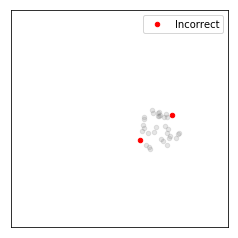

Vizualizing test_task:slice_2:pred predictions on labelset:slice_2:pred


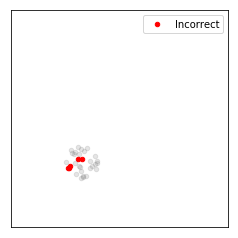

In [14]:
for model_name in model_configs.keys():
    if model_name == 'soft_param':
        labelcats_to_tasks = {
            "labelset:slice_1:pred": "test_task:slice_1:pred",
            "labelset:slice_2:pred": "test_task:slice_2:pred",    
            "labelset:slice_1:ind": "test_task:slice_1:ind",
            "labelset:slice_2:ind": "test_task:slice_2:ind",
        }
    else:
        labels_to_tasks = {
            "labelset:slice_1:pred": "test_task:slice_1:pred",
            "labelset:slice_2:pred": "test_task:slice_2:pred",        
        }

    eval_payload.remap_labelsets(labels_to_tasks, default_none=True)
    if model_name in ["hard_param", "soft_param", "manual_reweighting", "slice_qp_rep"]:
        print(f"{'='*10}Evaluating {model_name}{'='*10}")
        score_and_visualize(trained_models[model_name], eval_payload)

### Evaluate model on primary task head

labelset 'labelset_gold' -> task 'test_task' (originally, None).
labelset 'labelset:slice_1:pred' -> task 'test_task' (originally, test_task:slice_1:pred).
labelset 'labelset:slice_2:pred' -> task 'test_task' (originally, test_task:slice_2:pred).
labelset 'labelset:remainder:pred' -> task 'test_task' (originally, None).
==========Evaluating slice_qp_rep==========
Eval mapping...
{   'labelset:remainder:ind': None,
    'labelset:remainder:pred': 'test_task',
    'labelset:slice_1:ind': None,
    'labelset:slice_1:pred': 'test_task',
    'labelset:slice_2:ind': None,
    'labelset:slice_2:pred': 'test_task',
    'labelset_gold': 'test_task'}
Model Scores:
{   'test_task/payload_test/labelset:remainder:pred/acc_f1': 0.9825011093524126,
    'test_task/payload_test/labelset:remainder:pred/accuracy': 0.9805743243243243,
    'test_task/payload_test/labelset:remainder:pred/f1': 0.9844278943805009,
    'test_task/payload_test/labelset:slice_1:pred/acc_f1': 0.9174208144796381,
    'test_task/pay

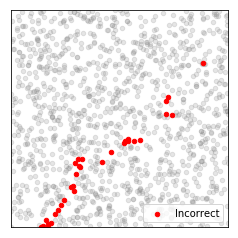

Vizualizing test_task predictions on labelset:slice_1:pred


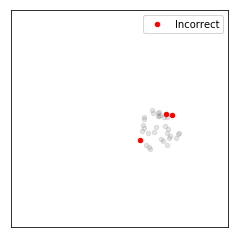

Vizualizing test_task predictions on labelset:slice_2:pred


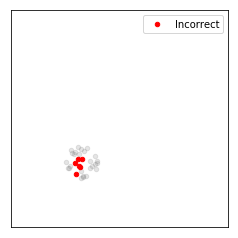

Vizualizing test_task predictions on labelset:remainder:pred


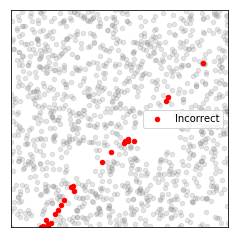

In [15]:
# map all labelsets to the primary task_head 
eval_payload.remap_labelsets(labels_to_tasks= {
        "labelset_gold": "test_task",
        "labelset:slice_1:pred": "test_task",
        "labelset:slice_2:pred": "test_task",
        "labelset:remainder:pred": "test_task",
    }, default_none=True
                            
)

for model_name in model_configs.keys():
    print(f"{'='*10}Evaluating {model_name}{'='*10}")
    score_and_visualize(trained_models[model_name], eval_payload)

### Visualize Attention Weights of `soft_param`

********** slice_qp_rep **********
labelset 'labelset:slice_1:ind' -> task 'test_task:slice_1:ind' (originally, None).
labelset 'labelset:slice_2:ind' -> task 'test_task:slice_2:ind' (originally, None).
Vizualizing test_task:BASE:ind attention on labelset_gold


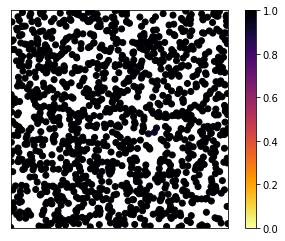

Vizualizing test_task:slice_1:ind attention on labelset_gold


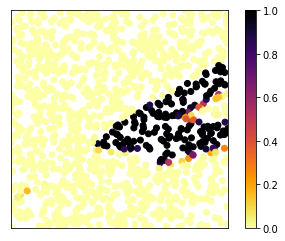

Vizualizing test_task:slice_2:ind attention on labelset_gold


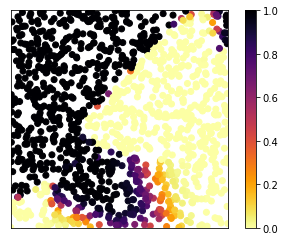

Vizualizing test_task:BASE:ind attention on labelset:slice_1:pred


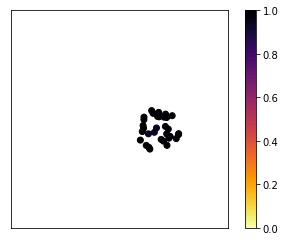

Vizualizing test_task:slice_1:ind attention on labelset:slice_1:pred


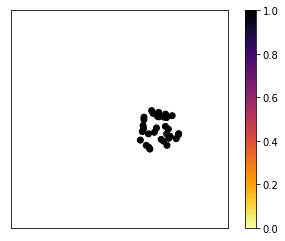

Vizualizing test_task:slice_2:ind attention on labelset:slice_1:pred


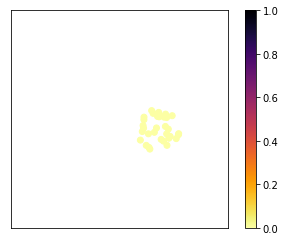

Vizualizing test_task:BASE:ind attention on labelset:slice_1:ind


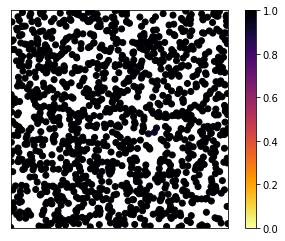

Vizualizing test_task:slice_1:ind attention on labelset:slice_1:ind


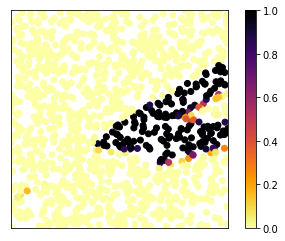

Vizualizing test_task:slice_2:ind attention on labelset:slice_1:ind


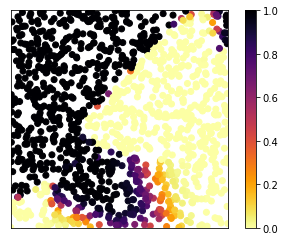

Vizualizing test_task:BASE:ind attention on labelset:slice_2:pred


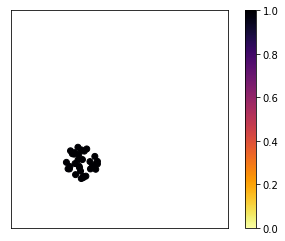

Vizualizing test_task:slice_1:ind attention on labelset:slice_2:pred


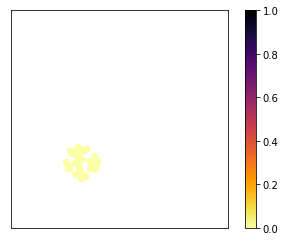

Vizualizing test_task:slice_2:ind attention on labelset:slice_2:pred


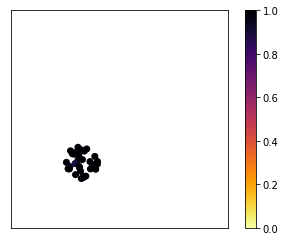

Vizualizing test_task:BASE:ind attention on labelset:slice_2:ind


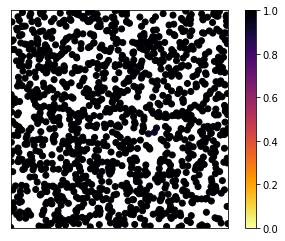

Vizualizing test_task:slice_1:ind attention on labelset:slice_2:ind


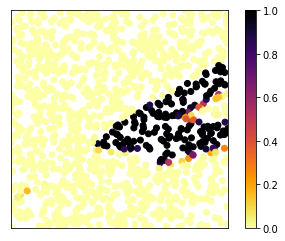

Vizualizing test_task:slice_2:ind attention on labelset:slice_2:ind


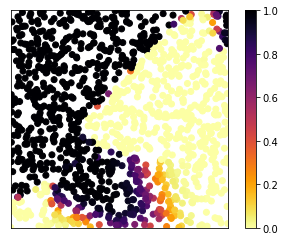

Vizualizing test_task:BASE:ind attention on labelset:remainder:pred


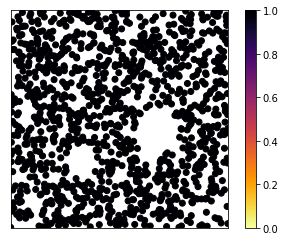

Vizualizing test_task:slice_1:ind attention on labelset:remainder:pred


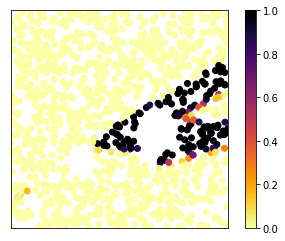

Vizualizing test_task:slice_2:ind attention on labelset:remainder:pred


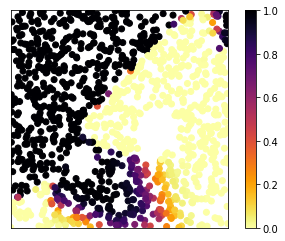

In [16]:
for model_name in trained_models.keys():
    if model_name not in ['soft_param', 'soft_param_rep', 'slice_qp_rep']:
        continue

    print(f'{"*"*10} {model_name} {"*"*10}')
    eval_payload.remap_labelsets(labels_to_tasks = {
            "labelset:slice_1:ind": "test_task:slice_1:ind",
            "labelset:slice_2:ind": "test_task:slice_2:ind"
        }
    )

    visualize_attention(trained_models[model_name], eval_payload)

## 